# Article figures for Asilomar SSA wave transformation

In [6]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
import statsmodels.api as smm
from datetime import datetime as DT
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
from matplotlib import colors
from matplotlib.lines import Line2D
import salem
import utm
from pyproj import Proj
# Interactive plots
%matplotlib widget 
from roxsi_pyfuns import stats as rps
from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import turbulence as rpt
from roxsi_pyfuns import plotting as rppl
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Paths, files
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
pc_root = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray'
# Figure output
outdir = os.path.join(pc_root, 'Article_figures')
# Bathymetry
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_50cm.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))
# Read bathymetry .mat file
fn_mat = os.path.join(bathydir, 'AsilomarAsubset_v2.mat')
bathy_mat = loadmat(fn_mat)
# Signature 1000 ADCP data
sig_root = os.path.join(rootdir, 'Signatures', 'Level1')
# Vector ADCP data
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')

# Wind speed & direction
fnw = os.path.join(rootdir, 'ROXSI_wind_corr.csv')
dfw = pd.read_csv(fnw, parse_dates=['time']).set_index('time')
# Interpolate over missing wind speed values
dfw = dfw.interpolate()

# Start/end dates/times of experiment period
t0 = pd.Timestamp('2022-06-27 00:00') # Start date
t1 = pd.Timestamp('2022-07-21 00:00') # End date

# Experiment vs. paper mooring IDs (Signatures and Vectors)
# sig_mids = {'C1':'SO', 'C3':'SM', 'C6':'SI', 'L1':'SS', 'L5':'SN'}
# vec_mids = {'C2':'VO', 'C3':'VM', 'C5':'VI', 'L1':'VS', 'L5':'VN'}
sig_mids = {'C1':'SO', 'C3':'SM', 'C6':'SI', 'L1':'SS', 'L5':'SN'}
vec_mids = {'C2':'VO', 'C3':'VM', 'C5':'VI', 'L1':'VS', 'L5':'VN'}

# Default Signature and Vector mooring ID colors
# clss = {'C1':'#a70000', 'C3':'#ff5252', 'C6':'#ffbaba', 
#         'L1':'gold', 'L5':'darkorange'}
clss = {'C1':'#a70000', 'C3':'#ff5252', 'C6':'#ffbaba', 'L5':'gold'}
clsv = {'C2':'#0A369D', 'C3':'#92B4F4', 'C5':'#CFDEE7', 'L5':'darkturquoise'}

# Vector bursts to skip due to noisy data despite despiking (manually checked)
vec_skip = {'L1':[pd.Timestamp('2022-07-01 12:00:00'),
                  pd.Timestamp('2022-07-02 20:00:00'),
                  pd.Timestamp('2022-07-03 14:00:00'),
                  pd.Timestamp('2022-07-04 13:00:00'),
                  pd.Timestamp('2022-07-04 14:00:00'),
                  pd.Timestamp('2022-07-04 15:00:00'),
                  pd.Timestamp('2022-07-11 10:00:00'),
                  pd.Timestamp('2022-07-17 05:00:00'),
                  ],
            'L5':[pd.Timestamp('2022-07-02 19:00:00'),
                  ],
            'C2':[],
            'C3':[],
            'C5':[],
            }

Figure 1: Study site & bathymetry

ValueError: You need to provide a Google API key or set the STATIC_MAP_API_KEY environment variable.

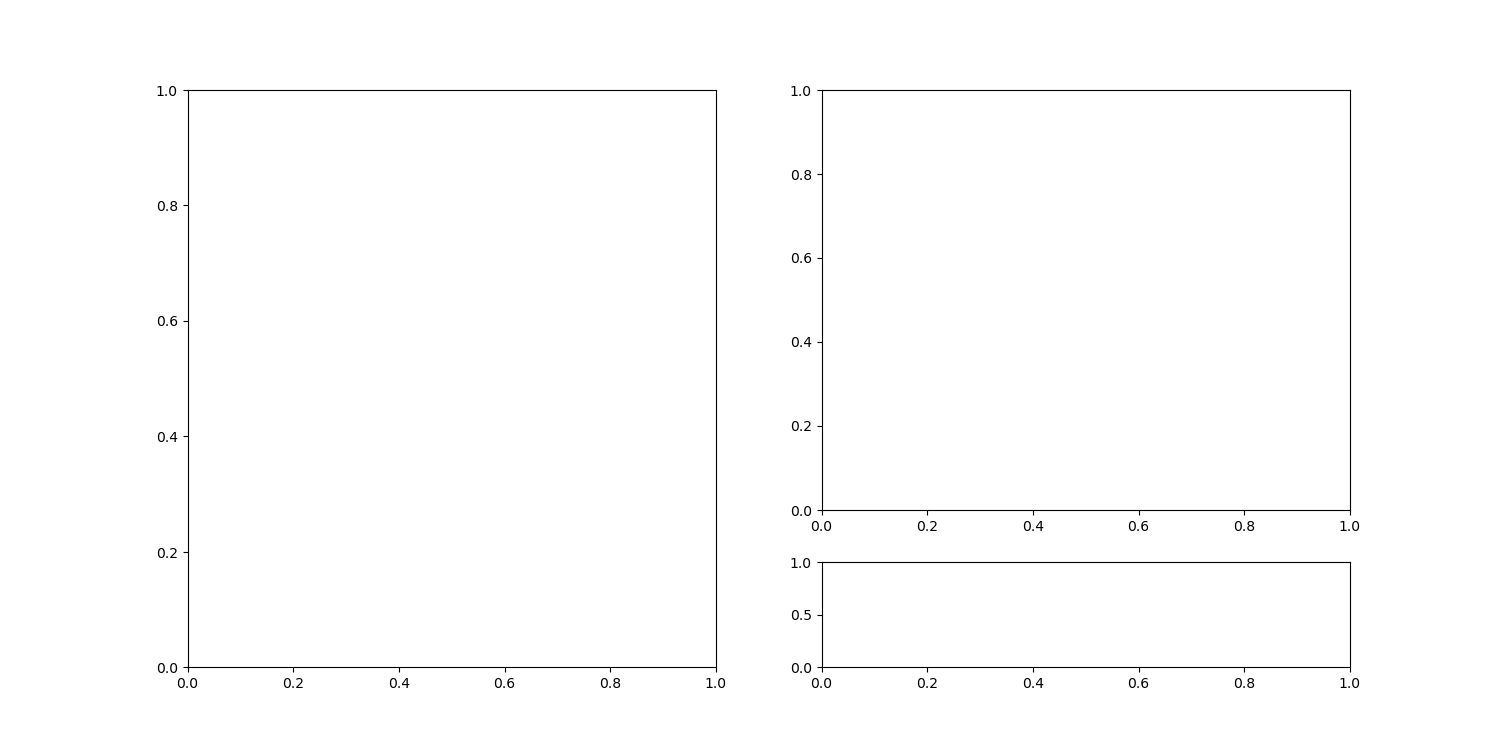

In [5]:
markers = True # Set to False to exclude all markers
mark_sig = True # Set to False to not mark Signature locations
mark_vec = False # Set to False to not mark Vector locations
mark_tran = False # Set to False to not mark transect boundaries
mark_c1c6 = True # If True, only mark SO and SI
# Plot w/ google satellite image following example from
# https://salem.readthedocs.io/en/stable/auto_examples/plot_googlestatic.html
if markers and mark_sig and mark_vec and mark_tran:
    fn_fig1 = os.path.join(outdir, 'fig1_v5.png')
elif markers and mark_sig and not mark_vec and not mark_tran and not mark_c1c6:
    fn_fig1 = os.path.join(outdir, 'fig1_v5_sig_only.png')
elif markers and mark_sig and not mark_vec and not mark_tran and mark_c1c6:
    fn_fig1 = os.path.join(outdir, 'fig1_v5_sosi_only.png')
elif markers and not mark_sig and mark_vec and not mark_tran:
    fn_fig1 = os.path.join(outdir, 'fig1_v5_vec_only.png')
elif markers and mark_sig and mark_vec and not mark_tran:
    fn_fig1 = os.path.join(outdir, 'fig1_v5_sig_vec.png')
else:
    fn_fig1 = os.path.join(outdir, 'fig1_v5_nomarkers.png')
# if not os.path.isfile(fn_fig1):
if os.path.isfile(fn_fig1):
    utm_zone = 10 # Standard UTM zone number (northern hemisphere)
    FFX = 0 # Fudge Factor in x (East)
    FFY = -5 # Fudge Factor in y (North) -5 seems to work well

    # UTM coordinates of box corners and middle of rock from GPS 
    # measurements of safety sausage from boat. Errors in these are 
    # up to several meters due to GPS error and currents
    IN = [594490.19 + FFX, 4053805.82 + FFY] # Inshore North
    ON = [594478.45 + FFX, 4053815.67 + FFY] # Offshore North
    OS = [594470.48 + FFX, 4053808.93 + FFY] # Offshore South
    IS = [594477.74 + FFX, 4053799.02 + FFY] # Inshore South

    # UTM coordinates of box corners and middle of rock, 
    # approximated by eye based on estimated positions relative 
    # to bathymetric features 
    IS_est = np.array([0.594476227663551, 4.053794712172897]) * 1e6
    OS_est = np.array([0.594470871355140, 4.053806078995327]) * 1e6
    IN_est = np.array([0.594488330467290, 4.053799782266355]) * 1e6
    ON_est = np.array([0.594479294252336, 4.053812580163552]) * 1e6

    # Calculate line segment lengths
    ON_IN = np.sqrt((ON[0]-IN[0])**2 + (ON[1]-IN[1])**2)
    IN_IS = np.sqrt((IN[0]-IS[0])**2 + (IN[1]-IS[1])**2)
    IS_OS = np.sqrt((IS[0]-OS[0])**2 + (IS[1]-OS[1])**2)
    OS_ON = np.sqrt((OS[0]-ON[0])**2 + (OS[1]-ON[1])**2)

    ON_IN_est = np.sqrt((ON_est[0]-IN_est[0])**2 + 
                        (ON_est[1]-IN_est[1])**2)
    IN_IS_est = np.sqrt((IN_est[0]-IS_est[0])**2 + 
                        (IN_est[1]-IS_est[1])**2)
    IS_OS_est = np.sqrt((IS_est[0]-OS_est[0])**2 + 
                        (IS_est[1]-OS_est[1])**2)
    OS_ON_est = np.sqrt((OS_est[0]-ON_est[0])**2 + 
                        (OS_est[1]-ON_est[1])**2)

    # Select subset of bathymetry data in region around small-scale 
    # array. Make a box that lines up with UTM of subsurface buoys 
    # with a buffer region around it. 
    BUFFERREGION = 10  # size of buffer region beyond coords of subsurface buys
    eastingMin = min(np.array([IN[0],ON[0],OS[0],IS[0]]) - BUFFERREGION)
    eastingMax = max(np.array([IN[0],ON[0],OS[0],IS[0]]) + BUFFERREGION)
    northingMin = min(np.array([IN[1],ON[1],OS[1],IS[1]]) - BUFFERREGION)
    northingMax = max(np.array([IN[1],ON[1],OS[1],IS[1]]) + BUFFERREGION)
    vmin = -8.0
    vmax = -3.5

    # New coordinate system that is 0 in SW corner of subset bathymetry
    asilomarAsubset_x = bathy_mat['asilomarAsubset_x'].squeeze() 
    asilomarAsubset_y = bathy_mat['asilomarAsubset_y'].squeeze() 
    asilomarAsubset_z = bathy_mat['asilomarAsubset_z'].squeeze() 
    x = asilomarAsubset_x - eastingMin
    y = asilomarAsubset_y - northingMin

    # Create grid for gridded bathymetry data in local coordinate system
    nx = 81
    xsl = np.linspace(0, 40, nx)
    ny = 71
    ysl = np.linspace(0, 35, ny)
    Xsl, Ysl = np.meshgrid(xsl, ysl)
    # Interpolate topography to Xs, Ys grid
    Zsl = griddata((x,y), asilomarAsubset_z, (Xsl,Ysl))

    # Create grid for gridded bathymetry data in UTM coordinates
    xsu = np.linspace(asilomarAsubset_x.min(), asilomarAsubset_x.max(), nx)
    dx = xsu[1] - xsu[0]
    ysu = np.linspace(asilomarAsubset_y.min(), asilomarAsubset_y.max(), ny)
    dy = ysu[1] - ysu[0]
    Xsu, Ysu = np.meshgrid(xsu, ysu)
    # Interpolate topography to Xs, Ys grid
    Zsu = griddata((asilomarAsubset_x, asilomarAsubset_y), asilomarAsubset_z, 
                   (Xsu,Ysu))
    
    fig, axes = plt.subplots(figsize=(15,7.5), ncols=2, nrows=2, height_ratios=[4,1])
    # Combine left column rows
    gs = axes[0,0].get_gridspec()
    # remove the underlying axes
    for ax in axes[:,0]:
        ax.remove()
    axbig = fig.add_subplot(gs[:, 0])

    # Define background boundaries for plot (P)
    buffer = 140 # Buffer distance (m)
    latMinP, lonMinP = utm.to_latlon(eastingMin-buffer+120, northingMin-buffer, 
                                     zone_number=utm_zone, northern=True)
    latMaxP, lonMaxP = utm.to_latlon(eastingMax+buffer+120, northingMax+buffer, 
                                     zone_number=utm_zone, northern=True)

    # If you need to do a lot of maps you might want
    # to use an API key and set it here with key='YOUR_API_KEY'
    g = salem.GoogleVisibleMap(x=[lonMinP, lonMaxP], y=[latMinP, latMaxP],
                               scale=2,  # scale is for more details
                               maptype='satellite',
                               )
    # The google static image is a standard rgb image
    ggl_img = g.get_vardata()

    # Make a map of the same size as the image (no country borders)
    sm = salem.Map(g.grid, factor=2, countries=False)
    sm.set_shapefile()  # add the glacier outlines
    sm.set_rgb(ggl_img)  # add the background rgb image
    sm.set_scale_bar(location=(0.13, 0.12), color='white')  # add scale
    sm.set_lonlat_contours(max_nticks=6)
    sm.visualize(ax=axes[0,1])  # plot it

    # Define UTM WGS84 projection for SSA grid
    proj_utm = Proj(proj='utm', zone=utm_zone, ellps='WGS84', 
                    preserve_units=False)
    # Transform SSA grid coordinates to google map projection
    xx, yy = sm.grid.transform(Xsu, Ysu, crs=proj_utm)
    # Plot bathymetry on top of satellite image
    axes[0,1].contourf(xx, yy, Zsu, cmap=cmocean.cm.deep_r, vmin=vmin, vmax=vmax)

    # Mark SSA location with star
    proj_utm = Proj(proj='utm', zone=utm_zone, ellps='WGS84', preserve_units=False)
    em = (eastingMax + eastingMin) / 2
    nm = (northingMax + northingMin) / 2
    latm, lonm = utm.to_latlon(em, nm, zone_number=utm_zone, northern=True)
    # Convert to UTM
    xpu, ypu = proj_utm(lonm, latm)
    # Convert UTM coordinates to google image projection
    xp, yp = sm.grid.transform(xpu, ypu, crs=proj_utm)
    axes[0,1].scatter(xp, yp, marker='*', c='salmon', edgecolors='k', s=350)

    # Annotate (b)
    axes[0,1].annotate('(b)', xy=(0.02, 0.93), xycoords='axes fraction', fontsize=18, 
                color='white')

#     # Show/save plot
#     plt.tight_layout()
#     # plt.show()
#     if not os.path.isfile(fn_fig1a):
#         plt.savefig(fn_fig1a, bbox_inches='tight', dpi=450)
#     plt.close()

# # Bathymetry plot with mean transect line
# fn_fig1b = os.path.join(outdir, 'bathymetry_zoom.png')
# if not os.path.isfile(fn_fig1b):
#     fig, axes = plt.subplots(figsize=(7,7), nrows=2, height_ratios=[4,1], sharex=True)
    vmin = -8 
    vmax = -4
    # Set zoom in region
    x0 = dsb.C3.attrs['x_loc'].round() # C3 mooring location in the middle
    y0 = dsb.C3.attrs['y_loc'].round()
    xmin = x0 - 15
    xmax = x0 + 15
    ymin = y0 - 15
    ymax = y0 + 15
    bathy_zoom = dsb.z_msl.sel(x=slice(xmin, xmax), y=slice(ymin, ymax)).copy()
    im = bathy_zoom.plot.pcolormesh(ax=axbig, add_colorbar=False, vmin=vmin, vmax=vmax,
                                    cmap=cmocean.cm.deep_r)
    # Colorbar on right
    cax = axbig.inset_axes([1.01, 0.00, 0.05, 1.0], transform=axbig.transAxes)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_title(r'  $z$ [m]')
    # Take 1D transect to plot on bottom row
    ymin_t = y0 - 3
    ymax_t = y0 + 3
    transect = dsb.z_msl.sel(x=slice(xmin, xmax), y=slice(ymin_t, ymax_t)).mean(dim='y')
    # Mark and annotate moorings
    x_c1, y_c1 = (dsb.C1.attrs['x_loc'], dsb.C1.attrs['y_loc']) # C1 (Sig)
    x_c6, y_c6 = (dsb.C6.attrs['x_loc'], dsb.C6.attrs['y_loc']) # C6 (Sig)
    x_c2, y_c2 = (dsb.C2.attrs['x_loc'], dsb.C2.attrs['y_loc']) # C2 (Vec)
    x_c5, y_c5 = (dsb.C5.attrs['x_loc'], dsb.C5.attrs['y_loc']) # C5 (Vec)
#     x_l1, y_l1 = (dsb.L1.attrs['x_loc'], dsb.L1.attrs['y_loc']) # L1 (Vec)
    x_l5, y_l5 = (dsb.L5.attrs['x_loc'], dsb.L5.attrs['y_loc']) # L1 (Vec)
    if markers:
        # Mark boundaries of transect
        if mark_tran:
            axbig.axhline(ymin_t, ls='--', lw=2, color='white')
            axbig.axhline(ymax_t, ls='--', lw=2, color='white')
        if mark_sig:
            # C3 Sig
            axbig.scatter(x0, y0, marker='o', color=clss['C3'], s=250, edgecolors='k')
            axbig.text(x0-1, y0+1, s='SM', color=clss['C3'], fontsize=18)
            # C1 Sig
            axbig.scatter(x_c1, y_c1, marker='o', color=clss['C1'], s=250, edgecolors='k') 
            axbig.text(x_c1-0.75, y_c1+1, s='SO', color=clss['C1'], fontsize=18)
            # C6 Sig
            axbig.scatter(x_c6, y_c6, marker='o', color=clss['C6'], s=250, edgecolors='k') 
            axbig.text(x_c6-0.5, y_c6+1, s='SI', color=clss['C6'], fontsize=18)
            # L1 Sig
        #      axbig.scatter(x_l1, y_l1, marker='o', color=clss['L1'], s=250, edgecolors='k') 
        #      axbig.text(x_l1-0.75, y_l1+1, s='SS', color=clss['L1'], fontsize=18)
            # L5 Sig
            axbig.scatter(x_l5, y_l5, marker='o', color=clss['L5'], s=250, edgecolors='k') 
            axbig.text(x_l5-0.75, y_l5+1, s='SN', color=clss['L5'], fontsize=18)
        if mark_vec:
            # C2 Vec
            axbig.scatter(x_c2, y_c2, marker='^', color=clsv['C2'], s=250, edgecolors='k') 
            axbig.text(x_c2-0.75, y_c2+1, s='VO', color=clsv['C2'], fontsize=18)
            # C3 Vec
            axbig.scatter(x0-1, y0, marker='^', color=clsv['C3'], s=250, edgecolors='k')
            axbig.text(x0-1.85, y0-2, s='VM', color=clsv['C3'], fontsize=18,)
            # C5 Vec
            axbig.scatter(x_c5, y_c5, marker='^', color=clsv['C5'], s=250, edgecolors='k') 
            axbig.text(x_c5-0.5, y_c5-2, s='VI', color=clsv['C5'], fontsize=18)
            # L1 Vec
        #     axbig.scatter(x_l1-1, y_l1, marker='^', color=clsv['L1'], s=250, edgecolors='k') 
        #     axbig.text(x_l1-1.75, y_l1-2, s='VS', color=clsv['L1'], fontsize=18)
            # L5 Vec
            axbig.scatter(x_l5-1, y_l5, marker='^', color=clsv['L5'], s=250, edgecolors='k') 
            axbig.text(x_l5-1.75, y_l5-2, s='VN', color=clsv['L5'], fontsize=18)
    # No xlabel for top axis
    axbig.set_xlabel(r'Cross-shore coordinates [m]', fontsize=14)
    axbig.set_ylabel(r'Along-shore coordinates [m]', fontsize=14)
    # Make x axis for transect
    xt = transect.x.values - xmin
    # ax=axes[1].plot(xt, transect.values, color='k')
    transect.plot(ax=axes[1,1], color='k')
    axes[1,1].fill_between(transect.x.values, -9, transect.values, color='lightgray')
    # Mark C1, C3, C6 mooring locations with vertical lines
    if mark_sig:
        axes[1,1].axvline(x_c1, color=clss['C1'], ls='--')
        axes[1,1].text(x_c1-1.5, -4.75, s='SO', color=clss['C1'], fontsize=12)
        if not mark_c1c6:
            # For OSM presentation figure, only mark SO and SI
            axes[1,1].axvline(x0, color=clss['C3'], ls='--')
            axes[1,1].text(x0+0.5, -4.75, s='SM', color=clss['C3'], fontsize=12)
        axes[1,1].axvline(x_c6, color=clss['C6'], ls='--')
        axes[1,1].text(x_c6+0.5, -4.75, s='SI', color=clss['C6'], fontsize=12)
    if mark_vec:
        axes[1,1].axvline(x_c2, color=clsv['C2'], ls='--')
        axes[1,1].text(x_c2-1.5, -4.75, s='VO', color=clsv['C2'], fontsize=12)
        axes[1,1].axvline(x0-1, color=clsv['C3'], ls='--')
        axes[1,1].text(x0-1-1.5, -4.75, s='VM', color=clsv['C3'], fontsize=12)
        axes[1,1].axvline(x_c5, color=clsv['C5'], ls='--')
        axes[1,1].text(x_c5+0.5, -4.75, s='VI', color=clsv['C5'], fontsize=12)
    # Remove empty space from x axis
    axes[1,1].margins(x=0)
    # Limits, labels
    axes[1,1].set_ylim([-9,-4])
    axes[1,1].set_ylabel(r'$z_\mathrm{\, t}$ [m]', fontsize=14)
    axes[1,1].set_xlabel(r'Cross-shore coordinates [m]', fontsize=14)
    # Tick label font sizes
    for ax in [axbig, axes[1,1]]:
        ax.tick_params(axis='both', which='major', labelsize=14)
    # Annotate (b), (c)
    axbig.annotate('(a)', xy=(0.02, 0.95), xycoords='axes fraction', fontsize=18, 
                   color='white')
    axes[1,1].annotate('(c)', xy=(0.02, 0.75), xycoords='axes fraction', fontsize=20, 
                     color='k')

    plt.tight_layout()
    if not os.path.isfile(fn_fig1):
        plt.savefig(fn_fig1, bbox_inches='tight', dpi=600)
        plt.close()
    else:
        plt.show()
    # plt.show()


print('Done.')

Figure 2: Time series of wave parameters

In [69]:
# Sig100 serial number to visualize
# serss = ['103063', '103206', '103088', '103094', '103110']
# midss = ['L1', 'L5', 'C1', 'C3', 'C6'] # Mooring IDs
serss = ['103206', '103088', '103094', '103110']
midss = ['L5', 'C1', 'C3', 'C6'] # Mooring IDs
# Use all available serial numbers
spec_key = 'ASTd' # Spectrum heave product
# Save mean datasets in dict
dsds = {} # Spectrum datasets
# Good periods to crop Signature spectra to
sig_t0t1 = {'C1': slice(None, None),
            'C3': slice(None, None),
            'C6': slice(None, pd.Timestamp('2022-07-14 10:00')),
            'L1': slice(pd.Timestamp('2022-07-06 06:00'), 
                        pd.Timestamp('2022-07-11 18:00')),
            'L5': slice(pd.Timestamp('2022-07-05 13:00'),
                        pd.Timestamp('2022-07-14 10:00')),
            }
for ser, mid in zip(serss, midss):
    print('Reading {}-{} netcdf files ...'.format(ser, mid))
    # Get current serial number's spectrum directories
    specdir = os.path.join(sig_root, '{}'.format(ser), 'Spectra') 
    specdir_loc = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray/Spectra_ENU'
    # Get spectrum netcdf file
    fn_nc_spec = os.path.join(specdir_loc, 
                              'Asilomar_2022_SSA_Signature_{}_spec_AST_ENU.nc'.format(
                                  ser))
    dss = xr.decode_cf(xr.open_dataset(fn_nc_spec, decode_coords='all'))
    # Crop time series based on good periods
    dss = dss.sel(time=sig_t0t1[mid])
    # Also crop based on specified experiment period
    dss = dss.sel(time=slice(t0, t1))
    # Estimate horizontal velocity spectrum from AST spec using LWT + Stokes 2nd-order
    m0l = [] # Empty list for appending m0uv values per timestamp
    m0s = [] # Empty list for appending m0uv for Stokes 2nd-order
    m0lv = [] # Empty list for appending m0uv values per timestamp for nearest Vec
    m0sv = [] # Empty list for appending m0uv-Stokes for nearest Vec
    for ts in dss.time.values:
        ts = pd.Timestamp(ts) # Just in case
        spec_ast = dss.Ezz.sel(time=ts).copy() # Current AST spectrum
        # Use depth from nearest Vector
        fn_urms_csv = os.path.join(vec_root, 'Urms_csv', 'C2_urms_v3.csv')
        depth = dss.depth_loc.sel(time=ts).item() # Local water depth at instrument
        zb = 0.5 # Height of measurement above bottom
        fslice = slice(0.05, 0.35) # Frequency range for m0
        # Compute linear wavenumbers for AST spectrum
        omega = 2*np.pi * spec_ast.sel(freq=fslice).freq.values
        kl = rpws.waveno_full(omega, d=depth) # Lin. waveno.s
        # Estimate velocity spectrum from AST spectrum using LWT
        factor = np.cosh(kl * zb) / np.sinh(kl * depth)
        Euu_lin = spec_ast.sel(freq=fslice) * omega**2 * factor**2
        # Compute zeroth order moment of estimated velocity spectrum
        m0uv = rpws.spec_moment(Euu_lin.sel(freq=fslice).values, 
                                spec_ast.sel(freq=fslice).freq.values, 
                                order=0)
        # Stokes 2nd-order m0_uv
        factor_stokes = (3*np.cosh(2*kl*zb)) / (4*np.sinh(kl*depth)**4)
        Euu_stokes = (spec_ast.sel(freq=fslice) * omega**2 * factor**2 +\
                      spec_ast.sel(freq=fslice)**2 * omega**2 * kl**2 * factor_stokes**2)
        # Compute zeroth order moment of estimated Stokes velocity spectrum
        m0uv_stokes = rpws.spec_moment(Euu_stokes.sel(freq=fslice).values, 
                                       spec_ast.sel(freq=fslice).freq.values, 
                                       order=0)
        # Append to lists
        m0l.append(m0uv)
        m0s.append(m0uv_stokes)
        # Also compute linear uv estimate for nearest Vector for C1 and C6
        if mid in ['C1', 'C6']:
            # Read csv file with local Vector burst water depths
            if mid == 'C1':
                # Use C2 as nearest Vector to C1
                fn_urms_csv = os.path.join(vec_root, 'Urms_csv', 'C2_urms_v3.csv')
            elif mid == 'C6':
                # Use C5 as nearest Vector to C6
                fn_urms_csv = os.path.join(vec_root, 'Urms_csv', 'C5_urms_v3.csv')
            if os.path.isfile(fn_urms_csv):
                dfi = pd.read_csv(fn_urms_csv, parse_dates=['time']).set_index('time')
            else:
                continue
            depth_vec = dfi['depth_loc'].loc[ts].item() # Local water depth at Vec
            zb = 0.5 # Height of measurement above bottom
            fslice = slice(0.05, 0.35) # Frequency range for m0
            # Compute linear wavenumbers for AST spectrum
            omega = 2*np.pi * spec_ast.sel(freq=fslice).freq.values
            kl = rpws.waveno_full(omega, d=depth_vec) # Lin. waveno.s at Vec
            # Estimate velocity spectrum from AST spectrum using LWT
            factor = np.cosh(kl * zb) / np.sinh(kl * depth_vec)
            Euu_lin_vec = spec_ast.sel(freq=fslice) * omega**2 * factor**2
            # Compute zeroth order moment of estimated velocity spectrum
            m0uv_vec = rpws.spec_moment(Euu_lin_vec.sel(freq=fslice).values, 
                                        spec_ast.sel(freq=fslice).freq.values, 
                                        order=0)
            # Stokes 2nd-order m0_uv
            factor_stokes = (3*np.cosh(2*kl*zb)) / (4*np.sinh(kl*depth_vec)**4)
            Euu_stokes_vec = (spec_ast.sel(freq=fslice) * omega**2 * factor**2 +\
                              spec_ast.sel(freq=fslice)**2 * (omega**2 * kl**2 * factor_stokes**2))
            # Compute zeroth order moment of estimated Stokes velocity spectrum
            m0uv_vec_stokes = rpws.spec_moment(Euu_stokes_vec.sel(freq=fslice).values, 
                                               spec_ast.sel(freq=fslice).freq.values, 
                                               order=0)
            # Append to list
            m0lv.append(m0uv_vec)
            m0sv.append(m0uv_vec_stokes)
        
    # Add m0uv (linear + Stokes) to dataset
    dss['m0uv_lin'] = (['time'], np.array(m0l))
    dss['m0uv_stokes'] = (['time'], np.array(m0s))
    if mid in ['C1', 'C6']:
        dss['m0uv_lin_vec'] = (['time'], np.array(m0lv))
        dss['m0uv_stokes_vec'] = (['time'], np.array(m0sv))
    # Also add Hrms
    dss['Hrms'] = (['time'], 0.5 * np.sqrt(2) * dss.Hm0.values)
    # Also add Tp
    dss['Tp'] = (['time'], dss.Tp_Y95.values)
    # Also add depth
    dss['depth'] = (['time'], dss.depth_loc.values)
    # Manually remove erroneous depth values
    if mid == 'C1':
        # dss.depth.loc[pd.Timestamp('2022-07-03 23:00')] = np.nan
        dss.depth.loc[pd.Timestamp('2022-07-04 00:00')] = np.nan
        dss.depth.loc[pd.Timestamp('2022-07-04 01:00')] = np.nan
        dss.depth.loc[pd.Timestamp('2022-07-05 00:00')] = np.nan
    # Crop time
    dss = dss.sel(time=slice(t0, t1))
    dsds[mid] = dss # Save dataset to dict

# Get Vector Urms and mean w
# midsv = ['L1', 'L5', 'C2', 'C3', 'C5']
# sersv = ['6338', '6308', '17212', '17219', '17372']
midsv = ['L5', 'C2', 'C3', 'C5']
sersv = ['6308', '17212', '17219', '17372']
date_range = pd.date_range(t0, t1, freq='1D')
dfv_dict = {} # Dict for Vector Urms/mean(w) dataframes 
outdir_vecspec = os.path.join(pc_root, 'Vectors')

# Main loop to iterate over dates and desired moorings
for mid, ser in zip(midsv, sersv):
    print(f'Getting {mid} Vec Urms...')
    # Check if dataframe and u,v spectral datasets already saved to csv
    fn_urms_csv = os.path.join(vec_root, 'Urms_csv', f'{mid}_urms_v3.csv')
    is_csv = os.path.isfile(fn_urms_csv)
    fn_uspec_nc = os.path.join(outdir_vecspec, f'uspec_{mid}.nc')
    is_uspec = os.path.isfile(fn_uspec_nc)
    fn_vspec_nc = os.path.join(outdir_vecspec, f'vspec_{mid}.nc')
    is_vspec = os.path.isfile(fn_vspec_nc)
    fn_fthspec_nc = os.path.join(outdir_vecspec, f'fthspec_{mid}.nc')
    is_fthspec = os.path.isfile(fn_fthspec_nc)
    if is_csv:
        dfi = pd.read_csv(fn_urms_csv, parse_dates=['time']).set_index('time')
    if not is_csv or not is_uspec or not is_vspec or not is_fthspec:
        # Initialize pd.DataFrame for Urms, mean(w), dissipation rate (phase res.),
        # horizontal velocity zeroth spectral moment m0uv and cross-shore vel.
        # skewness
        index = pd.date_range(t0, t1, freq='1H')
        dfi = pd.DataFrame(data={'Urms':np.ones_like(index).astype(float)*np.nan, 
                                 'wm':np.ones_like(index).astype(float)*np.nan,
                                 'eps_ps':np.ones_like(index).astype(float)*np.nan,
                                 'eps_ps_std':np.ones_like(index).astype(float)*np.nan,
                                 'eps_lt':np.ones_like(index).astype(float)*np.nan,
                                 'm0uv':np.ones_like(index).astype(float)*np.nan,
                                 'm0w':np.ones_like(index).astype(float)*np.nan,
                                 'skew_ucs':np.ones_like(index).astype(float)*np.nan,
                                 'depth_loc':np.ones_like(index).astype(float)*np.nan,
                                 'phase_uw':np.ones_like(index).astype(float)*np.nan,
                                 'phase_up':np.ones_like(index).astype(float)*np.nan,
                                 },
                           index=index)
        # Rename time index
        dfi.index = dfi.index.rename('time')
        # List for appending cross- and alongshore velocity spectra for merging
        uspec_list = []
        vspec_list = []
        fthspec_list = []
        for date in date_range:
            # Read Vector netcdf file
            ncdir = os.path.join(vec_root, mid)
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
                str(date.strftime('%Y%m%d'))))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))

            # Iterate over bursts
            hour_range = pd.date_range(date, date+pd.Timedelta(days=1), freq='1H')
            for t0b in hour_range[:-1]:
                t1b = t0b + pd.Timedelta(hours=1) # Burst end ts
                if t1b > t1:
                    continue
                # Select sample period
                seg = dsv.sel(time=slice(t0b, t1b))
                # Check for fraction of spikes in Vector burst
                spikes_frac_x = np.sum(~np.isclose(seg.ux, seg.uxd)) / len(seg.uz)
                spikes_frac_y = np.sum(~np.isclose(seg.uy, seg.uyd)) / len(seg.uz)
                spikes_frac_z = np.sum(~np.isclose(seg.uz, seg.uzd)) / len(seg.uz)
                # Max fraction of spikes = 0.2
                if spikes_frac_x>0.2 or spikes_frac_y>0.2 or spikes_frac_z>0.2:
                    continue
                # Check if burst should be skipped due to manual inspection
                if t0b in vec_skip[mid]:
                    continue
                # Get sea-surface elevation (K_rms transform)
                eta = seg.eta_lin_krms.copy().to_series() # Surface elevation
                pressure = seg.pressure.copy().to_series() # Pressure
                # Convert velocities to cross-/alongshore
                if mid in ['L1', 'L5']:
                    # x vel, despiked
                    uxd = seg.uxd.to_dataframe() # Convert to pandas
                    uxd = uxd.interpolate(method='bfill').interpolate('ffill')
                    uxm = uxd.mean().item()
                    uxd -= uxm # Remove mean
                    # uxd -= uxm
                    # y vel, despiked
                    uyd = seg.uyd.to_dataframe() # Convert to pandas
                    uyd = uyd.interpolate(method='bfill').interpolate('ffill')
                    uym = uyd.mean().item()
                    uyd -= uym # Remove mean
                    # uyd -= uym
                    # z vel, despiked
                    uzd = seg.uzd.to_dataframe() # Convert to pandas
                    uzd = uzd.interpolate(method='bfill').interpolate('ffill')
                    uzm = uzd.mean().item()
                    uzd -= uzm # Remove mean
                    # uzd -= uzd.mean()
                    # Rotate velocities to cross/alongshore & vertical using PCA
                    ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                                       uy=uyd.values.squeeze(), 
                                                       uz=uzd.values.squeeze(),
                                                       # print_msg=True,
                                                       )
                    # Check that ucs is in the right (shoreward) direction by computing 
                    # mean wave direction from directional wave spectrum
                    dssu = rpws.spec_uvz(z=eta.values, u=ucs, v=uls, fs=16, fmerge=5)
                    # If mdir close to 90 deg -> flip velocities
                    if abs(dssu.mdir.item() - 270) > 90:
                        ucs *= (-1)
                        uls *= (-1)
                        uw *= (-1)
                else:
                    # Convert E,N velocities to local cross- & alongshore 
                    uE = seg.uE.to_dataframe() # Convert to pandas
                    uE = uE.interpolate(method='bfill').interpolate('ffill')
                    uE -= uE.mean() # Remove mean
                    uN = seg.uN.to_dataframe() # Convert to pandas
                    uN = uN.interpolate(method='bfill').interpolate('ffill')
                    uN -= uN.mean() # Remove mean
                    uU = seg.uU.to_dataframe() # Convert to pandas
                    uU = uU.interpolate(method='bfill').interpolate('ffill')
                    dss_seg = rpws.spec_uvz(z=eta.values, 
                                            u=uE.values.squeeze(), 
                                            v=uN.values.squeeze(), 
                                            fs=16,
                                            fmerge=5,
                                            )
                    # Convert to cross-alongshore based on mean wave direction
                    angle_met = dss_seg.mdir.item() # Cross-shore angle
                    angle_math = 270 - angle_met # Math angle to rotate
                    if angle_math < 0:
                        angle_math += 360
                    angle_math = np.deg2rad(angle_math) # Radians
                    # Rotate East and North velocities to cross-shore (cs) and 
                    # long-shore (ls)
                    ucs, uls = rpct.rotate_vel(uE.values.squeeze(), 
                                               uN.values.squeeze(), 
                                               angle_math,
                                               )
                    uw = uU.values.squeeze() # Vertical vel.
                # Estimate U-rms for burst
                uspec = rpws.spec_uvz(ucs, fs=16, fmerge=5)
                # Assign time coordinate
                uspec = uspec.assign_coords(time=[t0b])
                # Append uspec to list for merging and saving
                uspec_list.append(uspec)
                vspec = rpws.spec_uvz(uls, fs=16, fmerge=5)
                # Assign time coordinate
                vspec = vspec.assign_coords(time=[t0b])
                # Append vspec to list for merging and saving
                vspec_list.append(vspec)
                wspec = rpws.spec_uvz(uw, fs=16, fmerge=5)
                # Directional uv-p spectrum
                depth = dsv.z_hyd.mean().item()
                fthspec = rpws.spec_uvz(z=pressure.values.squeeze(), u=ucs, v=uls, 
                                        fs=16, fmerge=5, depth=depth)
                # Assign time coordinate
                fthspec = fthspec.assign_coords(time=[t0b])
                fthspec_list.append(fthspec)
                # Variance of cross- and alongshore orbital velocities
                m0u = rpws.spec_moment(uspec.Ezz.values, uspec.freq.values, 0)
                m0v = rpws.spec_moment(vspec.Ezz.values, vspec.freq.values, 0)
                m0w = rpws.spec_moment(wspec.Ezz.values, wspec.freq.values, 0)
                Urms = np.sqrt(2 * (m0u + m0v))
                wm = np.nanmean(uw)
                # Populate dataframe
                dfi['Urms'].loc[t0b] = Urms
                dfi['wm'].loc[t0b] = wm
                # Also save m0 of u+v spectrum for comparison against LWT
                fslice = slice(0.05, 0.35)
                # Hor. velocity magnitude spec. from C3 Vector
                Euv_vec = (uspec.Ezz + vspec.Ezz).sel(freq=fslice) 
                # Take zeroth moment
                m0uv = rpws.spec_moment(Euv_vec.sel(freq=fslice).values, 
                                        Euv_vec.sel(freq=fslice).freq.values, 
                                        order=0)
                # Add m0uv and m0w to dataframe
                dfi['m0uv'].loc[t0b] = m0uv
                dfi['m0w'].loc[t0b] = m0w
                # Compute skewness of cross-shore velocity
                skew_ucs = stats.skew(ucs)
                dfi['skew_ucs'].loc[t0b] = skew_ucs
                # Local water depth
                dfi['depth_loc'].loc[t0b] = seg.z_hyd.mean().item()
                # Compute coherence and phase of ucs and uw
                spec_r = rpws.spec_uvz(z=uw, u=ucs, v=uls, fs=16)
                # Get index of max. coherence^2 b/w ucs and uw
                ind_mcu = np.argmax((spec_r.coh_uz**2).sel(freq=slice(0.05, 0.35)).values).item()
                # Compute ucs-uw phase at max coherence
                pmc = np.rad2deg(spec_r.ph_uz.sel(freq=slice(0.05, 0.35)).isel(freq=ind_mcu).item())
                dfi['phase_uw'].loc[t0b] = pmc

                # Also compute phase between u and pressure
                spec_rp = rpws.spec_uvz(z=eta, u=ucs, v=uls, fs=16)
                # Get index of max. coherence^2 b/w ucs and p
                ind_mcu = np.argmax((spec_rp.coh_uz**2).sel(freq=slice(0.05, 0.35)).values).item()
                # Compute ucs-p phase at max coherence
                pmc = np.rad2deg(spec_rp.ph_uz.sel(freq=slice(0.05, 0.35)).isel(freq=ind_mcu).item())
                dfi['phase_up'].loc[t0b] = pmc

            # Read daily dissipation rate files
            csvdir = os.path.join(ncdir, 'dissipation_rate')
            if not os.path.isdir(csvdir):
                os.mkdir(csvdir)
            fn_csv_diss = os.path.join(csvdir, 
                                       'burst_diss_{}_{}_nhours_24.csv'.format(
                                           mid, date.strftime('%Y%m%d_%H%M')))
            if os.path.isfile(fn_csv_diss):
                # Read daily dissipation rate file
                dfeps = pd.read_csv(fn_csv_diss, parse_dates=['time']).set_index(
                    'time')
                # Populate dataframe
                for t0b in hour_range[:-1]:
                    dfi['eps_ps'].loc[t0b] = dfeps['eps_phase'].loc[t0b]
                    dfi['eps_ps_std'].loc[t0b] = dfeps['eps_phase_std'].loc[t0b]
                    dfi['eps_lt'].loc[t0b] = dfeps['eps_LT83'].loc[t0b]

        # Save complete dataframe to csv
        if not is_csv:
            dfi.to_csv(fn_urms_csv)
        # Merge and save u and v spectra
        ds_uspec = xr.concat(uspec_list, dim='time')
        if not is_uspec:
            print('Saving u-spec ...')
            ds_uspec.to_netcdf(fn_uspec_nc)
        ds_vspec = xr.concat(vspec_list, dim='time')
        if not is_vspec:
            print('Saving v-spec ...')
            ds_vspec.to_netcdf(fn_vspec_nc)
        ds_fthspec = xr.concat(fthspec_list, dim='time')
        if not is_fthspec:
            print('Saving fth-spec ...')
            ds_fthspec.to_netcdf(fn_fthspec_nc)
    # Add complete dataframe to dict
    dfv_dict[mid] = dfi

# Figure filename
fn_fig2 = os.path.join(outdir, 'fig2_v6.pdf')
lw = 0.75 # Linewidth
if not os.path.isfile(fn_fig2):
    # Plot time series
    fontsize = 11
    fig, axes = plt.subplots(figsize=(7.5,9), nrows=7, sharex=True, 
                             height_ratios=[1,2,2,2,2,2,2])
                            # constrained_layout=True,)
    # Signature wave variables on top 2 rows
    for i, (mid, ser) in enumerate(zip(midss, serss)):
        eta = (dsds['C1'].depth - dsds['C1'].depth.mean(dim='time')).copy()
        eta.interpolate_na(dim='time', method='cubic').plot(ax=axes[0], 
                                                            c='k', lw=1)
        axes[0].set_ylabel(r'$\eta$ [m]', fontsize=fontsize)
        # Hrms on top
        dsds[mid].Hrms.sel(time=slice(t0,t1)).plot(ax=axes[1], 
                                                   color=clss[mid], 
                                                   label=sig_mids[mid],
                                                   lw=lw,
                                                   )
        axes[1].set_ylabel(r'$H_\mathrm{rms}$ [m]', fontsize=fontsize)
        # Tp on second row
        dsds[mid].Tp_Y95.sel(time=slice(t0,t1)).plot(ax=axes[2], 
                                                     color=clss[mid], 
                                                     label=sig_mids[mid],
                                                     lw=lw,
                                                     )
        axes[2].set_ylabel(r'$T_\mathrm{p}$ [s]', fontsize=fontsize)
        # skew(zeta) on third row
        dsds[mid].skew.sel(time=slice(t0,t1)).plot(ax=axes[3], 
                                                   color=clss[mid], 
                                                   label=sig_mids[mid],
                                                   lw=lw,
                                                   )
        axes[3].set_ylabel(r'$\mathrm{skew}(\zeta)$ [-]', fontsize=fontsize)

    # Vector velocity time series on remaining rows
    for i, (mid, ser) in enumerate(zip(midsv, sersv)):
        # Urms on 4th row
        axes[4].plot(dfv_dict[mid].index, dfv_dict[mid]['Urms'], label=vec_mids[mid],
                     color=clsv[mid], lw=lw)
        axes[4].set_ylabel(r'$u_\mathrm{\, rms}$ [m/s]', fontsize=fontsize)
        # skew(u) on 5th row
        axes[5].plot(dfv_dict[mid].index, dfv_dict[mid]['skew_ucs'], label=vec_mids[mid],
                     color=clsv[mid], lw=lw)
        axes[5].set_ylabel(r'$\mathrm{skew}(u)$ [-]', fontsize=fontsize)
#         # mean(w) on 4th row
#         axes[3].plot(dfv_dict[mid].index, dfv_dict[mid]['wm'], label=vec_mids[mid],
#                      color=clsv[mid])
#         axes[3].set_ylabel(r'$W$ [m/s]', fontsize=fontsize)
        # dissipation rate on 6th row
        axes[6].plot(dfv_dict[mid].index, dfv_dict[mid]['eps_ps'], label=vec_mids[mid],
                     color=clsv[mid], lw=lw)
        axes[6].set_ylabel(r'$\langle \epsilon \rangle$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$', 
                           fontsize=fontsize)
        # Log y scale
        axes[6].set_yscale('log')

    ann = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)'] 
    for i,ax in enumerate(axes):
        ax.set_xlabel(None)
        # Remove empty space from x axis
        ax.margins(x=0)
        ax.grid(alpha=0.5, lw=0.5)
        # Annotate (a), (b), ...
        ax.annotate(ann[i], xy=(0.0, 1.035), xycoords='axes fraction', fontsize=12)

    # Signature legend
    axes[1].legend(ncol=5, loc='lower right', fontsize=9)
    # Vector legend
    axes[4].legend(ncol=5, loc='upper left', fontsize=9)

    # Limits
    # axes[1].set_ylim([0, 2.25]) # For Hs
    axes[1].set_ylim([0, 1.6]) # For Hrms
    axes[1].set_yticks(np.linspace(0, 1.6, 5))
    axes[2].set_ylim([0, 15])
    axes[3].set_ylim([-0.15, 0.75])
    # axes[3].set_yticks(np.linspace(0, 0.6, 4))
    axes[3].set_yticks([0, 0.3, 0.6])
    axes[4].set_ylim([0, 1.5])
    # axes[3].set_ylim([-0.025, 0.125])
    axes[5].set_ylim([-0.3, 0.6])
    axes[5].set_yticks([-0.3, 0, 0.3, 0.6])
    axes[6].set_ylim([1e-6, 1e-2])
    axes[6].set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2])

    # Format x (time) axis
    date_axis = pd.date_range(t0, t1, freq='2D')
    axes[-1].set_xticks(date_axis)
    # Rotate date ticks
    # axes[-1].set_xticklabels(date_axis, rotation=30, ha='center')
    # Set date format
    myFmt = mdates.DateFormatter('%m/%d')
    axes[-1].xaxis.set_major_formatter(myFmt)
    # axes[0].margins(x=0)

    # Adjust spacing between subpots
    plt.subplots_adjust(wspace=0.0, hspace=0.18)
    plt.savefig(fn_fig2, bbox_inches='tight', dpi=600)
    plt.close()

print('Done.')

Reading 103206-L5 netcdf files ...
Reading 103088-C1 netcdf files ...
Reading 103094-C3 netcdf files ...
Reading 103110-C6 netcdf files ...
Getting L5 Vec Urms...
Getting C2 Vec Urms...
Getting C3 Vec Urms...
Getting C5 Vec Urms...
Done.


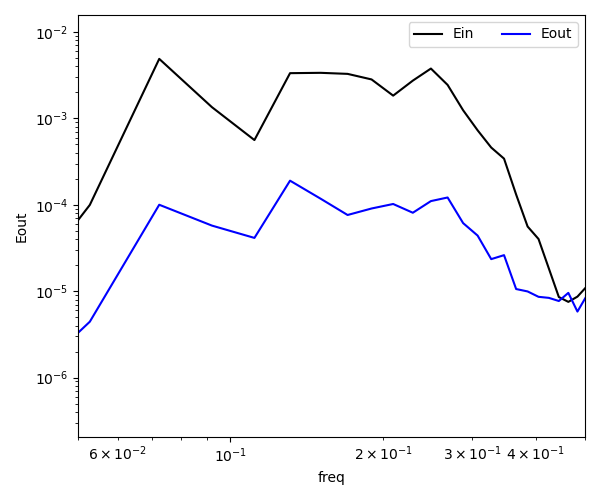

In [44]:
fig, ax = plt.subplots(figsize=(6,5))
ds_fthspec.isel(time=0).Ein.plot(ax=ax, color='k', label='Ein')
ds_fthspec.isel(time=0).Eout.plot(ax=ax, color='b', label='Eout')

ax.legend(ncols=2)
ax.set_xlim([0.05,0.5])
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
plt.show()
# plt.close()

kph min: 0.34, max: 2.62, mean: 0.90


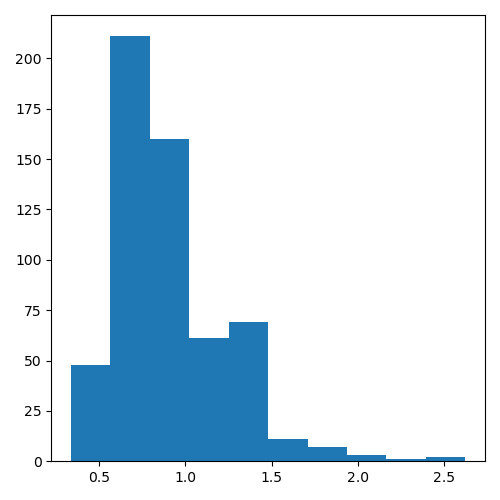

In [39]:
fig, ax  = plt.subplots(figsize=(5,5))
kph = (dsds['C1'].kp * dsds['C1'].depth)
print(f'kph min: {kph.min().item():.2f}, max: {kph.max().item():.2f}, mean: {kph.mean().item():.2f}')
(dsds['C1'].kp * dsds['C1'].depth).plot.hist(ax=ax)
plt.tight_layout()
plt.show()

Directional and bandwidth statistics - not shown in the manuscript.

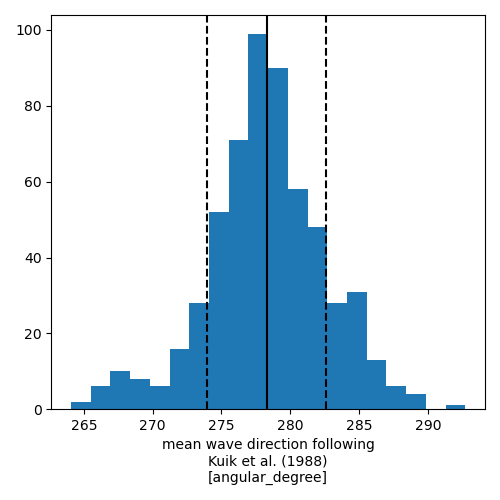

mean(mdir): 278.28
std(mdir): 4.32


In [34]:
fig, ax = plt.subplots(figsize=(5,5))
key = 'mdir'
m = 'C3'
dsds[m][key].plot.hist(ax=ax, bins=20)
ax.axvline(dsds[m][key].mean(), c='k')
ax.axvline(dsds[m][key].mean() + dsds[m][key].std(), c='k', ls='--')
ax.axvline(dsds[m][key].mean() - dsds[m][key].std(), c='k', ls='--')

plt.tight_layout()
plt.show()

print('mean({}): {:.2f}'.format(key, dsds[m][key].mean().item()))
print('std({}): {:.2f}'.format(key, dsds[m][key].std().item()))

Distributions of $u-w$ phase at max. coherence.

In [48]:
# Filename
mids = ['C2', 'C3', 'C5', 'L5']
fn_fig_phase = os.path.join(outdir, 'phase_uw_max_coh.pdf')
if not os.path.isfile(fn_fig_phase):
    # Initialize figure
    fig, ax = plt.subplots(figsize=(5,3.75))
    hists = [] # Empty list to store histograms
    bs = [] # Histogram bins
    cs = [] # Histogram colors
    xs = []

    for mid in mids:
        x = dfv_dict[mid].phase_uw.dropna()
        xs.append(x.values.squeeze())
        # bins = 10
        bins = np.linspace(-180, 5, 38)
        # x.plot.hist(ax=ax, color=clsv[mid], bins=bins, alpha=0.5, density=True)
        h, _ = np.histogram(x.values.squeeze(), bins)
        hists.append(h)
        cs.append(clsv[mid])
    ax.hist(xs, bins, color=cs, density=True, alpha=0.5)

    # Iterate over Vectors and make distributions
    for mid in ['C2', 'C3', 'C5', 'L5']:
        x = dfv_dict[mid].phase_uw.dropna()
        print('mean x {}: {:.2f}'.format(mid, x.mean().item()))
        # Fit PDF
        mu, sigma = stats.norm.fit(x)
        ae, loce, scalee = stats.skewnorm.fit(x)
        # x-axis for pdf
        points = np.linspace(stats.norm.ppf(0.0001,loc=mu,scale=sigma),
                             stats.norm.ppf(0.9999,loc=mu,scale=sigma),
                             100)
        # pdf = stats.norm.pdf(points,loc=mu,scale=sigma)
        pdf = stats.skewnorm.pdf(points, ae, loce, scalee)#.rvs(100)
        # Plot PDF
        ax.plot(points, pdf, color=clsv[mid], label=vec_mids[mid])

    # Labels, legend, etc.
    csfont = {'fontname':'FreeSerif'}
    ax.set_xlabel(r'$\phi(u,w)$ at $\mathrm{coh}(u,w)_\mathrm{max}$ [deg]',)# **csfont)
    ax.set_ylabel('pdf')#, **csfont)
    ax.legend(ncols=1, loc='upper right')
    ax.grid(lw=0.5, alpha=0.5)

    plt.tight_layout()
    plt.savefig(fn_fig_phase, bbox_inches='tight', dpi=600)
    # plt.show()
    plt.close()

mean x C2: -103.39
mean x C3: -47.06
mean x C5: -122.56
mean x L5: -88.55


Distributions of $u-p$ phase at max. coherence.


mean x C2: 3.63
mean x C3: 2.03
mean x C5: -4.40
mean x L5: -2.63


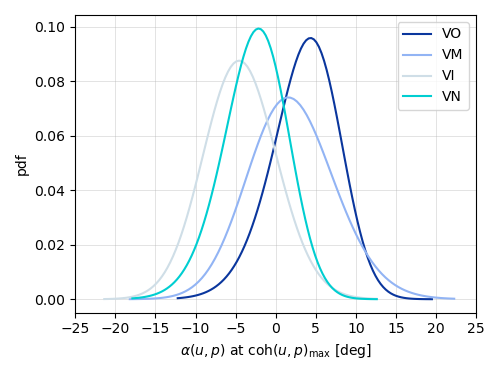

In [4]:
# Filename
mids = ['C2', 'C3', 'C5', 'L5']
fn_fig_phase = os.path.join(outdir, 'phase_up_max_coh.pdf')
# Initialize figure
fig, ax = plt.subplots(figsize=(5,3.75))
hists = [] # Empty list to store histograms
bs = [] # Histogram bins
cs = [] # Histogram colors
xs = []

for mid in mids:
    x = dfv_dict[mid].phase_up.dropna()
    xs.append(x.values.squeeze())
    # bins = 10
    bins = np.linspace(-25, 55, 51)
    # x.plot.hist(ax=ax, color=clsv[mid], bins=bins, alpha=0.5, density=True)
    h, _ = np.histogram(x.values.squeeze(), bins)
    hists.append(h)
    cs.append(clsv[mid])
# ax.hist(xs, bins, color=cs, density=True, alpha=0.25)

# Iterate over Vectors and make distributions
for mid in ['C2', 'C3', 'C5', 'L5']:
    x = dfv_dict[mid].phase_up.dropna()
    print('mean x {}: {:.2f}'.format(mid, x.mean().item()))
    # Fit PDF
    mu, sigma = stats.norm.fit(x)
    ae, loce, scalee = stats.skewnorm.fit(x)
    # x-axis for pdf
    points = np.linspace(stats.norm.ppf(0.0001,loc=mu,scale=sigma),
                            stats.norm.ppf(0.9999,loc=mu,scale=sigma),
                            100)
    # pdf = stats.norm.pdf(points,loc=mu,scale=sigma)
    pdf = stats.skewnorm.pdf(points, ae, loce, scalee)#.rvs(100)
    # Plot PDF
    ax.plot(points, pdf, color=clsv[mid], label=vec_mids[mid])

# Labels, legend, etc.
csfont = {'fontname':'FreeSerif'}
ax.set_xlabel(r'$\alpha(u,p)$ at $\mathrm{coh}(u,p)_\mathrm{max}$ [deg]',)# **csfont)
ax.set_ylabel('pdf')#, **csfont)
ax.set_xlim([-25, 25])
ax.set_xticks(np.linspace(-25, 25, 11))
ax.legend(ncols=1, loc='upper right')
ax.grid(lw=0.5, alpha=0.5)

plt.tight_layout()
if not os.path.isfile(fn_fig_phase):
    plt.savefig(fn_fig_phase, bbox_inches='tight', dpi=600)
    plt.close()
else:
    plt.show()

ValueError: x and y must be the same size

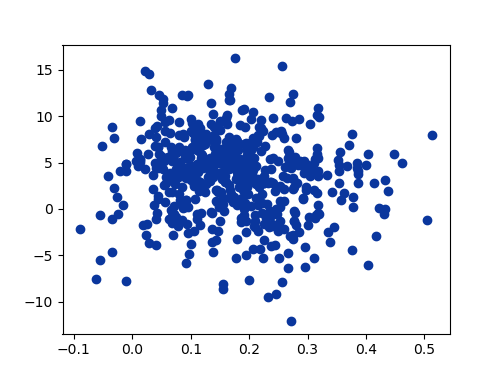

In [12]:
fig, ax = plt.subplots(figsize=(5,3.75))
# Iterate over Vectors and make distributions
for mid in ['C2', 'C3', 'C5', 'L5']:
    x = dfv_dict['C2'].skew_ucs.dropna()
    y = dfv_dict[mid].phase_up.dropna()
    # Plot Hs vs phase
    ax.scatter(x, y, color=clsv[mid], label=vec_mids[mid])

# Labels, legend, etc.
ax.legend(ncols=1, loc='upper right')
ax.grid(lw=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

Sample bispectra of Signature surface elevation (AST) and Vector cross-shore velocity.

In [22]:
# Plot bispectra for Sig surface elevation and Vec u for sample period
t0b = pd.Timestamp('2022-07-13 04:00:00') # Sample period start
t1b = t0b + pd.Timedelta(hours=1) # Sample period end
# Annotation list
ann = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)']
# Parameters for Gaussian filter
sigma = 2
winsz = 5
truncate = (((winsz - 1)/2)-0.5)/sigma
print('sigma={:.2f}, truncate={:.2f}'.format(sigma, truncate))
# Define outdir
outdir_bisp = os.path.join(outdir, 'bispec')
if not os.path.isdir(outdir_bisp):
    os.mkdir(outdir_bisp)
# Figure fn
fn_bispec = os.path.join(outdir_bisp, 'bisp_{}_v5.png'.format(
    t0b.strftime('%Y%m%d_%H%M')))

# Initialize figure
fig, axes = plt.subplots(figsize=(7.5,4.5), ncols=3, nrows=2, sharex=True, sharey='row',
                         constrained_layout=True)
vmin = -3
vmax = 3
# for mid, ser in zip(['L1', 'L5'], ['6338', '6308']):
# for mid, ser in zip(['C5', 'L5'], ['17372', '6308']):
levels = np.linspace(-3, 0.5, 15) # For bispectrum colormap
bounds = np.linspace(-3, 0.5, 15)
# Dict for saving .mat file
mat_sig = {}
# Signature surface elevation
for i, (mid,ser) in enumerate(zip(['C1', 'C3', 'C6'], ['103088', '103094', '103110'])):
    # Read Signature velocity dataset
    sigdir = os.path.join(sig_root, '{}'.format(ser))
    fn_sig = os.path.join(sigdir, 'Asilomar_SSA_L1_Sig_Vel_{}_{}.nc'.format(
        mid, str(t0b.date().strftime('%Y%m%d'))))
    dss = xr.open_dataset(fn_sig, decode_coords='all')
    # Take out burst segment
    segs = dss.sel(time=slice(t0b, t1b)).copy()
    depth = dss.z_hyd.mean().item()
    # Save eta time series and depth to mat dict
    mat_sig[mid] = segs.ASTd_eta.values
    mat_sig[f'd{mid}'] = depth
    # Wave spectrum
    dsws = rpws.spec_uvz(z=segs.ASTd_eta.values, fs=4)
    # Plot wave spec on first row
#     dsws.Ezz.plot(ax=axes[0,i], color=clss[mid], 
#                   label=r'{}: $\zeta$-spec'.format(sig_mids[mid]))
#     axes[0,i].set_xlim([0, 0.4])
#     axes[0,i].set_xlabel(None)
#     axes[0,i].set_ylabel(None)
#     axes[0,i].annotate(ann[i], color='k',
#                         xy=(0.05, 0.85), xycoords='axes fraction',
#                         fontsize=14)

    # Incoming peak freq
    fp = (1 / dsws.Tp_Y95).item()
    # Bispectrum
    dsbss, dbcs = rpws.bispectrum(segs.ASTd_eta.values, fs=4, fmerge=3, wsec=128,
                                    return_bicoh=True, return_krms=False)
    # Apply Gaussian filter
    # bg = gaussian_filter(np.real(dsbss.B), sigma=1, truncate=3)
    b = np.real(dbcs.B.values)
    bg = gaussian_filter(b, sigma=sigma, truncate=truncate)
    print('min: {:.6f}'.format(min(np.real(bg.ravel()))))
    print('max: {:.6f}'.format(max(np.real(bg.ravel()))))
    # cs1 = axes[1,i].pcolormesh(dsbs.freq1, dsbs.freq2, np.real(dsbs.B),
    # cs1 = axes[1,i].contourf(dsbss.freq1, dsbss.freq2, bg,
    cs1 = axes[0,i].pcolormesh(dbcs.freq1, dbcs.freq2, bg,
                             # cmap='bwr',
                             cmap='RdBu_r',
                             # levels=np.linspace(-0.00072, 0.00072, 16),
                             norm=colors.SymLogNorm(linthresh=1e-5, linscale=1e-5,
                                                    vmin=-0.001, vmax=0.001, base=10),
                             # vmin=-0.001, vmax=0.001,
                             # levels=np.linspace(-0.006, 0.006, 26),
                             # levels=np.linspace(0, 1, 21),
                             # levels=np.linspace(0., 0.15, 10),
                             # cmap=terrain_map, rasterized=True, #vmin=vmin, vmax=vmax,
                             # cmap='seismic', vmin=vmin, vmax=vmax, levels=levels)
                             )
    axes[0,i].set_xlim([0, 0.4])
    axes[0,i].set_ylim([0, 0.4])
    if i in [2,5]:
        axes[0,i].annotate(sig_mids[mid], 
                           xy=(0.85, 0.85), xycoords='axes fraction',
                           fontsize=12)
    else:
        axes[0,i].annotate(sig_mids[mid], 
                           xy=(0.82, 0.85), xycoords='axes fraction',
                           fontsize=12)
    axes[0,i].annotate(ann[i], color='k',
                       xy=(0.05, 0.85), xycoords='axes fraction',
                       fontsize=14)


#     # Save Signature .mat file
#     matdir = os.path.join(outdir, 'mat')
#     if not os.path.isdir(matdir):
#         os.mkdir(matdir)
#     fn_mat_sig = os.path.join(matdir, 'sig_eta_{}.mat'.format(t0b.strftime('%Y%m%d_%H%M')))
#     savemat(fn_mat_sig, mat_sig)

# Dict for saving .mat file of Vector data
mat_vec = {}
# Vector ucs
for i, (mid,ser) in enumerate(zip(['C2', 'C3', 'C5'], ['17212', '17219', '17372'])):
    # Read Vector netcdf file
    ncdir = os.path.join(vec_root, mid)
    fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
        str(t0b.date().strftime('%Y%m%d'))))
    dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
    # Select sample period
    seg = dsv.sel(time=slice(t0b, t1b))
    # Check for fraction of spikes in Vector burst
    spikes_frac_x = np.sum(~np.isclose(seg.ux, seg.uxd)) / len(seg.uz)
    spikes_frac_y = np.sum(~np.isclose(seg.uy, seg.uyd)) / len(seg.uz)
    spikes_frac_z = np.sum(~np.isclose(seg.uz, seg.uzd)) / len(seg.uz)
    # Max fraction of spikes = 0.2
    if spikes_frac_x>0.2 or spikes_frac_y>0.2 or spikes_frac_z>0.2:
        continue
    # Check if burst should be skipped due to manual inspection
    if t0b in vec_skip[mid]:
        continue
    # Get sea-surface elevation (K_rms transform)
    eta = seg.eta_lin_krms.copy().to_series() # Surface elevation
    depth = seg.z_hyd.mean().item() # water depth
    # Convert velocities to cross-/alongshore
    if mid in ['L1', 'L5']:
        # x vel, despiked
        uxd = seg.uxd.to_dataframe() # Convert to pandas
        uxd = uxd.interpolate(method='bfill').interpolate('ffill')
        uxm = uxd.mean().item()
        uxd -= uxm # Remove mean
        # uxd -= uxm
        # y vel, despiked
        uyd = seg.uyd.to_dataframe() # Convert to pandas
        uyd = uyd.interpolate(method='bfill').interpolate('ffill')
        uym = uyd.mean().item()
        uyd -= uym # Remove mean
        # uyd -= uym
        # z vel, despiked
        uzd = seg.uzd.to_dataframe() # Convert to pandas
        uzd = uzd.interpolate(method='bfill').interpolate('ffill')
        uzm = uzd.mean().item()
        uzd -= uzm # Remove mean
        # uzd -= uzd.mean()
        # Rotate velocities to cross/alongshore & vertical using PCA
        ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                            uy=uyd.values.squeeze(), 
                                            uz=uzd.values.squeeze(),
                                            # print_msg=True,
                                            )
        # Check that ucs is in the right (shoreward) direction by computing 
        # mean wave direction from directional wave spectrum
        dssu = rpws.spec_uvz(z=eta.values, u=ucs, v=uls, fs=16, fmerge=5)
        # If mdir close to 90 deg -> flip velocities
        if abs(dssu.mdir.item() - 270) > 90:
            ucs *= (-1)
            uls *= (-1)
            uw *= (-1)
    else:
        # Convert E,N velocities to local cross- & alongshore 
        uE = seg.uE.to_dataframe() # Convert to pandas
        uE = uE.interpolate(method='bfill').interpolate('ffill')
        uE -= uE.mean() # Remove mean
        uN = seg.uN.to_dataframe() # Convert to pandas
        uN = uN.interpolate(method='bfill').interpolate('ffill')
        uN -= uN.mean() # Remove mean
        uU = seg.uU.to_dataframe() # Convert to pandas
        uU = uU.interpolate(method='bfill').interpolate('ffill')
        dss_seg = rpws.spec_uvz(z=eta.values, 
                                u=uE.values.squeeze(), 
                                v=uN.values.squeeze(), 
                                fs=16,
                                fmerge=5,
                                )
        # Convert to cross-alongshore based on mean wave direction
        angle_met = dss_seg.mdir.item() # Cross-shore angle
        angle_math = 270 - angle_met # Math angle to rotate
        if angle_math < 0:
            angle_math += 360
        angle_math = np.deg2rad(angle_math) # Radians
        # Rotate East and North velocities to cross-shore (cs) and 
        # long-shore (ls)
        ucs, uls = rpct.rotate_vel(uE.values.squeeze(), 
                                uN.values.squeeze(), 
                                angle_math,
                                )
        uw = uU.values.squeeze() # Vertical vel.
    # Save ucs time series to mat dict
    mat_vec[mid] = ucs
    mat_vec[f'd{mid}'] = depth
    fsa = [] # Empty list for averaging downsampled frequency spectra
    bsa = [] # Empty list for averaging downsampled bispectra
    # Spectrum & Bispectrum, downsample to 4Hz and average
    for di in range(4):
        # ucs freq. spectrum
        dsus = rpws.spec_uvz(z=ucs[di::4], fs=4, fmerge=3, wsec=256)
        # Append spectrum to list for averaging
        fsa.append(dsus.Ezz.values)
        # Bispec.
        dsbsv, dbcv = rpws.bispectrum(ucs[di::4], fs=4, fmerge=3, wsec=128,
                                      return_bicoh=True, return_krms=False)
        # Apply Gaussian filter
        bs = np.real(dbcv.B.values) # array format
        # Append to list for avging
        bsa.append(bs)
    # Average spec & bispec. arrays
    fspec = np.array(fsa).mean(axis=0)
    bs = np.array(bsa).mean(axis=0)
    # Filter
    bg = gaussian_filter(bs, sigma=sigma, truncate=truncate)
    # Add filtered arrays to datasets
    dsus['spec_avg'] = (['freq'], fspec)
    # Plot ucs spec on first row
#     dsus.spec_avg.plot(ax=axes[0,i], color=clsv[mid], 
#                         label=r'{}:  $u$-spec'.format(vec_mids[mid]))
#     axes[0,i].set_xlabel(None)
#     axes[0,i].set_ylabel(None)
    # Average bispectra and add to dataset
    dbcv['bs_filt'] = (['freq1', 'freq2'], bg)
    print('min bisp (vec): {:.6f}'.format(
        dbcv.bs_filt.sel(freq1=slice(0,0.4), freq2=slice(0,0.4)).min().item()))
    print('max bisp (vec): {:.6f}'.format(
        dbcv.bs_filt.sel(freq1=slice(0,0.4), freq2=slice(0,0.4)).max().item()))
    # dsbs.B.plot.pcolormesh(ax=axes[i], x='freq1', y='freq2')
    # cs2 = axes[2,i].pcolormesh(dsbs.freq1, dsbs.freq2, np.real(dsbs.B),
    # cs2 = axes[2,i].contourf(dsbsv.freq1, dsbsv.freq2, bg,
    cs2 = axes[1,i].pcolormesh(dbcv.freq1, dbcv.freq2, bg,
                               cmap='RdBu_r',
                               norm=colors.SymLogNorm(linthresh=1e-5, linscale=1e-5,
                                                      vmin=-0.001, vmax=0.001, base=10),
                               # vmin=-0.001, vmax=0.001,
                               # levels=np.linspace(-0.006, 0.006, 26),
                               # norm=divnorm, cmap=terrain_map, rasterized=True, 
                               #levels=levels, norm=colors.TwoSlopeNorm(1))
                               )
    axes[1,i].set_xlim([0, 0.4])
    axes[1,i].set_ylim([0, 0.4])
    # Annotate mooring ID
    axes[1,i].annotate(ann[3+i], color='k',
                       xy=(0.05, 0.85), xycoords='axes fraction',
                       fontsize=14)
    if i in [2,5]:
        axes[1,i].annotate(vec_mids[mid], 
                           xy=(0.85, 0.85), xycoords='axes fraction',
                           fontsize=12)
    else:
        axes[1,i].annotate(vec_mids[mid], 
                           xy=(0.82, 0.85), xycoords='axes fraction',
                           fontsize=12)

axes[0,0].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
axes[1,0].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
axes[1,0].set_xticks([0, 0.1, 0.2, 0.3, 0.4])
axes[1,1].set_xticks([0, 0.1, 0.2, 0.3, 0.4])
axes[1,2].set_xticks([0, 0.1, 0.2, 0.3, 0.4])
axes[1,0].set_xlabel('Frequency [Hz]')
axes[1,1].set_xlabel('Frequency [Hz]')
axes[1,2].set_xlabel('Frequency [Hz]')
# axes[0,0].set_ylabel(r'$E(f)$ $[\mathrm{m}^2 / Hz]$')
axes[0,0].set_ylabel('Frequency [Hz]')
axes[1,0].set_ylabel('Frequency [Hz]')
# axes[0].legend(ncols=2)
# axes[1].legend(ncols=2)
cax1 = axes[0,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb1 = fig.colorbar(cs1, ax=axes[0,-1], cax=cax1, 
                   label=r'$\mathrm{Re}\{B(f_1,f_2)\}$ $[\mathrm{m}^3]$',
                   ticks=[-1e-3, -1e-4, 0, 1e-4, 1e-3],
                   )
cax2 = axes[1,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb2 = fig.colorbar(cs2, ax=axes[1,-1], cax=cax2, 
                   label=r'$\mathrm{Re}\{B(f_1,f_2)\}$ $[\mathrm{m}^3 \mathrm{s}^{-3}]$',
                   ticks=[-1e-3, -1e-4, 0, 1e-4, 1e-3],
                   )

# for ax in axes[0,:]:
#     ax.legend(loc='upper right', fontsize=9)

# plt.show()
if not os.path.isfile(fn_bispec):
    plt.savefig(fn_bispec, bbox_inches='tight', dpi=600)
plt.close()

#     # Save Vector mat file
#     fn_mat_vec = os.path.join(matdir, 'vec_ucs_{}.mat'.format(t0b.strftime('%Y%m%d_%H%M')))
#     savemat(fn_mat_vec, mat_vec)

print('Done.')


sigma=2.00, truncate=0.75
min: -0.000120
max: 0.000679
min: -0.000116
max: 0.000721
min: -0.000088
max: 0.000607


/tmp/ipykernel_4111/3352340594.py:164: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/3352340594.py:164: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/3352340594.py:167: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/3352340594.py:167: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/33523405

min bisp (vec): -0.000177
max bisp (vec): 0.001304


/tmp/ipykernel_4111/3352340594.py:164: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/3352340594.py:164: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/3352340594.py:167: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/3352340594.py:167: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/33523405

min bisp (vec): -0.000237
max bisp (vec): 0.001164


/tmp/ipykernel_4111/3352340594.py:164: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/3352340594.py:164: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/3352340594.py:167: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/3352340594.py:167: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/33523405

min bisp (vec): -0.000223
max bisp (vec): 0.000576
Done.


Bicoherence for same sample period.

sigma=2.00, truncate=0.75
fp: 0.09, fp1: 0.12, fp2: 0.09


/tmp/ipykernel_4111/1552686189.py:62: DeprecationWarning: spec.partition will become a namespace in **4.0.0**, use spec.partion.ptm1() instead for equivalent functionality.
  dspart = ws.spec.partition(wsda, wdda, dda, swells=2)


min bicoh: 0.0044
max bicoh: 0.3684
min bicoh: 0.0027
max bicoh: 0.3868
min bicoh: 0.0063
max bicoh: 0.3941


/tmp/ipykernel_4111/1552686189.py:179: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/1552686189.py:179: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/1552686189.py:182: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/1552686189.py:182: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/15526861

min bicoh: 0.0028
max bicoh: 0.3848
Bicoh(fp2, fp1-fp2): 0.118


/tmp/ipykernel_4111/1552686189.py:179: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/1552686189.py:179: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/1552686189.py:182: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/1552686189.py:182: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/15526861

min bicoh: 0.0000
max bicoh: 0.3410
Bicoh(fp2, fp1-fp2): 0.121


/tmp/ipykernel_4111/1552686189.py:179: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/1552686189.py:179: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/1552686189.py:182: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/1552686189.py:182: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uN = uN.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_4111/15526861

min bicoh: 0.0128
max bicoh: 0.3255
Bicoh(fp2, fp1-fp2): 0.123


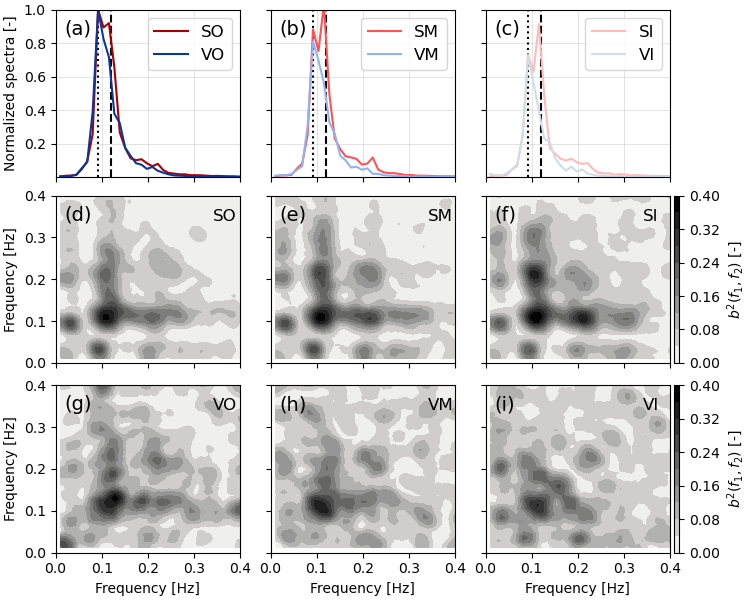

Done.


In [26]:
import wavespectra
# Plot bicoherence for Sig surface elevation and Vec u for sample period
t0b = pd.Timestamp('2022-07-13 04:00:00') # Sample period start
t1b = t0b + pd.Timedelta(hours=1) # Sample period end
# t1b = t0b + pd.Timedelta(minutes=20) # Sample period end
# Parameters for Gaussian filter
sigma = 2
winsz = 5
truncate = (((winsz - 1)/2)-0.5)/sigma
print('sigma={:.2f}, truncate={:.2f}'.format(sigma, truncate))
# Define outdir
outdir_bisp = os.path.join(outdir, 'bispec')
if not os.path.isdir(outdir_bisp):
    os.mkdir(outdir_bisp)
# Figure fn
fn_bicoh = os.path.join(outdir_bisp, 'bicoh_{}_v5.png'.format(
    t0b.strftime('%Y%m%d_%H%M')))
# Initialize figure
fig, axes = plt.subplots(figsize=(7.5,6), ncols=3, nrows=3, sharex=True, sharey='row',
                        constrained_layout=True)
vmin = 0
vmax = 1
# for mid, ser in zip(['L1', 'L5'], ['6338', '6308']):
# for mid, ser in zip(['C5', 'L5'], ['17372', '6308']):
levels = np.linspace(-3, 0.5, 15) # For bispectrum colormap
bounds = np.linspace(-3, 0.5, 15)
# Annotation list
ann = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)']
# Dict for saving .mat file
mat_sig = {}
# Signature surface elevation
for i, (mid,ser) in enumerate(zip(['C1', 'C3', 'C6'], ['103088', '103094', '103110'])):
    # Read Signature velocity dataset
    sigdir = os.path.join(sig_root, '{}'.format(ser))
    fn_sig = os.path.join(sigdir, 'Asilomar_SSA_L1_Sig_Vel_{}_{}.nc'.format(
        mid, str(t0b.date().strftime('%Y%m%d'))))
    dss = xr.open_dataset(fn_sig, decode_coords='all')
    # Take out burst segment
    segs = dss.sel(time=slice(t0b, t1b)).copy()
    depth = dss.z_hyd.mean().item()
    # Wave spectrum
    # dsws = rpws.spec_uvz(z=segs.ASTd_eta.values, fs=4)
    dsws = dsds[mid].sel(time=t0b)
    fp = dsws.fp.item()
    # Normalize by offshore max. energy level
    if i==0:
        energy_max = dsws.Ezz.max().item()
        # Partition directional spectrum based on Hanson et al. (2008)
        # as implemented in wavespectra library
        efth = dsws.Efth.to_dataset() # Dir. spec dataset
        efth = efth.rename_dims({'direction':'dir'}) # Rename to wavespectra conventions
        efth = efth.drop_vars(['direction', 'time']) # No time var in wavespectra
        efth = efth.rename_vars({'Efth':'efth'}) # Rename to wavespectra conventions
        efth['site'] = ([], 'Asilomar') # Need site variable in wavespectra
        # Make wavespectra object
        ws = wavespectra.read_dataset(efth)
        # Input wind speed, direction and depth as DataArrays
        wsda = xr.DataArray(dfw['windspeed_4m'].loc[t0b])
        wdda = xr.DataArray(dfw['winddir'].loc[t0b])
        dda = xr.DataArray(depth)
        # Partition spectrum
        dspart = ws.spec.partition(wsda, wdda, dda, swells=2)
        # fp 1 & 2 from partition
        fp1 = 1 / dspart.spec.stats(["tp"]).tp.sel(part=1).values
        fp2 = 1 / dspart.spec.stats(["tp"]).tp.sel(part=2).values
        print(f'fp: {fp:.2f}, fp1: {fp1:.2f}, fp2: {fp2:.2f}')
    # Mark fp1 & fp2 on spec
    axes[0,i].axvline(x=fp1, color='k', ls='--')
    axes[0,i].axvline(x=fp2, color='k', ls=':')
    # Plot normalized wave spec on first row
    ezz_norm = dsws.Ezz / energy_max
    ezz_norm.plot(ax=axes[0,i], color=clss[mid], 
                  label=r'{}'.format(sig_mids[mid])
                  )
    axes[0,i].set_xlim([0, 0.4])
    axes[0,i].set_ylim([1e-3, 1])
    axes[0,i].set_xlabel(None)
    axes[0,i].set_ylabel(None)
    # axes[0,i].set_yscale('log')
    axes[0,i].annotate(ann[i], color='k',
                       xy=(0.05, 0.85), xycoords='axes fraction',
                       fontsize=14)
    # Save eta time series and depth to mat dict
    mat_sig[mid] = segs.ASTd_eta.values
    mat_sig[f'd{mid}'] = depth
    # Bicoherence
    _, dbcs = rpws.bispectrum(-segs.ASTd_eta.values, fs=4, fmerge=3, wsec=128,
                                return_bicoh=True, return_krms=False)
    # Apply Gaussian filter
    bc = dbcs.Bc.values
    bc[bc < dbcs.b99.item()] = 0 # Set to zero values < 99% confidence int.
    bg = gaussian_filter(bc**2, sigma=sigma, truncate=truncate) # Filter bicoherence
    # Add filtered array to dataset
    dbcs['bg'] = (['freq1', 'freq2'], bg)
    print('min bicoh: {:.4f}'.format(
        dbcs.bg.sel(freq1=slice(0,0.4), freq2=slice(0,0.4)).min().item()))
    print('max bicoh: {:.4f}'.format(
        dbcs.bg.sel(freq1=slice(0,0.4), freq2=slice(0,0.4)).max().item()))
    cs1 = axes[1,i].contourf(dbcs.freq1, dbcs.freq2, bg,
                                cmap=cmocean.cm.gray_r,
                                # vmin=-0.001, vmax=0.001,
                                # levels=np.linspace(-0.006, 0.006, 26),
                                # levels=np.linspace(0, 1, 21),
                                levels=np.linspace(0., 0.4, 11),
                                # cmap=terrain_map, rasterized=True, #vmin=vmin, vmax=vmax,
                                # cmap='seismic', vmin=vmin, vmax=vmax, levels=levels)
                                )
    # axes[1,i].scatter(fp1-fp2, fp2, color='r')
    axes[1,i].set_xlim([0, 0.4])
    axes[1,i].set_ylim([0, 0.4])
    # Annotate mooring ID and (a), (b), ...
    axes[1,i].annotate(sig_mids[mid], 
                       xy=(0.85, 0.85), xycoords='axes fraction',
                       fontsize=12)
    axes[1,i].annotate(ann[i+3], 
                        xy=(0.05, 0.85), xycoords='axes fraction',
                        fontsize=14)


# Vector ucs-bicoherence
for i, (mid,ser) in enumerate(zip(['C2', 'C3', 'C5'], ['17212', '17219', '17372'])):
    # Read Vector netcdf file
    ncdir = os.path.join(vec_root, mid)
    fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
        str(t0b.date().strftime('%Y%m%d'))))
    dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
    # Select sample period
    seg = dsv.sel(time=slice(t0b, t1b))
    # Check for fraction of spikes in Vector burst
    spikes_frac_x = np.sum(~np.isclose(seg.ux, seg.uxd)) / len(seg.uz)
    spikes_frac_y = np.sum(~np.isclose(seg.uy, seg.uyd)) / len(seg.uz)
    spikes_frac_z = np.sum(~np.isclose(seg.uz, seg.uzd)) / len(seg.uz)
    # Max fraction of spikes = 0.2
    if spikes_frac_x>0.2 or spikes_frac_y>0.2 or spikes_frac_z>0.2:
        continue
    # Check if burst should be skipped due to manual inspection
    if t0b in vec_skip[mid]:
        continue
    # Get sea-surface elevation (K_rms transform)
    eta = seg.eta_lin_krms.copy().to_series() # Surface elevation
    depth = seg.z_hyd.mean().item() # water depth
    # Convert velocities to cross-/alongshore
    if mid in ['L1', 'L5']:
        # x vel, despiked
        uxd = seg.uxd.to_dataframe() # Convert to pandas
        uxd = uxd.interpolate(method='bfill').interpolate('ffill')
        uxm = uxd.mean().item()
        uxd -= uxm # Remove mean
        # uxd -= uxm
        # y vel, despiked
        uyd = seg.uyd.to_dataframe() # Convert to pandas
        uyd = uyd.interpolate(method='bfill').interpolate('ffill')
        uym = uyd.mean().item()
        uyd -= uym # Remove mean
        # uyd -= uym
        # z vel, despiked
        uzd = seg.uzd.to_dataframe() # Convert to pandas
        uzd = uzd.interpolate(method='bfill').interpolate('ffill')
        uzm = uzd.mean().item()
        uzd -= uzm # Remove mean
        # uzd -= uzd.mean()
        # Rotate velocities to cross/alongshore & vertical using PCA
        ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                           uy=uyd.values.squeeze(), 
                                           uz=uzd.values.squeeze(),
                                           # print_msg=True,
                                           )
        # Check that ucs is in the right (shoreward) direction by computing 
        # mean wave direction from directional wave spectrum
        dssu = rpws.spec_uvz(z=eta.values, u=ucs, v=uls, fs=16, fmerge=5)
        # If mdir close to 90 deg -> flip velocities
        if abs(dssu.mdir.item() - 270) > 90:
            ucs *= (-1)
            uls *= (-1)
            uw *= (-1)
    else:
        # Convert E,N velocities to local cross- & alongshore 
        uE = seg.uE.to_dataframe() # Convert to pandas
        uE = uE.interpolate(method='bfill').interpolate('ffill')
        uE -= uE.mean() # Remove mean
        uN = seg.uN.to_dataframe() # Convert to pandas
        uN = uN.interpolate(method='bfill').interpolate('ffill')
        uN -= uN.mean() # Remove mean
        uU = seg.uU.to_dataframe() # Convert to pandas
        uU = uU.interpolate(method='bfill').interpolate('ffill')
        dss_seg = rpws.spec_uvz(z=eta.values, 
                                u=uE.values.squeeze(), 
                                v=uN.values.squeeze(), 
                                fs=16,
                                fmerge=5,
                                )
        # Convert to cross-alongshore based on mean wave direction
        angle_met = dss_seg.mdir.item() # Cross-shore angle
        angle_math = 270 - angle_met # Math angle to rotate
        if angle_math < 0:
            angle_math += 360
        angle_math = np.deg2rad(angle_math) # Radians
        # Rotate East and North velocities to cross-shore (cs) and 
        # long-shore (ls)
        ucs, uls = rpct.rotate_vel(uE.values.squeeze(), 
                                   uN.values.squeeze(), 
                                   angle_math,
                                   )
        uw = uU.values.squeeze() # Vertical vel.
    # Bicoherence (downsample to 4Hz and average)
    fsa = [] # Empty list for averaging downsampled frequency spectra
    bca = [] # Empty list for averaging downsampled bicoherence arrays
    for di in range(4):
        # ucs freq. spectrum
        dsus = rpws.spec_uvz(z=ucs[di::4], fs=4, fmerge=3, wsec=256)
        # Append spectrum to list for averaging
        fsa.append(dsus.Ezz.values)
        _, dbcv = rpws.bispectrum(-ucs[di::4], fs=4, fmerge=3, wsec=128,
                                  return_bicoh=True, return_krms=False)
        # Apply Gaussian filter
        bc = dbcv.Bc.values # array format
        bc[bc < dbcv.b99.item()] = 0 # Set to 0 values < 99% significance
        # Append to list for avging
        bca.append(bc)
    # Average spec. and bicoh. arrays
    fspec = np.array(fsa).mean(axis=0)
    # Add spec array to datasets
    dsus['spec_avg'] = (['freq'], fspec)
    # Normalize plotted spectra by offshore maximum
    if i==0:
        energy_max = dsus.spec_avg.max().item()
    # Plot normalized ucs spec on first row
    (dsus.spec_avg / energy_max).plot(ax=axes[0,i], color=clsv[mid], 
                                      label=r'{}'.format(vec_mids[mid])
                                      )
    axes[0,i].set_xlabel(None)
    axes[0,i].set_ylabel(None)
    # Average bicoherence
    bc = np.array(bca).mean(axis=0)
    # Filter
    bg = gaussian_filter(bc**2, sigma=sigma, truncate=truncate)
    # Add filtered array to dataset
    dbcv['bg'] = (['freq1', 'freq2'], bg)
    print('min bicoh: {:.4f}'.format(
        dbcv.bg.sel(freq1=slice(0,0.4), freq2=slice(0,0.4)).min().item()))
    print('max bicoh: {:.4f}'.format(
        dbcv.bg.sel(freq1=slice(0,0.4), freq2=slice(0,0.4)).max().item()))
    # Plot
    cs2 = axes[2,i].contourf(dbcv.freq1, dbcv.freq2, bg,
                             cmap=cmocean.cm.gray_r, 
                             # vmin=-0.001, vmax=0.001,
                             # levels=np.linspace(-0.006, 0.006, 26),
                             levels=np.linspace(0., 0.4, 11),
                             # norm=divnorm, cmap=terrain_map, rasterized=True, 
                             #levels=levels, norm=colors.TwoSlopeNorm(1))
                             )
    # axes[2,i].scatter(fp2, (fp1-fp2), color='r')
    # axes[2,i].scatter(fp1, (fp1-fp2), color='b')
    print('Bicoh(fp2, fp1-fp2): {:.3f}'.format(dbcv.bg.sel(freq1=slice(fp2-0.1, fp2+0.1), freq2=slice(fp1-fp2-0.1, fp1-fp2+0.1)).mean().item()))
    axes[2,i].set_xlim([0, 0.4])
    axes[2,i].set_ylim([0, 0.4])
    # Annotate mooring ID and (a), (b), ...
    axes[2,i].annotate(vec_mids[mid], color='k',
                       xy=(0.85, 0.85), xycoords='axes fraction',
                       fontsize=12)
    axes[2,i].annotate(ann[6+i], color='k',
                       xy=(0.05, 0.85), xycoords='axes fraction',
                       fontsize=14)


axes[1,0].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
axes[2,0].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
axes[2,0].set_xticks([0, 0.1, 0.2, 0.3, 0.4])
axes[2,1].set_xticks([0, 0.1, 0.2, 0.3, 0.4])
axes[2,2].set_xticks([0, 0.1, 0.2, 0.3, 0.4])
axes[2,0].set_xlabel('Frequency [Hz]')
axes[2,1].set_xlabel('Frequency [Hz]')
axes[2,2].set_xlabel('Frequency [Hz]')
axes[0,0].set_ylabel('Normalized spectra [-]')
axes[1,0].set_ylabel('Frequency [Hz]')
axes[2,0].set_ylabel('Frequency [Hz]')
# axes[0].legend(ncols=2)
# axes[1].legend(ncols=2)
cax1 = axes[1,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb1 = fig.colorbar(cs1, ax=axes[1,-1], cax=cax1, 
                   label=r'$b^2(f_1,f_2)$ [-]',
                   )
cax2 = axes[2,-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb2 = fig.colorbar(cs2, ax=axes[2,-1], cax=cax2, 
                   label=r'$b^2(f_1,f_2)$ [-]',
                   # ticks=[],
                   )
# Legend + grid for spectra
for ax in axes[0,:]:
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(lw=0.5, alpha=0.5)
if not os.path.isfile(fn_bicoh):
    plt.savefig(fn_bicoh, bbox_inches='tight', dpi=600)
    plt.close()
else:
    plt.show()
    # plt.close()

print('Done.')


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/wave_spectra.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  krms[fi] = 2 * np.pi * f[fi] / np.sqrt(g*h0) # Linear part
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/wave_spectra.py:140: RuntimeWarning: divide by zero encountered in double_scalars
  Beta_am  = 3 * sumtmp / (2 * h0 * P[fi])
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/wave_spectra.py:143: RuntimeWarning: invalid value encountered in sqrt
  krms[fi] *= np.sqrt(1 + Beta_fr - Beta_am)


min bicoh: 0.0097
max bicoh: 0.3082
min bicoh: 0.0220
max bicoh: 0.1000


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/wave_spectra.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  krms[fi] = 2 * np.pi * f[fi] / np.sqrt(g*h0) # Linear part
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/wave_spectra.py:140: RuntimeWarning: divide by zero encountered in double_scalars
  Beta_am  = 3 * sumtmp / (2 * h0 * P[fi])
/home/mikapm/Github/pyROXSI/roxsi_pyfuns/wave_spectra.py:143: RuntimeWarning: invalid value encountered in sqrt
  krms[fi] *= np.sqrt(1 + Beta_fr - Beta_am)


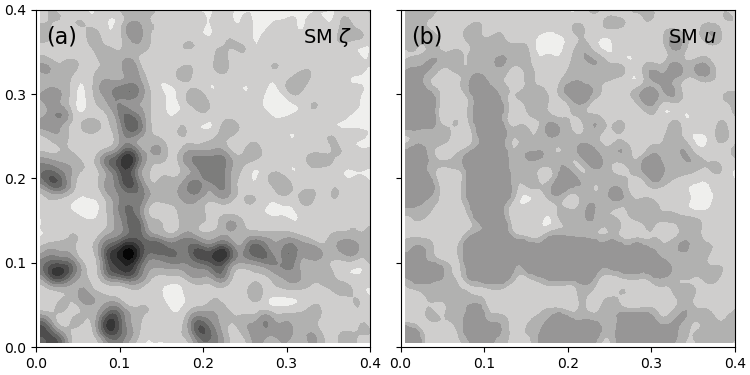

In [31]:
# Plot bicoherence for Sig surface elevation and Vec u for sample period
t0b = pd.Timestamp('2022-07-13 04:00:00') # Sample period start
t1b = t0b + pd.Timedelta(hours=1) # Sample period end
# t1b = t0b + pd.Timedelta(minutes=20) # Sample period end
# Define outdir
outdir_bisp = os.path.join(outdir, 'bispec')
if not os.path.isdir(outdir_bisp):
    os.mkdir(outdir_bisp)
# Figure fn
fn_bicoh_c3 = os.path.join(outdir_bisp, 'bicoh_C3_{}.png'.format(
    t0b.strftime('%Y%m%d_%H%M')))
# Only use C3 Signature
mid = 'C3'
ser = '103094'
if not os.path.isfile(fn_bicoh_c3):
    # Initialize figure
    fig, axes = plt.subplots(figsize=(7.5,3.75), ncols=2, 
                             sharex=True, sharey=True,
                             constrained_layout=True)
    vmin = 0
    vmax = 1
    # for mid, ser in zip(['L1', 'L5'], ['6338', '6308']):
    # for mid, ser in zip(['C5', 'L5'], ['17372', '6308']):
    levels = np.linspace(-3, 0.5, 15) # For bispectrum colormap
    bounds = np.linspace(-3, 0.5, 15)
    # Annotation list
    ann = ['(a)', '(b)']
    # Dict for saving .mat file
    mat_sig = {}
    # Signature surface elevation and cross-shore velocity
    sigdir = os.path.join(sig_root, '{}'.format(ser))
    fn_sig = os.path.join(sigdir, 'Asilomar_SSA_L1_Sig_Vel_{}_{}.nc'.format(
        mid, str(t0b.date().strftime('%Y%m%d'))))
    dss = xr.open_dataset(fn_sig, decode_coords='all')
    # Take out burst segment
    segs = dss.sel(time=slice(t0b, t1b)).copy()
    depth = dss.z_hyd.mean().item()
    # Bicoherence of eta
    _, dbcs = rpws.bispectrum(segs.ASTd_eta.values, fs=4, fmerge=3, wsec=256,
                              return_bicoh=True)
    # Apply Gaussian filter
    bc = dbcs.Bc.values
    bc[bc < dbcs.b99.item()] = 0 # Set to zero values < 99% confidence int.
    bg = gaussian_filter(bc**2, sigma=2, truncate=3) # Filter bicoherence
    # Add filtered array to dataset
    dbcs['bg'] = (['freq1', 'freq2'], bg)
    print('min bicoh: {:.4f}'.format(
        dbcs.bg.sel(freq1=slice(0,0.4), freq2=slice(0,0.4)).min().item()))
    print('max bicoh: {:.4f}'.format(
        dbcs.bg.sel(freq1=slice(0,0.4), freq2=slice(0,0.4)).max().item()))
    cs1 = axes[0].contourf(dbcs.freq1, dbcs.freq2, bg,
                           cmap=cmocean.cm.gray_r,
                           # vmin=-0.001, vmax=0.001,
                           # levels=np.linspace(-0.006, 0.006, 26),
                           # levels=np.linspace(0, 1, 21),
                           levels=np.linspace(0., 0.32, 11),
                           # cmap=terrain_map, rasterized=True, #vmin=vmin, vmax=vmax,
                           # cmap='seismic', vmin=vmin, vmax=vmax, levels=levels)
                           )
    axes[0].set_xlim([0, 0.4])
    axes[0].set_ylim([0, 0.4])
    # Annotate mooring ID and (a), (b), ...
    axes[0].annotate(sig_mids[mid]+r' $\zeta$', xy=(0.8, 0.9), xycoords='axes fraction',
                     fontsize=14)
    axes[0].annotate('(a)', xy=(0.03, 0.9), xycoords='axes fraction',
                     fontsize=16)

    # Bicoherence of ucs
    dss_seg = rpws.spec_uvz(z=segs.ASTd_eta.values, 
                            u=segs.vE.isel(range=0).values.squeeze(), 
                            v=segs.vN.isel(range=0).values.squeeze(), 
                            fs=4,
                            fmerge=3,
                            ) # directional wave spectrum
    # Convert to cross-alongshore based on mean wave direction
    angle_met = dss_seg.mdir.item() # Cross-shore angle
    angle_math = 270 - angle_met # Math angle to rotate
    if angle_math < 0:
        angle_math += 360
    angle_math = np.deg2rad(angle_math) # Radians
    # Rotate East and North velocities to cross-shore (cs) and 
    # long-shore (ls)
    ucs, uls = rpct.rotate_vel(segs.vE.isel(range=0).values.squeeze(), 
                               segs.vN.isel(range=0).values.squeeze(), 
                               angle_math,
                               )
    _, dbcs = rpws.bispectrum(ucs, fs=4, fmerge=3, wsec=256,
                              return_bicoh=True)
    # Apply Gaussian filter
    bc = dbcs.Bc.values
    bc[bc < dbcs.b99.item()] = 0 # Set to zero values < 99% confidence int.
    bg = gaussian_filter(bc**2, sigma=2, truncate=3) # Filter bicoherence
    # For plot, set values over 0.1 to 0.1 (max value 0.1004)
    bg[bg>0.1] = 0.1
    # Add filtered array to dataset
    dbcs['bg'] = (['freq1', 'freq2'], bg)
    print('min bicoh: {:.4f}'.format(
        dbcs.bg.sel(freq1=slice(0,0.4), freq2=slice(0,0.4)).min().item()))
    print('max bicoh: {:.4f}'.format(
        dbcs.bg.sel(freq1=slice(0,0.4), freq2=slice(0,0.4)).max().item()))
    cs1 = axes[1].contourf(dbcs.freq1, dbcs.freq2, bg,
                           cmap=cmocean.cm.gray_r,
                           # vmin=-0.001, vmax=0.001,
                           # levels=np.linspace(-0.006, 0.006, 26),
                           # levels=np.linspace(0, 1, 21),
                           levels=np.linspace(0., 0.32, 11),
                           # cmap=terrain_map, rasterized=True, #vmin=vmin, vmax=vmax,
                           # cmap='seismic', vmin=vmin, vmax=vmax, levels=levels)
                           )
    axes[1].set_xlim([0, 0.4])
    axes[1].set_ylim([0, 0.4])
    # Annotate mooring ID and (a), (b), ...
    axes[1].annotate(sig_mids[mid]+r' $u$', xy=(0.8, 0.9), xycoords='axes fraction',
                     fontsize=14)
    axes[1].annotate('(b)', xy=(0.03, 0.9), xycoords='axes fraction',
                     fontsize=16)

    # Axis ticks
    for ax in axes.flat:
        ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4])
        ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])

    plt.show()

Figure 3: Example methods figure of phase resolved wave heights, orbital velocities and dissipation rate.

In [4]:
# mids = [ 'C5', 'L5']
# sers = ['17372', '6308']
# mids = ['C2', 'C3',  'C5', 'L5']
# sers = ['17212', '17219', '17372', '6308']
mids = ['C2', 'C3']
sers = ['17212', '17219']
fs = 16 # Sampling freq
# Define number of sub-segments per wave cycle (should be even)
ncyc = 8
# Minimum R^2 threshold for inertial subrange fits
r2_thresh = 0.9
# Minimum ratio of eddy timescale over advection timescale
eddy_adv_ratio = 5
# Sample period
t0sp = pd.Timestamp('2022-07-13 04:00:00')
nhs = 1 # Number of hours after t0sp
tsp = pd.date_range(t0sp, t0sp+pd.Timedelta(hours=nhs), freq='1H')
for t0e in tsp:
    nhours = 1 # No. of hours to process at once
    t1e = t0e + pd.Timedelta(hours=nhours)
    spd = 60 * 60 * 24 # Seconds per day
    # Define expected headings in PCA coordinates for C2, C3 & C4
    heading_exp_1 = {'C2': -125, 'C3': -90, 'C4': -90, 'L2': None, 'L1': 160, 'L5':None}
    # After 2022-07-13 04:00 (C4)
    heading_exp_2 = {'C2': -125, 'C3': -90, 'C4': -20, 'L2': None, 'L1': 160, 'L5':None}

    # Lists for hourly burst averages
    wave_int_e = {'{}'.format(m): [] for m in mids} # Interpolated wave elevations
    wave_int_u = {'{}'.format(m): [] for m in mids} # Interpolated wave u velocities
    wave_int_v = {'{}'.format(m): [] for m in mids} # Interpolated wave v velocities
    wave_int_w = {'{}'.format(m): [] for m in mids} # Interpolated wave w velocities
    eps_lt83 = {'{}'.format(m): [] for m in mids}
    # Dataframes for burst-average dissipation and U_rms
    time_range = pd.date_range(t0e, t1e, freq='1H') # Time index
    nt = len(time_range)
    dfbd = {'{}'.format(m): pd.DataFrame(data={'eps_phase': np.ones(nt)*np.nan, 
                                               'eps_phase_std': np.ones(nt)*np.nan,
                                               'eps_LT83': np.ones(nt)*np.nan,
                                               'U_rms': np.ones(nt)*np.nan,
                                               'depth': np.ones(nt)*np.nan,
                                               },
                                         index=time_range) for m in mids
            }
    # Dissipation rates per wave-cycle subsegment
    diss_subseg = {'{}'.format(m): {} for m in mids}
    U_subseg = {'{}'.format(m): {} for m in mids}
    for mid in mids:
        diss_subseg[mid] = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
        U_subseg[mid] = {'{}/{}'.format(n, ncyc): [] for n in range(1,ncyc+1)}
    # Wave-by-wave dissipation rates lists for concatenating dataframes
    dfw_list = {'{}'.format(m): [] for m in mids}

    # Lists for histograms
    udu_ratios = {} # U/dU ratios
    t_ratios = {} # eddy/adv time scale ratios
    for mid in mids:
        udu_ratios[mid] = []
        t_ratios[mid] = []
    # List for timestamps of bursts to skip due to too many spikes
    skip_list = []

    # Define type of fit to use for dissipation rate calculation
    fit = 'linear'
    # Define number of bins to use for advection speed U (1-4)
    nbins = 4
    if nbins == 2:
        # Define U ranges for 2 bins
        ubins = [(0, 0.5), (0.5, 2)]
    elif nbins == 3:
        # Define U ranges for 3 bins
        ubins = [(0, 0.25), (0.25, 0.5), (0.5, 2)]
    elif nbins == 4:
        # Define U ranges for 4 bins
        ubins = [(0, 0.15), (0.15, 0.3), (0.3, 0.45), (0.45, 2)]
    # Colors for U ranges in k-spectrum plots
    csu = ['#FF1053', '#AEF6C7', '#5B8266', '#212922']

    # Main loop to iterate over desired moorings
    for mid, ser in zip(mids, sers):
        # print('{} - {}'.format(mid, ser))
        # k-spec figure filename
        outdir_k = os.path.join(outdir, 'k_spec')
        if not os.path.isdir(outdir_k):
            os.mkdir(outdir_k)
        fn_fig_k = os.path.join(outdir_k, 'kspec_{}_{}_ubins_{}_fit_{}_osm.png'.format(
            mid, t0e.strftime('%Y%m%d_%H%M'), nbins, fit))
        if not os.path.isfile(fn_fig_k):
            # Flag for plotting k-spec
            plot_k = True
            # Initialize figure
            fig, axes = plt.subplots(figsize=(7.5, 7.5), ncols=4, nrows=5, 
                                    constrained_layout=True, 
                                    sharey='row', sharex='col',
                                    )
            # Merge upper two rows
            gs = axes[0,0].get_gridspec()
            for ax in axes[0,:]:
                ax.remove()
            ax0 = fig.add_subplot(gs[0,:])
            # Same for second row
            gs = axes[1,0].get_gridspec()
            for ax in axes[1,:]:
                ax.remove()
            ax1 = fig.add_subplot(gs[1,:])
            # Same for third row
            gs = axes[2,0].get_gridspec()
            for ax in axes[2,:]:
                ax.remove()
            ax2 = fig.add_subplot(gs[2,:])
        else:
            plot_k = False
        # Read netcdf file, check if need to concatenate multiple days
        if ((t1e.date() - t0e.date()).total_seconds() / spd) > 0:
            # More than one day -> concatenate daily datasets
            drc = pd.date_range(t0e.date(), t1e.date(), freq='1D') # Range of dates
            dlc = [] # List for concatenating
            for d in drc:
                ncdir = os.path.join(vec_root, mid)
                fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(
                    ser, str(d.strftime('%Y%m%d'))))
                dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
                # Append to list
                dlc.append(dsv)
            # Concatenate daily datasets
            dsv = xr.concat(dlc, dim='time')
        else:
            # Only one day
            ncdir = os.path.join(vec_root, mid)
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
                str(t0e.strftime('%Y%m%d'))))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
        # Wave counter
        wcnt = 0
        # Iterate over bursts
        for t0b in time_range:
            t1b = t0b + pd.Timedelta(hours=1)
            if t1b > t1e:
                continue
            # print('{}-{}'.format(t0b, t1b))
            # Select sample period
            seg = dsv.sel(time=slice(t0b, t1b))
            # Get sea-surface elevation (K_rms transform)
            eta = seg.eta_lin_krms.copy().to_series() # Surface elevation
            # Convert velocities to cross-/alongshore
            if mid in ['L1', 'L5', 'C1', 'C6']:
                # x vel, despiked
                uxd = seg.uxd.to_dataframe() # Convert to pandas
                uxd = uxd.interpolate(method='bfill').interpolate('ffill')
                uxm = uxd.mean().item()
                uxd -= uxm
                # y vel, despiked
                uyd = seg.uyd.to_dataframe() # Convert to pandas
                uyd = uyd.interpolate(method='bfill').interpolate('ffill')
                uym = uyd.mean().item()
                uyd -= uym
                # z vel, despiked
                uzd = seg.uzd.to_dataframe() # Convert to pandas
                uzd = uzd.interpolate(method='bfill').interpolate('ffill')
                uzd -= uzd.mean()
                # Get correct expected heading for C4
                if t0b <= pd.Timestamp('2022-07-13 04:00'):
                    he = heading_exp_1[mid]
                else:
                    he = heading_exp_2[mid]
                # Rotate velocities to cross/alongshore & vertical using PCA
                ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                                uy=uyd.values.squeeze(), 
                                                uz=uzd.values.squeeze(),
                                                heading_exp=he, 
                                                # print_msg=True,
                                                )
                # Check if mean wave direction is 270
                dssu = rpws.spec_uvz(z=eta.values, u=ucs, v=uls, fs=16, fmerge=5)
                # If mdir close to 90 deg -> flip velocities
                if abs(dssu.mdir.item() - 270) > 90:
                    ucs *= (-1)
                    uls *= (-1)
                    uw *= (-1)
                dssu = rpws.spec_uvz(z=eta.values, u=ucs, v=uls, fs=16, fmerge=5)
                # print('MDIR: {:.2f}'.format(dssu.mdir.item()))
            else:
                # Convert E,N velocities to local cross- & alongshore (x,y) components
                uE = seg.uE.to_dataframe() # Convert to pandas
                uE = uE.interpolate(method='bfill').interpolate('ffill')
                uN = seg.uN.to_dataframe() # Convert to pandas
                uN = uN.interpolate(method='bfill').interpolate('ffill')
                uU = seg.uU.to_dataframe() # Convert to pandas
                uU = uU.interpolate(method='bfill').interpolate('ffill')
                dss_seg = rpws.spec_uvz(z=eta.values, 
                                        u=uE.values.squeeze(), 
                                        v=uN.values.squeeze(), 
                                        fs=16,
                                        )
                # Rotate according to mean wave direction
                angle_met = dss_seg.mdir.item() # Cross-shore angle
                angle_math = 270 - angle_met # Math angle to rotate
                if angle_math < 0:
                    angle_math += 360
                angle_math = np.deg2rad(angle_math) # Radians
                # Rotate East and North velocities to cross-shore (cs) and 
                # long-shore (ls)
                ucs, uls = rpct.rotate_vel(uE.values.squeeze(), 
                                            uN.values.squeeze(), 
                                            angle_math,
                                            )
                uw = uU.values.squeeze() # Vertical vel.
            # Estimate U-rms for burst
            uspec = rpws.spec_uvz(ucs, fs=16, fmerge=5)
            vspec = rpws.spec_uvz(uls, fs=16, fmerge=5)
            # Variance of cross- and alongshore orbital velocities
            m0u = rpws.spec_moment(uspec.Ezz.values, uspec.freq.values, 0)
            m0v = rpws.spec_moment(vspec.Ezz.values, vspec.freq.values, 0)
            Urms = np.sqrt(2 * (m0u + m0v))
            # Mean current
            Uburst = np.sqrt(ucs.mean().item()**2 + uls.mean().item()**2)
            # Mean depth
            h = seg.z_hyd.mean().item()
            # Estimate full w-spectrum (testing)
            wspec = rpws.spec_uvz(uw, fs=16, fmerge=5)

            # Estimate full burst dissipation rate following 
            # Lumley & Terray (1983) and Trowbridge & Elgar (2001)
            eps, r2, cf = rpt.dissipation_rate_LT83(f=wspec.freq.values.squeeze(),
                                                    spec=wspec.Ezz.values.squeeze(),
                                                    U=Uburst, sigma=np.sqrt(m0u+m0v),
                                                    skip_f=10)
            eps_lt83[mid].append(eps)
            dfbd[mid]['eps_LT83'].loc[t0b] = eps

            # Get zero-crossings, min. 4-sec waves
            zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='up', minlen=4*16)
            nwaves = len(Hw)
            # Compute H(1/3)
            Hws = np.sort(Hw) # Sorted wave heights
            H13 = np.mean(Hws[2*(nwaves//3):]) # Mean of highest 1/3 of waves
            # Define phase (x) axis to interpolate to
            n_phase = 160 # Number of points in phase axis
            min_period = 6 # Min. wave period (sec) to include

            # Lists for storing dataframes of spectral segments for merging
            # for different ranges of advection speed U
            dfsi_lists_1 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
            dfsi_lists_2 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
            dfsi_lists_3 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
            dfsi_lists_4 = {'dfs{}'.format(n): [] for n in range(1,ncyc+1)}
            dssi = {'q{}'.format(n): [] for n in range(1,ncyc+1)}

            # Lists of interpolated eta & w for k-spec plots
            ew_ksp = []
            uw_ksp = []
            ww_ksp = []

            # Interpolate eta, u_cs and w for each wave to wave phase (0-2*pi)
            for zi,zc0 in enumerate(zc[:-1]):
                # Only include waves with T > min_period sec
                Tw = (eta.index[zc[zi+1]] - eta.index[zc[zi]]).total_seconds()
                if Tw < min_period:
                    continue
                # Also only include high waves
                Hwi = Hw[zi]
    #             if Hwi < H13:
    #                 continue
                # Wave surface elevation, u, v and w for current wave
                eta_wave = eta.iloc[zc0:zc[zi+1]]
                u_wave = ucs[zc0:zc[zi+1]]
                v_wave = uls[zc0:zc[zi+1]]
                w_wave = uw[zc0:zc[zi+1]]
                # Surface elevation interpolation
                df_e = rpzc.interpolate_phase(eta_wave.squeeze(), N=n_phase, 
                                              label='eta_int_{:04d}'.format(wcnt))
                wave_int_e[mid].append(df_e)
                # Cross-shore vel. interpolation
                df_u = rpzc.interpolate_phase(u_wave.squeeze(), N=n_phase, 
                                              label='eta_int_{:04d}'.format(wcnt))
                wave_int_u[mid].append(df_u)
                # Long-shore vel. interpolation
                df_v = rpzc.interpolate_phase(v_wave.squeeze(), N=n_phase, 
                                              label='eta_int_{:04d}'.format(wcnt))
                wave_int_v[mid].append(df_v)
                # Vertical vel. interpolation
                df_w = rpzc.interpolate_phase(w_wave.squeeze(), N=n_phase, 
                                              label='eta_int_{:04d}'.format(wcnt))
                wave_int_w[mid].append(df_w)
                # Also make df of non-interpolated vert. vel. with phase axis
                phase_ni = np.linspace(0, 1, len(w_wave)) #* 2*np.pi # non-int. phases
                df_wni = pd.DataFrame(data=w_wave.squeeze(), index=phase_ni)
                # Increase wave counter
                wcnt += 1

                # Estimate spectra for 1/ncyc wave cycles
                nsub = n_phase // ncyc # no. of samples per phase sub-segment
                nsub_ni = len(phase_ni) // ncyc # non-interpolated # of samples
                # Frequencies
                n_freqs = int(np.floor(nsub / 2 )) # No. of frequency bands
                n_freqs_ni = int(np.floor(nsub_ni / 2 )) # No. of frequency bands
                # Wavenumbers to interpolate spectrum to
                n_int = 30 # Number of wavenumbers to interpolate to
                kmin = (2*np.pi) / 0.5 # Min. interpolation wavenumber
                kmax = (2*np.pi) / 0.05 # Max. interpolation wavenumber
                ki = np.linspace(kmin, kmax, n_int) # Interp. target k's
                # Initialize dict to store spectral dataframes (incl. U)
                dfsi = {} # k-spec dataframes
                for nb in range(1, nbins+1):
                    dfsi['{}'.format(nb)] = {}
                for i in range(ncyc):
                    # Get short-segment interpolated velocities
                    eseg = df_e.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                    useg = df_u.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                    vseg = df_v.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                    wseg = df_w.iloc[i*nsub:(i+1)*nsub].values.squeeze()
                    # Also get non-interpolated vertical velocity segment
                    wseg_ni = df_wni.iloc[i*nsub_ni:(i+1)*nsub_ni].values.squeeze()
                    # Timestamp
                    t0seg = (pd.Timestamp(eta_wave.index[0]) + 
                            pd.Timedelta(seconds=(Tw/n_int)*(i/ncyc)))
                    # Compute mean current and check that U >> dU for segment
                    U = np.sqrt(np.mean(useg)**2 + np.mean(vseg)**2).item() # Mean orb. vel. mag.
                    umag = np.sqrt(useg**2 + vseg**2) # Orb. vel. magnitude, not mean
                    dU = np.std(umag) # Variability in umag (following George et al., 1994)
                    # Append U / dU ratio to list for histogram
                    udu_ratios[mid].append(U / dU)
                    # Check U/dU ratio
                    if (U / dU) < 1:
                        # U vs. dU ratio (Eq (6) of George et al., 1994) too small
                        # Use U / dU = 1 as threshold following Rosman & Gerbi (2017), 
                        # Fig. 9
                        continue
                    # Check that the turnover timescale of the eddies is much longer 
                    # than the time for advection of the eddies past the sensor.
                    # First estimate k spectrum of w following George et al. (1994)
                    dsk_i = rpt.k_spec_wavephase(w=wseg_ni, U=U)
                    # Check highest allowable k based on sampling rate and volume
                    maxk_check = np.min((kmax, np.pi*fs/U))
                    # Set to NaN all spectral elements with k > maxk
                    dsk_i.k_spec.values = dsk_i.k_spec.where(dsk_i.k < maxk_check).values
                    # Make (noisy) first estimate of dissipation rate from single
                    # periodogram for eddy time scale
                    rs_list = [] # R^2 values of fits
                    eps_list = [] # Dissipation rate estimates from fits
                    si_list = [] # Start indices of fits (to get lowest k of best fit)
                    sis = np.arange(1, n_freqs_ni//2) # Start indices of -5/3 fit
                    eis = -np.arange(1, n_freqs_ni//2)[::-1] # End indices of fit
                    # Iterate over different k ranges and fit inertial subrange
                    for si in sis:
                        for ei in eis:
                            N = len(dsk_i.k.values[si:ei])
                            if N < n_freqs_ni // 2:
                                # Don't try to fit to less than half of 
                                # available points
                                continue
                            elif N < 5:
                                # Don't fit to less than 5 data points
                                continue
                            # No NaNs allowed
                            if np.any(np.isnan(dsk_i.k_spec.values.squeeze()[si:ei])):
                                continue
                            # Get diss. rate and R^2 of inertial subrange fit to 
                            # spectrum segment
                            epsilon, r_squared, coeff = rpt.dissipation_rate(
                                k=dsk_i.k.values[si:ei], 
                                spec=dsk_i.k_spec.values.squeeze()[si:ei], 
                                fit=fit)
                            # Save R^2 and epsilon to dict
                            rs_list.append(r_squared)
                            eps_list.append(epsilon)
                            si_list.append(si)
                    # Find best fit from R^2 (highest) and fit length (longest)
                    if len(rs_list) == 0:
                        # No fits were made (too many NaNs)
                        continue
                    # Get index of max. R^2
                    max_rsq_ind = np.argmax(rs_list)
                    # Use dissipation rate estimate with highest R^2 value
                    eps_est = eps_list[max_rsq_ind]
                    # Use lowest k included in the best fit
                    sim = si_list[max_rsq_ind]
                    l = 2*np.pi / dsk_i.k.values[sim]
                    # Compute eddy time scale (Eq. 6.11 of Pope, pg. 187)
                    t_eddy = (l**2 / eps_est)**(1/3)
                    # Compute advection time scale
                    t_adv = l / U
                    t_ratios[mid].append(t_eddy / t_adv)
                    # Check t_eddy vs. t_adv criterion, only save spectrum
                    # for later ensemble averaging if ratio high enough
                    if (t_eddy / t_adv) < eddy_adv_ratio:
                        # Ratio too low -> don't save spectrum
                        continue
                    # Estimate new k-spectrum and interpolate to pre-defined k axis
                    dsk = rpt.k_spec_wavephase(w=wseg_ni, U=U, k_int=ki)
                    # Add wave height and wave counter as variable
                    dsk['Hw'] = ([], Hwi)
                    dsk['wcnt'] = ([], wcnt)
                    # Add time coordinate to spectrum dataset
                    dsk = dsk.assign_coords(time=[t0seg])
                    # Check highest allowable k
                    maxk = np.min((2*np.pi/0.05, np.pi*fs/U))
                    # Set to NaN all spectral elements with k > maxk
                    dsk.k_spec.values = dsk.k_spec.where(dsk.k < maxk).values
                    # Append to list
                    dssi['q{}'.format(i+1)].append(dsk)
                
                # Plot individual wave phase
                if plot_k:
                    xax = np.linspace(0, 2*np.pi, len(eta_wave)) # x axis
                    # Surface elevation on top row
                    ax0.plot(xax, eta_wave, lw=0.5, alpha=0.25, color='gray')
                    # Cross-shore vel. on second row
                    ax1.plot(xax, u_wave, lw=0.5, alpha=0.25, color='gray')
                    # Vertical velocity on third row
                    ax2.plot(xax, w_wave, lw=0.5, alpha=0.25, color='gray')
                    # Save (interpolated) wave elev. and cs+vertical vel. to 
                    # lists for averaging
                    ew_ksp.append(df_e)
                    uw_ksp.append(df_u)
                    ww_ksp.append(df_w)

            # Concatenate spectral datasets
            dss = {} # Datasets to concatenate
            for n in range(1, ncyc+1):
                if len(dssi['q{}'.format(n)]) > 0:
                    dss['q{}'.format(n)] = xr.concat(
                            dssi['q{}'.format(n)], dim='time')

            # Dicts to store curve fit coeff.
            rsqs = {} # R^2 value for best fit
            coeffs = {} # Fit coefficient for best fit
            sid = {} # Optimal start index for fit
            eid = {} # Optimal end index for fit
            diss_rate = {}
            U_diss = {}

            # Iterate over sub-sections
            for n in range(1, ncyc+1):
                # Iterate over U ranges defined by nbins
                for ui in range(nbins):
                    # Select correct dataset
                    if f'q{n}' in dss.keys():
                        dsi = dss['q{}'.format(n)].copy()
                        # Select correct U range if using more than 1 U bin
                        if nbins > 1:
                            dsi = dsi.isel(
                                time=np.logical_and(
                                    dsi.U>=ubins[ui][0], dsi.U<ubins[ui][1]))
                            # Check that the selected U range has data
                            if len(dsi.time) == 0:
                                continue
                        # Average spectra for wavenumbers with no more than maxnan 
                        # fraction of NaN values
                        maxnan = 0.2 # Max. allowed fraction of NaNs per wavenumber
                        good_inds = (dsi.k_spec.isnull().sum(dim='time')/len(dsi.time)<=maxnan)
                        ps_mean = dsi.where(good_inds).mean(dim='time').k_spec.values
                        # Also get corresponding U values
                        U_mean = dsi.where(good_inds).U.mean(dim=['k', 'time']).item()
                        # Lists to store curve fit coeff.
                        rsqs_i = [] # R^2 value for best fit
                        coeffs_i = [] # R^2 value for best fit
                        sid_i = [] # Optimal start index for fit
                        eid_i = [] # Optimal end index for fit
                        npts = [] # Number of points to fit
                        diss_i = [] # Dissipation rates
                        U_i = [] # rms velocities
                        # Iterate over different start/end freq. indices for fit
                        # Disregard first (0-th) wavenumber
                        sis = np.arange(1, n_int//2) # Start indices of fits
                        eis = -np.arange(1, n_int//2)[::-1] # End inds of fits
                        for si in sis:
                            for ei in eis:
                                N = len(ki[si:ei])
                                if N < n_int // 2:
                                    # Don't try to fit to less than half of 
                                    # available points
                                    continue
                                # No NaNs allowed
                                if np.any(np.isnan(ps_mean[si:ei])):
                                    continue
                                # Get diss. rate and R^2 of inertial subrange fit to 
                                # spectrum segment
                                epsilon, r_squared, coeff = rpt.dissipation_rate(
                                    k=ki[si:ei], spec=ps_mean[si:ei], fit=fit)
                                # Save to dict if R^2 high enough
                                if r_squared >= r2_thresh:
                                    rsqs_i.append(r_squared)
                                    coeffs_i.append(coeff)
                                    diss_i.append(epsilon)
                                    sid_i.append(si)
                                    eid_i.append(ei)
                                    npts.append(N)
                                    U_i.append(U_mean)
                        # Find best fit from R^2 (highest) and fit length (longest)
                        if len(rsqs_i) == 0:
                            # No fits were made (too many NaNs)
                            continue
                        max_rsq_ind = np.argmax(rsqs_i)
                        # Save parameters corresponding to max R^2
                        diss_rate['q{}'.format(n)] = diss_i[max_rsq_ind]
                        rsqs['q{}'.format(n)] = rsqs_i[max_rsq_ind]
                        coeffs['q{}'.format(n)] = coeffs_i[max_rsq_ind]
                        U_diss['q{}'.format(n)] = U_i[max_rsq_ind]
                        sid['q{}'.format(n)] = sid_i[max_rsq_ind]
                        eid['q{}'.format(n)] = eid_i[max_rsq_ind]
                        # Also append to ensemble-avg list
                        diss_subseg[mid]['{}/{}'.format(n, ncyc)].append(
                            diss_i[max_rsq_ind])
                        U_subseg[mid]['{}/{}'.format(n, ncyc)].append(
                            U_i[max_rsq_ind])
                    else:
                        # Data not good enough for any dissipation rate estimates
                        diss_rate['q{}'.format(n)] = np.nan
                        rsqs['q{}'.format(n)] = np.nan
                        coeffs['q{}'.format(n)] = np.nan
                        U_diss['q{}'.format(n)] = np.nan
                        # Also append to ensemble-avg list
                        diss_subseg[mid]['{}/{}'.format(n, ncyc)].append(np.nan)
                        U_subseg[mid]['{}/{}'.format(n, ncyc)].append(np.nan)
                    # Plot k-spec?
                    if plot_k:
                        # Define inertial subrange fit function for plot
                        def fun(x, c):
                            """
                            Standard curve fit to inertial subrange k^{-5/3}.
                            """
                            return c * x ** (-5/3)
                        # Check that current wave-phase sub-segment has data to plot
                        if 'q{}'.format(n) in sid.keys():
                            si = sid_i[max_rsq_ind] # k-spec start ind. w/ max R2
                            ei = eid_i[max_rsq_ind] # k-spec end ind. w/ max R2
                            cf = coeffs_i[max_rsq_ind] # Fit coeff. w/ max R2
                            ax = axes[3:,:].flat[n-1] # Correct subplot axis
                            # Plot k-spec for current wave-phase sub-segment
                            dsi.k_spec.isel(k=slice(1, None)).mean(dim='time').plot(
                                ax=ax, c=csu[ui], label='ubin {}'.format(ui+1))
                            # Plot inertial subrange fit w/ max R2
                            ax.loglog(ki[si:ei], fun(ki[si:ei], cf), ls='--', c='k')
                            # Axis properties
                            ax.set_xscale('log')
                            ax.set_yscale('log')
                            ax.set_xlabel(None)
                            ax.set_ylabel(None)
                            ax.set_xlim([10, 200])
                            ax.set_xticks([10, 100])

            # Finalize k-spec plot
            if plot_k:
                # Plot mean profiles of eta and w
                eta_i = pd.concat(ew_ksp, axis=1) # Interp. surf. elev.
                u_i = pd.concat(uw_ksp, axis=1) # Interp. surf. elev.
                w_i = pd.concat(ww_ksp, axis=1) # Interp. vertical vel.
                # Get wave heights
                wh = (eta_i.max(axis=0) - eta_i.min(axis=0))
                # Quantiles of wave heights
                q0i = wh.where(wh<=wh.quantile(0.33)).dropna().index
                q1i = wh.where(np.logical_and(wh>wh.quantile(0.33), wh<=wh.quantile(0.67))).dropna().index
                q2i = wh.where(wh>wh.quantile(0.67)).dropna().index
                # Mean profiles of quantiles
#                 ax0.plot(eta_i.index, eta_i[q0i].mean(axis=1), lw=1, c='k', ls=':')
#                 ax0.plot(eta_i.index, eta_i[q1i].mean(axis=1), lw=1, c='k', ls='--')
#                 ax0.plot(eta_i.index, eta_i[q2i].mean(axis=1), lw=1, c='k', ls='-')
                ax0.plot(eta_i.index, eta_i.mean(axis=1), lw=1, c='k', ls='-')
                # u-profiles
#                 ax1.plot(u_i.index, u_i[q0i].mean(axis=1), lw=1, c='k', ls=':')
#                 ax1.plot(u_i.index, u_i[q1i].mean(axis=1), lw=1, c='k', ls='--')
#                 ax1.plot(u_i.index, u_i[q2i].mean(axis=1), lw=1, c='k', ls='-')
                ax1.plot(u_i.index, u_i.mean(axis=1), lw=1, c='k', ls='-')
                # w-profiles
#                 ax2.plot(w_i.index, w_i[q0i].mean(axis=1), lw=1, c='k', ls=':')
#                 ax2.plot(w_i.index, w_i[q1i].mean(axis=1), lw=1, c='k', ls='--')
#                 ax2.plot(w_i.index, w_i[q2i].mean(axis=1), lw=1, c='k', ls='-')
                ax2.plot(w_i.index, w_i.mean(axis=1), lw=1, c='k', ls='-')

                # Set k-spec plot top 2 rows x axis labels as multiples of pi
                for ax in [ax0, ax1, ax2]:
                    ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
                    ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
                    ax.xaxis.set_major_formatter(plt.FuncFormatter(rppl.multiple_formatter()))
                    # Grid
                    ax.grid(alpha=0.5)
                    # No empty space on x axis
                    ax.margins(x=0)
                    # Mark subsections
                    for nc in np.arange(ncyc)[::2]:
                        ax.axvspan(nc*2*np.pi/ncyc, (nc+1)*2*np.pi/ncyc, color='gray', 
                                alpha=0.25)
                # Annotate subsections on top row
                anns = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII']
                for ii, ss in enumerate(range(ncyc)):
                    ax0.annotate(anns[ii], xy=(0.06+0.061*ii*2,0.85), 
                                xycoords='axes fraction',
                                fontsize=12)
                # Annotate subsections for k-specs
                for ii, ss in enumerate(range(ncyc)):
                    ax = axes[3:,:].flat[ss]
                    ax.annotate(anns[ii], xy=(0.77,0.85), xycoords='axes fraction',
                                fontsize=12)
                # No tick labels on top 2 row's x axes
                ax0.xaxis.set_ticklabels([])
                ax1.xaxis.set_ticklabels([])
                # y limits
                ax0.set_ylim([-eta_i.max().max()-0.1, eta_i.max().max()+0.1])
                ax1.set_ylim([-u_i.max().max()-0.1, u_i.max().max()+0.1])
                ax2.set_ylim([-w_i.max().max()-0.1, w_i.max().max()+0.1])
                # Labels
                # ax2.set_xlabel('Wave phase')
                ax0.set_ylabel(r'$\zeta$ [m]')
                ax1.set_ylabel(r'$u$ [m/s]')
                ax2.set_ylabel(r'$w$ [m/s]')
                # x labels for k-spec plots
                for ax in axes[-1,:].flat:
                    ax.set_xlabel(r'$k$ [rad/m]')
                # y labels for k-spec plots
                for ax in axes[3:,0]:
                    ax.set_ylabel(r'$\phi(k)$' + '\n' + r'[$(\mathrm{m}^2 / \mathrm{s}^{2})$/(rad/m)]',
                                fontsize=9)
                # Same y limits for k-spec axes
                yls = [] # list for storing ylims
                for ax in axes[3:,:].flat:
                    yls.append(ax.get_ylim())
                for ax in axes[3:,:].flat:
                    ax.set_ylim([min([y[0] for y in yls]), max([y[1] for y in yls])])

            # Save burst-average dissipation and U_rms
            dfbd[mid]['eps_phase'].loc[t0b] = np.array(list(diss_rate.values())).mean()
            dfbd[mid]['eps_phase_std'].loc[t0b] = np.array(list(
                diss_rate.values())).std()
            dfbd[mid]['U_rms'].loc[t0b] = Urms
            dfbd[mid]['depth'].loc[t0b] = h

        if plot_k:
            # Manual legend of U-bins below last row
            handles = [Line2D([0], [0], color=csu[0]),
                    Line2D([0], [0], color=csu[1]),
                    Line2D([0], [0], color=csu[2]),
                    Line2D([0], [0], color=csu[3]),
                    ]
            labels = [r'$U_\mathrm{seg} < 0.15 \, \mathrm{m/s}$', 
                    r'$0.15 \, \mathrm{m/s} \leq U_\mathrm{seg} < 0.30 \, \mathrm{m/s}$', 
                    r'$0.30 \, \mathrm{m/s} \leq U_\mathrm{seg} < 0.45 \, \mathrm{m/s}$', 
                    r'$U_\mathrm{seg} \geq 0.45 \, \mathrm{m/s}$',
                    ]
            leg = fig.legend(handles, labels, loc='lower center', ncol=4, labelspacing=0.,
                            bbox_to_anchor=(0.54, -0.05), fontsize=8)
            plt.savefig(fn_fig_k, bbox_inches='tight', dpi=600)
            # plt.show()
            plt.close()

    # Average wave phase vs. dissipation rate plot
    lss = [':', '--', '-', '-.']
    if len(mids) == 2:
        cs = ['k', 'gray']
    else:
        cs = clsv
    fn_fig3 = os.path.join(outdir, 'diss_ps', 'fig3_{}_{}_osm.pdf'.format(
            ''.join(mids), t0e.strftime('%Y%m%d_%H%M')))
    if not os.path.isfile(fn_fig3):
        # Concatenate interpolated wave variables dataframes
        # df_ei = {'{}'.format(m): [] for m in mids}
        df_ei = {}
        df_ui = {}
        df_vi = {}
        df_wi = {}
        # print('Concatenating wave elevation and velocity dataframes ...')
        for mid in mids:
            df_ei[mid] = pd.concat(wave_int_e[mid], axis=1) # Interp. surf. elev.
            df_ui[mid] = pd.concat(wave_int_u[mid], axis=1) # Interp. cs vel.
            df_vi[mid] = pd.concat(wave_int_v[mid], axis=1) # Interp. ls vel.
            df_wi[mid] = pd.concat(wave_int_w[mid], axis=1) # Interp. vertical vel.

        # Initialize figure
        fig, axes = plt.subplots(figsize=(6.5,5), nrows=3, sharex=True, 
                                 constrained_layout=True)
        for ax in axes:
            # Mark subsections
            for nc in np.arange(ncyc)[::2]:
                ax.axvspan(nc*2*np.pi/ncyc, (nc+1)*2*np.pi/ncyc, color='lightgray', 
                        alpha=0.2)
        # Iterate over moorings
        yerr_maxl_u = [] # Max y err. list for setting y limits
        yerr_maxl_w = [] # Max y err. list for setting y limits
        yerr_minl_u = [] # Min y err. list for setting y limits
        yerr_minl_w = [] # Min y err. list for setting y limits
        for m, mid in enumerate(mids):
            if len(mids) == 2:
                c = cs[m]
            else:
                c = clsv[mid]
            # Ensemble-avg u-vel. on top, with +/- 1*std errorbars
            axes[0].errorbar(df_ui[mid].index, df_ui[mid].mean(axis=1), 
                ls=lss[m], yerr=df_ui[mid].std(axis=1), c=c, capsize=3, 
                errorevery=((m*2+7),20), label=vec_mids[mid])
            # Ensemble-avg w in middle, with +/- 1*std errorbars
            axes[1].errorbar(df_wi[mid].index, df_wi[mid].mean(axis=1), 
                ls=lss[m], yerr=df_wi[mid].std(axis=1), c=c, capsize=3, 
                errorevery=((m*2+7),20))
            # Append y error lists for limits
            yerr_maxl_u.append((df_ui[mid].mean(axis=1) + df_ui[mid].std(axis=1)).max())
            yerr_maxl_w.append((df_wi[mid].mean(axis=1) + df_wi[mid].std(axis=1)).max())
            # Dissipation rates per wave-phase subsection
            for n in range(1, ncyc+1):
                # All epsilon values for current phase subsection
                eps = diss_subseg[mid]['{}/{}'.format(n, ncyc)]
                # Centered x-locations
                if len(mids) == 2:
                    position = [n*2*np.pi/ncyc - np.pi/(ncyc) - (np.pi/24)*(2-(m*2+1))]
                elif len(mids) == 3:
                    position = [n*2*np.pi/ncyc - np.pi/(ncyc) - (np.pi/16)*(2-(m+1))]
                elif len(mids) == 4:
                    position = [n*2*np.pi/8 - np.pi/(8) - (np.pi/32)*(3-(m*2))]
                # Box plot of epsilon range
                # axes[2].boxplot(x=eps, positions=positions, color=cs[m])
                rppl.box_plot(ax=axes[2], data=eps, positions=position, 
                    edge_color=c, fill_color='white', showfliers=False)

        # Set x axis labels as multiples of pi
        for ax in axes:
            ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
            ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
            ax.xaxis.set_major_formatter(plt.FuncFormatter(rppl.multiple_formatter()))
            # Grid
            ax.grid(alpha=0.5)
            # No empty space on x axis
            ax.margins(x=0)

        # Axis labels
        # axes[0].set_title('{}-{}'.format(t0e, t1e))
        # axes[0].set_ylabel(r'$\langle \zeta \rangle$ [m]')
        axes[0].set_ylabel(r'$\langle u \rangle$ [m/s]')
        axes[1].set_ylabel(r'$\langle w \rangle$ [m/s]')
        axes[2].set_ylabel(r'$\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')

        # Legend on top row
        handles, labels = axes[0].get_legend_handles_labels()
        # remove the errorbars
        handles = [h[0] for h in handles]
        # use them in the legend
        axes[0].legend(handles, labels, loc='upper right', ncols=len(mids))

        # x label
        axes[-1].set_xlabel('Wave phase [rad]')

        # Set dissipation rate y scale to log
        axes[2].set_yscale('log')
        axes[2].set_ylim([1e-5, 1e-2])
        axes[2].set_yticks([1e-5, 1e-4, 1e-3, 1e-2])

        # Limits
        axes[0].set_ylim([-max(yerr_maxl_u)-0.1, max(yerr_maxl_u)+0.1])
        # axes[0].set_yticks([-1, -0.5, 0, 0.5, 1])
        # axes[1].set_ylim([-0.3, 0.3])
        axes[1].set_ylim([-max(yerr_maxl_w)-0.05, max(yerr_maxl_w)+0.05])
        # axes[1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])

        # plt.tight_layout()
        # plt.show()
        plt.savefig(fn_fig3, bbox_inches='tight', dpi=600)
        plt.close()

print('Done.')


/tmp/ipykernel_891489/3539400182.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tsp = pd.date_range(t0sp, t0sp+pd.Timedelta(hours=nhs), freq='1H')
/tmp/ipykernel_891489/3539400182.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(t0e, t1e, freq='1H') # Time index
/tmp/ipykernel_891489/3539400182.py:184: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_891489/3539400182.py:184: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  uE = uE.interpolate(method='bfill').interpolate('ffill')
/tmp/ipykernel_891489/3539400182.py:186: FutureWarning: DataFrame.interpolate with method=bfill is dep

Done.


Box plots of $\epsilon_{\mathrm{p}} / \langle \epsilon \rangle$ ratios for the entire experiment. Ratios computed and saved to .csv format in the pyROXSI/rosxi-pyfuns/notebooks/phase_resolved_diss_sensitivity.ipynb notebook.

C2 - F=120.244, p=0.000
C3 - F=24.863, p=0.000
C5 - F=46.436, p=0.000
L5 - F=3.412, p=0.001
pv.min(): 0.0000, pv.max(): 1.0000, 
pv.min(): 0.0000, pv.max(): 1.0000, 
pv.min(): 0.0000, pv.max(): 1.0000, 
pv.min(): 0.0078, pv.max(): 1.0000, 


/tmp/ipykernel_4358/2228253110.py:120: RuntimeWarning: divide by zero encountered in log
  return np.ma.masked_array(np.interp(np.log(value), x, y))


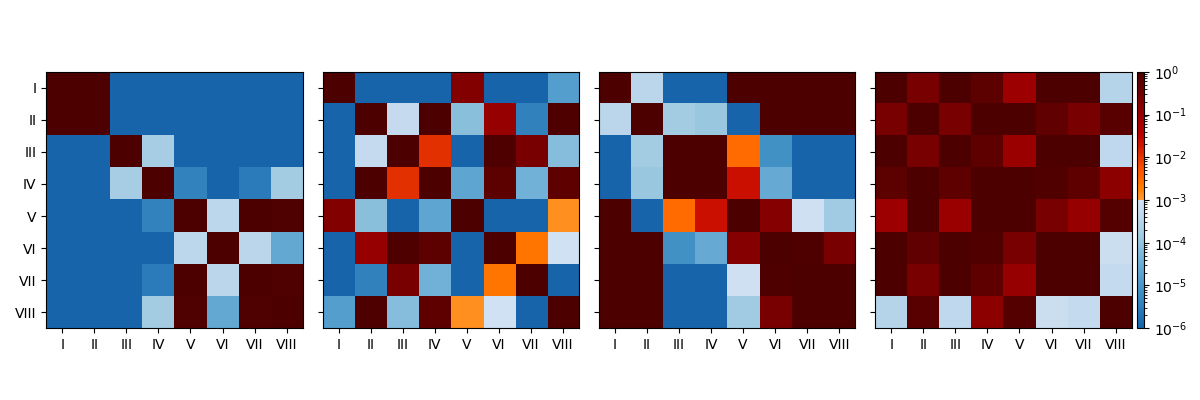

Done.


/tmp/ipykernel_4358/2228253110.py:120: RuntimeWarning: divide by zero encountered in log
  return np.ma.masked_array(np.interp(np.log(value), x, y))


In [114]:
from matplotlib import colors, ticker
import matplotlib.pyplot as plt

# Mooring IDs to include
mids = ['C2', 'C3', 'C5', 'L5']
# Figure filename
fn_fig_er = os.path.join(outdir, 'diss_ps', 'fig6_eps_ratios_{}.pdf'.format(
                         ''.join(mids)))
# Initialize figure
fig, ax = plt.subplots(figsize=(6.5,3), )
ncyc = 8
cs = ['k', 'b'] # Testing
# Mark subsections
for nc in np.arange(ncyc)[::2]:
    ax.axvspan(nc*2*np.pi/ncyc, (nc+1)*2*np.pi/ncyc, color='lightgray', 
               alpha=0.2)
# Iterate over moorings
pvals = {} # Empty dict for Tukey test p-values between sub-phases
for m, mid in enumerate(mids):
    # Read epsilon ratio .csv files
    csvdir = os.path.join(vec_root, mid, 'dissipation_rate', 'phases')
    fns_csv = sorted(glob.glob(os.path.join(csvdir, 'phase_diss_ratios_*.csv')))
    # Concatenate daily dataframes into one
    dfl = [] # Empty list for concatenating
    for fnc in fns_csv[:-1]:
        dft = pd.read_csv(fnc, parse_dates=['time']).set_index('time')
        dfl.append(dft)
    dfer = pd.concat(dfl)
    if len(mids) == 2:
        c = cs[m]
    else:
        c = clsv[mid]
    # Dissipation rates per wave-phase subsection
    ers = {} # Empty dict for ANOVA comparison between sub-phases
    for n in range(1, ncyc+1):
        # All epsilon ratios for current phase subsection
        er = np.concatenate((dfer[f'p{n}_ur1'].values, dfer[f'p{n}_ur2'].values, 
                             dfer[f'p{n}_ur3'].values, dfer[f'p{n}_ur4'].values))
        er = er[~np.isnan(er)] # Drop NaNs
        # Centered x-locations
        if len(mids) == 2:
            position = [n*2*np.pi/ncyc - np.pi/(ncyc) - (np.pi/24)*(2-(m*2+1))]
        elif len(mids) == 3:
            position = [n*2*np.pi/ncyc - np.pi/(ncyc) - (np.pi/16)*(2-(m+1))]
        elif len(mids) == 4:
            position = [n*2*np.pi/8 - np.pi/(8) - (np.pi/32)*(3-(m*2))]
        # Box plot of epsilon range
        rppl.box_plot(ax=ax, data=er, positions=position,
                      edge_color=c, fill_color='white', showfliers=False)
        # Append distribution to dict for ANOVA
        ers[f'{n}'] = er
    # Perform ANOVA analysis to examine statistical significance of variability
    # between sub-phases
    F, p = stats.f_oneway(np.array(ers['1']), np.array(ers['2']), 
                          np.array(ers['3']), np.array(ers['4']),
                          np.array(ers['5']), np.array(ers['6']),
                          np.array(ers['7']), np.array(ers['8']),
                          )
    # Print F statistic and p-value
    print(f'{mid} - F={F:.3f}, p={p:.3f}')
    # Since all p-values are small (<0.05), perform Tukey test to determine
    # significance of mean-differences between sub-phases
    res_tukey = stats.tukey_hsd(np.array(ers['1']), np.array(ers['2']), 
                                np.array(ers['3']), np.array(ers['4']),
                                np.array(ers['5']), np.array(ers['6']),
                                np.array(ers['7']), np.array(ers['8']),
                                )
    # Append p-values to dict
    pvals[mid] = res_tukey.pvalue

# Save pvalues dict to file
np.save(os.path.join(vec_root, 'pvals_eps_ratios.npy'), pvals) 

# Load
# read_dictionary = np.load('my_file.npy',allow_pickle='TRUE').item()

# Set x axis labels as multiples of pi
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(rppl.multiple_formatter()))
# Grid
ax.grid(alpha=0.5)

# Axis labels
ax.set_ylabel(r'$\epsilon_\mathrm{p} \, / \, \langle \epsilon \rangle$ $[-]$')

# Legend on top row
lines = [Line2D([0], [0], label=vec_mids['C2'], color=clsv['C2']),
         Line2D([0], [0], label=vec_mids['C3'], color=clsv['C3']),
         Line2D([0], [0], label=vec_mids['C5'], color=clsv['C5']),
         Line2D([0], [0], label=vec_mids['L5'], color=clsv['L5']),
         ]
handles, labels = ax.get_legend_handles_labels()
# add manual symbols to auto legend
handles.extend(lines)
labels.extend(['VO', 'VM', 'VI', 'VN'])
# use them in the legend
ax.legend(handles, labels, loc='upper right', ncols=len(mids))

# x label
ax.set_xlabel('Wave phase [rad]')

# No empty space on x axis
ax.margins(x=0)

plt.tight_layout()
# plt.show()
if not os.path.isfile(fn_fig_er):
    plt.savefig(fn_fig_er, bbox_inches='tight', dpi=600)
plt.close()

class MidPointLogNorm(colors.LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        colors.LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

colors1 = plt.cm.Blues_r(np.linspace(0.2, 0.8, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0.2, 0.8, 128))
# combine them and build a new colormap
cs = np.vstack((colors1, colors2))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cs)

fig, axes = plt.subplots(figsize=(12, 4), ncols=len(mids), sharex=True,
                         sharey=True)
subp_num = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII'] # Sub-phase numerals
vmin = 1e-6
vmax = 1
for i, (ax, mid) in enumerate(zip(axes, mids)):
    pv = pvals[mid] # Current sub-phase comparison p-values from Tukey test
    levels = np.concatenate([np.linspace(1e-5, 1e-4, 9, endpoint=False), 
                             np.linspace(1e-4, 1e-3, 9, endpoint=False),
                             np.linspace(1e-3, 1e-2, 9, endpoint=False),
                             np.linspace(1e-2, 1e-1, 9, endpoint=False),
                             np.linspace(1e-1, 1e0, 10, endpoint=True),
                             ])

    im = ax.imshow(pv, cmap=mymap, norm=MidPointLogNorm(vmin=vmin, vmax=vmax, midpoint=0.05))
    # im = ax.imshow(pv, cmap='RdBu_r', norm=PiecewiseNorm(levels))
    print(f'pv.min(): {pv.min():.4f}, pv.max(): {pv.max():.4f}, ')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(pv)), labels=subp_num)
    ax.set_yticks(np.arange(len(pv)), labels=subp_num)

#     # Loop over data dimensions and create text annotations.
#     for i in range(len(subp_num)):
#         for j in range(len(subp_num)):
#             text = ax.text(j, i, pv[i, j], ha="center", va="center", color="w")

    # ax.set_title(mid)

# Colorbar on right
cax = axes[-1].inset_axes([1.02, 0.0, 0.03, 1.0])
cb = fig.colorbar(im, ax=axes[-1], cax=cax, label=r'', )
# cb.ax.set_yticklabels([f'$10^{{{np.log10(b):.0f}}}$' for b in bounds])

plt.tight_layout()
# test save
# plt.savefig('/home/mikapm/Documents/test.png', bbox_inches='tight', dpi=600)
plt.show()

# plt.close()
print('Done.')


ValueError: minvalue must be less than or equal to maxvalue

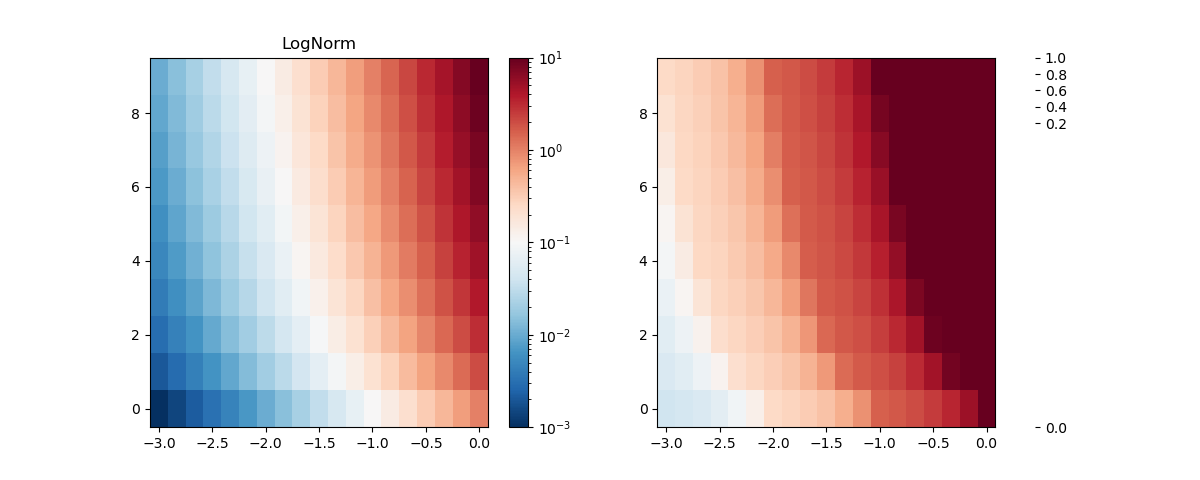

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LogNorm

x,y = np.meshgrid(np.linspace(-3,0,19), np.arange(10))
f = lambda x,y : 10**x*(1+y)
z = f(x,y)

fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(12,4.8))

im = ax.pcolormesh(x,y,z, cmap="RdBu_r", norm=LogNorm(vmin=z.min(), vmax=z.max()))
fig.colorbar(im, ax=ax)
ax.set_title("LogNorm")

class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

class PiecewiseNorm(colors.Normalize):
    def __init__(self, levels, clip=False):
        # input levels
        self._levels = np.sort(levels)
        # corresponding normalized values between 0 and 1
        self._normed = np.linspace(0, 1, len(levels))
        colors.Normalize.__init__(self, None, None, clip)

    def __call__(self, value, clip=None):
        # linearly interpolate to get the normalized value
        return np.ma.masked_array(np.interp(value, self._levels, self._normed))

    def inverse(self, value):
        return 1.0 - self.__call__(value)

im2 = ax2.pcolormesh(x,y,z, cmap="RdBu_r", 
                     norm=PiecewiseNorm(levels))
fig.colorbar(im2, ax=ax2)
ax2.set_title("MidPointLogNorm")
plt.show()

Histograms of $\epsilon_{\mathrm{p}} / \langle \epsilon \rangle$ ratios for different advection speed ranges.

In [ ]:
# Figure filename
fn_fig_er_hist = os.path.join(outdir, 'diss_ps', 'fig6_eps_ratios_hist_{}.pdf'.format(
                             ''.join(mids)))
# Initialize figure
fig, axes = plt.subplots(figsize=(6.5,5), nrows=2, ncols=4)

Figure 5: Horizontal velocity spectrum (Vector) vs. linear wave theory prediction from surface elevation (AST).

In [131]:
# Mooring IDs to include
# mids = ['C3', 'L5']
mids = ['C1', 'C3', 'C6', 'L5']
# mids = ['C1', 'C3', 'C6']
cs = ['k', 'lightgray']
labels = {'C3':'SM/VM', 'L5':'SN/VN'}
markers = {'C1':'o', 'C3':'s', 'C6':'^', 'L5':'v'}
alphas = {'C3':0.75, 'L5':0.9} # alpha values
fn_fig5 = os.path.join(outdir, 'urms_lin_{}_v2.pdf'.format(''.join(mids)))
if not os.path.isfile(fn_fig5):
    # Initialize figure
    fig, axes = plt.subplots(figsize=(7.5,3.5), ncols=2, constrained_layout=True, sharey=False,)
                             # height_ratios=(3,2))
    dfm0 = {} # Dict for merged dataframes (LWT)
    dfm0s = {} # Dict for merged dataframes (Stokes)
    ratios = [] # List for histogram ratios
    weights = [] # List for histogram weights
    ratios_st = [] # List for histogram ratios, Stokes
    weights_st = [] # List for histogram weights, Stokes
    colors = [] # List for histogram colors
    # Iterate over moorings
    for i,mid in enumerate(mids):
        # Merge m0uv measured by C3/L5 Vectors and estimated from 
        # C3/L5 Signature AST spectra
        # Merge Signature values w/ Vector measurements
        if mid in ['C3', 'L5']:
            m0uv_lin = (np.sqrt(2 * dsds[mid]['m0uv_lin'])).to_dataframe() 
            m0uv_stokes = (np.sqrt(2 * dsds[mid]['m0uv_stokes'])).to_dataframe() 
#             if len(mids) == 2:
#                 c = cs[i]
#             else:
            c = clsv[mid]
            dv = (np.sqrt(2 * dfv_dict[mid]['m0uv'])).to_frame()
            dv = (np.sqrt(2 * dfv_dict[mid]['m0uv'])).to_frame()
            dfm0[mid] = dv.merge(m0uv_lin, left_on='time', right_on='time')
            dfm0s[mid] = dv.merge(m0uv_stokes, left_on='time', right_on='time')
            # Append correct color for histogram
            colors.append(c)
            if mid == 'C3':
                label = 'SM/VM'
            elif mid == 'L5':
                label = 'SN/VN'
        elif mid == 'C1':
            # C1 Signature m0uv estimated for C2 Vector location
            m0uv_lin = (np.sqrt(2 * dsds[mid]['m0uv_lin_vec'])).to_dataframe() 
            m0uv_lin = m0uv_lin.rename(columns={'m0uv_lin_vec':'m0uv_lin'})
            m0uv_stokes = (np.sqrt(2 * dsds[mid]['m0uv_stokes_vec'])).to_dataframe() 
            m0uv_stokes = m0uv_stokes.rename(columns={'m0uv_stokes_vec':'m0uv_stokes'})
#             if len(mids) == 2:
#                 c = cs[i]
#             else:
            c = clsv['C2']
            # Combine Sig C1 w/ Vec C2
            dv = (np.sqrt(2 * dfv_dict['C2']['m0uv'])).to_frame()
            dfm0[mid] = dv.merge(m0uv_lin, left_on='time', right_on='time')
            dfm0s[mid] = dv.merge(m0uv_stokes, left_on='time', right_on='time')
            # dfm0[mid] = dfv_dict['C2'].merge(m0uv_lin, left_on='time', right_on='time')
            # Append correct color for histogram
            colors.append(c)
            label = 'SO/VO'
        elif mid == 'C6':
            # C6 Signature m0uv estimated for C5 Vector location
            m0uv_lin = (np.sqrt(2 * dsds[mid]['m0uv_lin_vec'])).to_dataframe() 
            m0uv_lin = m0uv_lin.rename(columns={'m0uv_lin_vec':'m0uv_lin'})
            m0uv_stokes = (np.sqrt(2 * dsds[mid]['m0uv_stokes_vec'])).to_dataframe() 
            m0uv_stokes = m0uv_stokes.rename(columns={'m0uv_stokes_vec':'m0uv_stokes'})
            if len(mids) == 2:
                c = cs[i]
            else:
                c = clsv['C5']
            label = 'SI/VI'
            dv = (np.sqrt(2 * dfv_dict['C5']['m0uv'])).to_frame()
            dfm0[mid] = dv.merge(m0uv_lin, left_on='time', right_on='time')
            dfm0s[mid] = dv.merge(m0uv_stokes, left_on='time', right_on='time')
            # Combine Sig C6 w/ Vec C5
            # dfm0[mid] = dfv_dict['C5'].merge(m0uv_lin, left_on='time', right_on='time')
            # Append correct color for histogram
            colors.append(c)
        # Scatter plot of obs. vs. LWT on left
        dfm0[mid].plot.scatter(x='m0uv_lin', y='m0uv', ax=axes[0], color=c, 
                               edgecolors='k', alpha=0.9, s=35, label=label,
                               linewidth=0.5, marker='o',
                               # alpha=alphas[mid], s=50, label=labels[mid],
                               )
        # Scatter plot of obs. vs. Stokes on right
#         dfm0s[mid].plot.scatter(x='m0uv_stokes', y='m0uv', ax=axes[0,1], color=c, 
#                                 edgecolors='k', alpha=0.9, s=35, #label=label,
#                                 linewidth=0.5, marker='o',
#                                 # alpha=alphas[mid], s=50, label=labels[mid],
#                                 )
        # Histograms of m0 ratios on bottom
        bins = np.linspace(0.6, 1.4, 17)
        ratio = (dfm0[mid]['m0uv']/dfm0[mid]['m0uv_lin']).values
        ratios.append(ratio) # Append to list for plotting
        # Weights for normalization
        rw = np.empty(ratio.shape)
        rw.fill(1/ratio.shape[0])
        weights.append(rw) # Append to list for plotting
        print('{} mean/max ratio (LWT): {:.2f}/{:.2f}'.format(
            mid, np.nanmean(ratio), max(ratio)))
        # Stokes
        bins_st = np.linspace(0.6, 1.4, 17)
        ratio_st = (dfm0s[mid]['m0uv']/dfm0s[mid]['m0uv_stokes']).values
        ratios_st.append(ratio_st) # Append to list for plotting
        # Weights for normalization
        rw_st = np.empty(ratio_st.shape)
        rw_st.fill(1/ratio_st.shape[0])
        weights_st.append(rw_st) # Append to list for plotting
        print('{} mean/min/max ratio (Stokes): {:.2f}/{:.2f}/{:.2f} \n'.format(
            mid, np.nanmean(ratio_st), min(ratio_st), max(ratio_st)))
    # Hack for keeping the bars at the exact location (for OSM presentation)
    if len(mids) == 1:
        ratios.append(np.zeros_like(ratio))
        ratios.append(np.zeros_like(ratio))
        ratios.append(np.zeros_like(ratio))
        weights.append(np.zeros_like(rw))
        weights.append(np.zeros_like(rw))
        weights.append(np.zeros_like(rw))
        colors.append(c)
        colors.append(c)
        colors.append(c)
    elif len(mids) == 2:
        ratios.append(np.zeros_like(ratio))
        ratios.append(np.zeros_like(ratio))
        weights.append(np.zeros_like(rw))
        weights.append(np.zeros_like(rw))
        colors.append(c)
        colors.append(c)
    elif len(mids) == 3:
        ratios.append(np.zeros_like(ratio))
        weights.append(np.zeros_like(rw))
        colors.append(c)

    # LWT ratios histograms
    axes[1].hist(ratios, color=colors, weights=weights, bins=bins, )
    # Stokes ratios histograms
    # axes[1,1].hist(ratios_st, color=colors, weights=weights_st, bins=bins_st, )
                 # rwidth=0.25*len(mids))

    # # Continuous pdfs
    # x = dfv_dict[mid].phase_uw.dropna()
    # print('mean x {}: {:.2f}'.format(mid, x.mean().item()))
    # # Fit PDF
    # mu, sigma = stats.norm.fit(x)
    # ae, loce, scalee = stats.skewnorm.fit(x)
    # # x-axis for pdf
    # points = np.linspace(stats.norm.ppf(0.0001,loc=mu,scale=sigma),
                         # stats.norm.ppf(0.9999,loc=mu,scale=sigma),
                         # 100)
    # # pdf = stats.norm.pdf(points,loc=mu,scale=sigma)
    # pdf = stats.skewnorm.pdf(points, ae, loce, scalee)#.rvs(100)
    # # Plot PDF
    # ax.plot(points, pdf, color=clsv[mid], label=vec_mids[mid])

    # 1:1 line
    for ax in [axes[0]]:
        m = dfm0['C1']['m0uv'].max() # Max obs. value at C1
        ax.axline((m, m), slope=1, c='k', ls='--', lw=0.75, alpha=0.5)
        # Equal limits
        ax.set_xlim([-0.04,m+0.04])
        ax.set_ylim([-0.04,m+0.04])
        # Grid
        ax.grid(alpha=0.5, lw=0.5)
        # Labels
        # axes[0].set_xlabel(r'$\hat{m}_{0, uv}$ $[\mathrm{m}^2/\mathrm{s}^2]$')
        # axes[0].set_ylabel(r'$m_{0, uv}$ $[\mathrm{m}^2/\mathrm{s}^2]$')
    axes[0].set_xlabel(r'$\hat{u}_\mathrm{rms}$ [m/s]')
    # axes[0,1].set_xlabel(r'$\tilde{u}_\mathrm{rms}$ [m/s]')
    axes[0].set_ylabel(r'$u_\mathrm{rms}$ [m/s]')
    # Legend on right
    axes[0].legend(loc='lower right')

    # Labels (Histograms)
    # axes[1].set_xlabel(r'$m_{0, uv} \, / \, \hat{m}_{0, uv}$ [-]')
    axes[1].set_xlabel(r'$u_\mathrm{rms} \, / \, \hat{u}_\mathrm{rms}$ [-]')
    # axes[1,1].set_xlabel(r'$u_\mathrm{rms} \, / \, \tilde{u}_\mathrm{rms}$ [-]')
    axes[1].set_ylabel('pdf')
    for ax in [axes[1]]:
        ax.margins(x=0)
        ax.set_xticks(bins[::2])
        ax.set_xlim([bins[0], bins[-1]])
        ax.set_ylim([0, 0.4])
        ax.grid(alpha=0.5, lw=0.5)

    # Annotate
    ann = ['(a)', '(b)', '(c)', '(d)']
    for i,ax in enumerate(axes.flat):
        if i < 2:
            ax.annotate(ann[i], xy=(0.03, 0.91), xycoords='axes fraction', fontsize=14)
        else:
            ax.annotate(ann[i], xy=(0.03, 0.88), xycoords='axes fraction', fontsize=14)

    # Save and close figure
    if not os.path.isfile(fn_fig5):
        plt.savefig(fn_fig5, bbox_inches='tight', dpi=600)
        plt.close()
    else:
        plt.show()

print('Done.')


C1 mean/max ratio (LWT): 1.08/1.26
C1 mean/min/max ratio (Stokes): 1.01/0.55/1.24 

C3 mean/max ratio (LWT): 1.03/1.19
C3 mean/min/max ratio (Stokes): 0.99/0.74/1.16 

C6 mean/max ratio (LWT): 1.01/1.15
C6 mean/min/max ratio (Stokes): 0.98/0.73/1.13 

L5 mean/max ratio (LWT): 1.03/1.16
L5 mean/min/max ratio (Stokes): 1.02/0.89/1.15 

Done.


Figure 4 & Figure 9: Histograms of changes in wave height and skewness, and same for orbital velocities. Note v3: Split into two separate figures (Figs. 4 and 9), one for Hrms+urms, the other one for skewness.

In [69]:
# Mooring IDs to use for Sig & Vec
midss = ['C1', 'C3', 'C6']
midsv = ['C2', 'C3', 'C5']
fn_fig4 = os.path.join(outdir, 'fig4_hrms_urms_hist_v2.pdf')
# Initialize figure
fig, axes = plt.subplots(figsize=(7.5, 3), ncols=2, nrows=1, sharey=True,
                            constrained_layout=True)
# Merge Signature Hs datasets to make sure we compare the same time periods
dfs1 = dsds['C1'].Hrms.copy().to_dataframe() # C1 wave heights
# Rename col.
dfs1 = dfs1.rename(columns={'Hrms':'C1'})
dfs3 = dsds['C3'].Hrms.copy().to_dataframe() # C3 wave heights
dfs3 = dfs3.rename(columns={'Hrms':'C3'})
dfs6 = dsds['C6'].Hrms.copy().to_dataframe() # C6 wave heights
dfs6 = dfs6.rename(columns={'Hrms':'C6'})
# Merge C3 & C6 w/ C1
dfmsh = dfs1.merge(dfs3, right_on='time', left_on='time')
dfmsh = dfmsh.merge(dfs6, right_on='time', left_on='time')
# Drop nans just in case
dfmsh = dfmsh.dropna()
# Weights for normalization
c1_w = np.empty(dfmsh['C1'].shape)
c1_w.fill(1/dfmsh['C1'].shape[0])
c3_w = np.empty(dfmsh['C3'].shape)
c3_w.fill(1/dfmsh['C3'].shape[0])
c6_w = np.empty(dfmsh['C6'].shape)
c6_w.fill(1/dfmsh['C6'].shape[0])
# Top row: Signature wave height and skewness
# binsh = np.linspace(0.1, 1.5, 11)
binsh = np.linspace(0., 1.5, 11)
axes[0].hist([dfmsh['C1'], dfmsh['C3'], dfmsh['C6']], 
             color=[clss['C1'], clss['C3'], clss['C6']],
             bins=binsh, weights=[c1_w, c3_w, c6_w],
             label=[sig_mids['C1'], sig_mids['C3'], sig_mids['C6']],
             )
# Legend
axes[0].legend(loc='upper right')

# Merge Vector urms datasets to make sure we compare the same time periods
dfv2 = dfv_dict['C2']['Urms'].to_frame() # C2 urms
# Rename col.
dfv2 = dfv2.rename(columns={'Urms':'C2'})
dfv3 = dfv_dict['C3']['Urms'].to_frame() # C3 urms
dfv3 = dfv3.rename(columns={'Urms':'C3'})
dfv5 = dfv_dict['C5']['Urms'].to_frame() # C5 urms
dfv5 = dfv5.rename(columns={'Urms':'C5'})
# Merge C3 & C6 w/ C1
dfmvu = dfv2.merge(dfv3, right_on='time', left_on='time')
dfmvu = dfmvu.merge(dfv5, right_on='time', left_on='time')
# Drop nans just in case
dfmvu = dfmvu.dropna()
# Weights for normalization
c2_w = np.empty(dfmvu['C2'].shape)
c2_w.fill(1/dfmvu['C2'].shape[0])
c3_w = np.empty(dfmvu['C3'].shape)
c3_w.fill(1/dfmvu['C3'].shape[0])
c5_w = np.empty(dfmvu['C5'].shape)
c5_w.fill(1/dfmvu['C5'].shape[0])
# bottom left: Vector Urms
# binsu = np.linspace(0.05, 1.25, 11)
binsu = np.linspace(0., 1.5, 11)
axes[1].hist([dfmvu['C2'], dfmvu['C3'], dfmvu['C5']], 
             color=[clsv['C2'], clsv['C3'], clsv['C5']],
             bins=binsu, weights=[c2_w, c3_w, c5_w],
             label=[vec_mids['C2'], vec_mids['C3'], vec_mids['C5']],
             )
# Legend
axes[1].legend(loc='upper right')

# Print mean and std of % change in Hrms from C1 to C6
d_hrms = dfmsh['C6'] / dfmsh['C1']
print('Mean/std change in Hrms C6/C1: {:.2f}/{:.2f}'.format(d_hrms.mean(), d_hrms.std()))
# Print mean and std of % change in Hrms from C1 to C6
d_urms = dfmvu['C5'] / dfmvu['C2']
print('Mean/std change in urms C5/C2: {:.2f}/{:.2f}'.format(d_urms.mean(), d_urms.std()))

# Labels
axes[0].set_xlabel(r'$H_\mathrm{rms}$ [m]')
axes[1].set_xlabel(r'$u_\mathrm{rms}$ [m/s]')
axes[0].set_ylabel('pdf')
# x limits
axes[0].set_xlim([0,1.5])
axes[0].set_xticks(binsh[::2])
axes[1].set_xlim([0,1.5])
axes[1].set_xticks(binsu[::2])
# y limits + annotate
ann = ['(a)', '(b)', '(c)', '(d)']
for i,ax in enumerate(axes.flat):
    ax.set_ylim([0,0.51])
    ax.annotate(ann[i], xy=(0.03, 0.9), xycoords='axes fraction', fontsize=14)
    ax.grid(alpha=0.5, lw=0.5)

# Save figure
if not os.path.isfile(fn_fig4):
    plt.savefig(fn_fig4, bbox_inches='tight', dpi=600)
plt.close()


# Skewness distributions
fn_fig9 = os.path.join(outdir, 'fig9_skewh_skewu_hist.pdf')
# Initialize figure
fig, axes = plt.subplots(figsize=(7.5, 3), ncols=2, nrows=1, sharey=True,
                        constrained_layout=True)
# Merge Signature skewness datasets
dfs1 = dsds['C1'].skew.copy().to_dataframe() # C1 skewness
# Rename col.
dfs1 = dfs1.rename(columns={'skew':'C1'})
dfs3 = dsds['C3'].skew.copy().to_dataframe() # C3 skewness
dfs3 = dfs3.rename(columns={'skew':'C3'})
dfs6 = dsds['C6'].skew.copy().to_dataframe() # C6 skewness
dfs6 = dfs6.rename(columns={'skew':'C6'})
# Merge C3 & C6 w/ C1
dfmss = dfs1.merge(dfs3, right_on='time', left_on='time')
dfmss = dfmss.merge(dfs6, right_on='time', left_on='time')
# Drop nans just in case
dfmss = dfmss.dropna()
# Weights for normalization
c1_w = np.empty(dfmss['C1'].shape)
c1_w.fill(1/dfmss['C1'].shape[0])
c3_w = np.empty(dfmss['C3'].shape)
c3_w.fill(1/dfmss['C3'].shape[0])
c6_w = np.empty(dfmss['C6'].shape)
c6_w.fill(1/dfmss['C6'].shape[0])
# Sig wave skewness histogram
# binss = np.linspace(-0.05, 0.6, 11)
binss = np.linspace(-0.2, 0.6, 9)
axes[0].hist([dfmss['C1'], dfmss['C3'], dfmss['C6']], 
             color=[clss['C1'], clss['C3'], clss['C6']],
             bins=binss, weights=[c1_w, c3_w, c6_w],
             label=[sig_mids['C1'], sig_mids['C3'], sig_mids['C6']],
             )
# Legend
axes[0].legend(loc='upper right')

# Merge Vector u-skewness datasets to make sure we compare the same time periods
dfv2 = dfv_dict['C2']['skew_ucs'].to_frame() # C2 urms
# Rename col.
dfv2 = dfv2.rename(columns={'skew_ucs':'C2'})
dfv3 = dfv_dict['C3']['skew_ucs'].to_frame() # C3 urms
dfv3 = dfv3.rename(columns={'skew_ucs':'C3'})
dfv5 = dfv_dict['C5']['skew_ucs'].to_frame() # C6 urms
dfv5 = dfv5.rename(columns={'skew_ucs':'C5'})
# Merge C3 & C6 w/ C1
dfmvs = dfv2.merge(dfv3, right_on='time', left_on='time')
dfmvs = dfmvs.merge(dfv5, right_on='time', left_on='time')
# Drop nans just in case
dfmvs = dfmvs.dropna()
# Weights for normalization
c2_w = np.empty(dfmvs['C2'].shape)
c2_w.fill(1/dfmvs['C2'].shape[0])
c3_w = np.empty(dfmvs['C3'].shape)
c3_w.fill(1/dfmvs['C3'].shape[0])
c5_w = np.empty(dfmvs['C5'].shape)
c5_w.fill(1/dfmvs['C5'].shape[0])
# bottom right: Vector cross-shore vel. skewness
# binssv = np.linspace(-0.2, 0.4, 11)
binssv = np.linspace(-0.2, 0.6, 9)
axes[1].hist([dfmvs['C2'], dfmvs['C3'], dfmvs['C5']], 
             color=[clsv['C2'], clsv['C3'], clsv['C5']],
             bins=binssv, weights=[c2_w, c3_w, c5_w],
             label=[vec_mids['C2'], vec_mids['C3'], vec_mids['C5']],
             )
# Legend
axes[1].legend(loc='upper right')

# Labels
axes[0].set_xlabel(r'$\mathrm{skew}(\zeta)$ [-]')
axes[1].set_xlabel(r'$\mathrm{skew}(u)$ [-]')
axes[0].set_ylabel('pdf')
# Limits
axes[0].set_xlim([-0.2,0.6])
axes[0].set_xticks(binss)
axes[1].set_xlim([-0.2,0.6])
axes[1].set_xticks(binssv)
# y limits + annotate
ann = ['(a)', '(b)', '(c)', '(d)']
for i,ax in enumerate(axes.flat):
    ax.set_ylim([0,0.51])
    ax.annotate(ann[i], xy=(0.03, 0.9), xycoords='axes fraction', fontsize=14)
    ax.grid(alpha=0.5, lw=0.5)

# Print mean and std of % change in Hrms from C1 to C6
d_hskew = (dfmss['C1'] - dfmss['C6']) 
print('Mean/std change in eta-skewness C6/C1: {:.2f}/{:.2f}'.format(d_hskew.mean(), d_hskew.std()))
# Print mean and std of % change in Hrms from C1 to C6
d_uskew = (dfmvs['C2'] - dfmvs['C5'])
print('Mean/std change in u-skewness C5/C2: {:.2f}/{:.2f}'.format(d_uskew.mean(), d_uskew.std()))

if not os.path.isfile(fn_fig9):
    # Save figure
    plt.savefig(fn_fig9, bbox_inches='tight', dpi=600)
plt.close()

print('Done.')


Mean/std change in Hrms C6/C1: 0.96/0.02
Mean/std change in urms C5/C2: 0.80/0.03
Mean/std change in eta-skewness C6/C1: -0.05/0.04
Mean/std change in u-skewness C5/C2: 0.11/0.06
Done.


In [157]:
dfmvs.describe([0.25, 0.5, 0.75])

,C2,C3,C5
count,557.000000,557.000000,557.000000
mean,0.175627,0.076570,0.061355
std,0.101790,0.098602,0.113975
min,-0.089264,-0.135429,-0.221285
25%,0.103079,0.004863,-0.024871
50%,0.176807,0.069260,0.048371
75%,0.239357,0.139067,0.124986
max,0.513651,0.444179,0.458115


Figure 6: Vector dissipation rates vs. $U_\mathrm{rms}^3$.

In [22]:
# Use all Vectors
# mids = ['C2', 'C3', 'C5', 'L1', 'L5']
mids = ['C2', 'C3', 'C5', 'L5']
# Figure filename
fn_fig6 = os.path.join(outdir, 'fig6_eps_vs_urms_v2.pdf')
if not os.path.isfile(fn_fig6):
    # Init. figure
    fig, axes = plt.subplots(figsize=(7.5, 5), nrows=2, ncols=2, 
                             # sharex=True, sharey=True, 
                             constrained_layout=True,
                             )
    # Iterate over Vectors and plot
    for i,mid in enumerate(mids):
        x = (dfv_dict[mid]['Urms']**3).to_frame()
        y = dfv_dict[mid]['eps_ps']
        ystd = dfv_dict[mid]['eps_ps_std']
        ax = axes.flat[i] # Current axis
#         ax.scatter(x, y, color=clsv[mid], label=vec_mids[mid], edgecolors='k', 
#                    lw=0.5, alpha=0.8)
        ax.errorbar(x.values, y.values, color=clsv[mid], yerr=ystd, label=vec_mids[mid], 
                    capsize=1.5, ms=3, alpha=0.75, elinewidth=0.5, fmt='o',
                    markeredgecolor='k', ecolor='k', mew=0.5,
                    )
        # Least squares fit, see:
        # https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
        # Force intercept to be 0, see:
        # https://stackoverflow.com/questions/54257216/how-to-set-intercept-to-0-with-statsmodel-for-multiple-linear-regression
        # model = sm.OLS(y, x.assign(intercept=0), missing='drop')
        #     model = sm.RLM(y, sm.add_constant(x), missing='drop', M=sm.robust.norms.HuberT())
        #     results = model.fit()
        #     b, m = results.params
        # Force intercept to go through zero
        model = smm.RLM(y, x.assign(intercept=0), missing='drop', 
                        M=smm.robust.norms.HuberT())
        results = model.fit()
        m, b = results.params
        # Plot least squares fit
        #     if b < 0:
        #         s = f'$y = {m:.2f}x - {abs(b):.2f}$' # Line label
        #     else:
        #         s = f'$y = {m:.2f}x + {b:.2f}$' # Line label
        s = f'$y = {m:.4f}x$' # Regression function
        ax.axline(xy1=(0,b), slope=m, color='k', linestyle='-', lw=1)
        # Annotate regression functions
    #     ax.annotate(s, xy=(0.76, 0.26-(0.05*i)), xycoords='axes fraction', c=clsv[mid],
    #                 fontsize=12)
        # Legend markers without errorbars
        handles, labels = ax.get_legend_handles_labels()
        # remove the errorbars
        handles = [h[0] for h in handles]
        # use them in the legend
        ax.legend(handles, labels, loc='lower right')
        # ax.legend()
        # Grid
        ax.grid(alpha=0.5, lw=0.5)

    # Annotate
    ann = ['(a)', '(b)', '(c)', '(d)', '(e)']
    for i,ax in enumerate(axes.flat):
        ax.annotate(ann[i], xy=(0.03, 0.85), xycoords='axes fraction', fontsize=13)
        ax.set_ylabel(r'$\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')
    axes[-1,0].set_xlabel(r'$u_\mathrm{\, rms}^3$ $[\mathrm{m}^3 \mathrm{s}^{-3}]$')
    axes[-1,1].set_xlabel(r'$u_\mathrm{\, rms}^3$ $[\mathrm{m}^3 \mathrm{s}^{-3}]$')

    # x-axis limits
    axes[0,0].set_xlim([-0.1, 2.1])
    axes[0,1].set_xlim([-0.1, 2.1])
    axes[1,0].set_xlim([-0.1, 2.1])
    axes[1,1].set_xlim([-0.1, 0.6])
    # y-axis limits
    axes[0,0].set_ylim([-0.0001, 0.0021])
    axes[0,1].set_ylim([-0.0001, 0.0021])
    axes[1,0].set_ylim([-0.0001, 0.0021])
    axes[1,1].set_ylim([-0.0001, 0.0008])

    # Save figure
    plt.savefig(fn_fig6, bbox_inches='tight', dpi=600)
    plt.close()

print('Done.')



Done.


In [30]:
dfv_dict['L5']['eps_ps'].nlargest(3)

time
2022-07-07 01:00:00    0.000443
2022-07-06 06:00:00    0.000366
2022-07-01 18:00:00    0.000250
Name: eps_ps, dtype: float64

Figure 7: observed vs. modeled wave attenuation.

In [43]:
# Directory with Matlab output
matdir = '/home/mikapm/Github/wave_dissipation_module/out'
# Output netcdf file name
fn_nc = os.path.join(sig_root, 'C6_wave_dissipation_Cf.nc')
if not os.path.isfile(fn_nc):
    # List all .mat files
    fns_mat = sorted(glob.glob(os.path.join(matdir, 'diss_*.mat')))
    # Initialize arrays
    times = []
    # Range of friction factor values
    Cfs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
                    1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]) 
    # C1 rms wave heights
    Hrms_c1 = dsds['C1'].Hrms.copy().to_dataframe()
    # Predicted Hrms profiles
    Hrms = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan 
    # Predicted wave-breaking diss. profiles
    D_br = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan 
    # Predicted bottom-frict. diss. profiles
    D_fr = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan 
    # Initialize xr.Dataset for modeled data
    dsm = xr.Dataset(
        data_vars=dict(
            Hrms=(['time', 'x', 'Cf'], Hrms),
            D_br=(['time', 'x', 'Cf'], D_br),
            D_fr=(['time', 'x', 'Cf'], D_fr),
        ),
        coords=dict(
            time=(['time'], dss.time.values),
            x=(['x'], xt),
            Cf=(['Cf'], Cfs),
        ),
    )

    # Iterate over .mat files and populate arrays
    for fnm in fns_mat:
        # Get friction coefficient from filename
        Cf = float(fnm.split('_')[-1][:3])
        # Get time stamp from filename
        t = pd.Timestamp(DT.strptime(' '.join(fnm.split('_')[-4:-2]), '%Y%m%d %H%M'))
        # Append timestamp to list
        times.append(t)
        # Read .mat file and get variables
        mat = loadmat(fnm)
        Hrms = mat['S']['Hrms'].item().squeeze()
        D_br = mat['S']['Db'].item().squeeze()
        D_fr = mat['S']['Df'].item().squeeze()
        # Populate variables
        dsm.Hrms.loc[dict(time=t, Cf=Cf)] = Hrms
        dsm.D_br.loc[dict(time=t, Cf=Cf)] = D_br
        dsm.D_fr.loc[dict(time=t, Cf=Cf)] = D_fr

    # Save dataset to netcdf
    dsm.to_netcdf(fn_nc)
else:
    dsm = xr.open_dataset(fn_nc, decode_coords='all')

# Cf = 1.1 gives best fit of predictions vs. observations
Cf = 1.1
# Predicted Hrms time series (from Matlab code)
hp = dsm.Hrms.sel(x=17.5, Cf=Cf).to_dataframe() 
# Rename variable
hp = hp.rename(columns={'Hrms':'Hrms_pred'})
hp = hp['Hrms_pred'].to_frame()
# Get C6 observed Hrms time series
ho = dsds['C6'].Hrms.copy().to_dataframe()
# Rename variable
ho = ho.rename(columns={'Hrms':'Hrms_obs'})
# Merge observed & predicted Hrms timeseries from C6
df = hp.merge(ho, left_on='time', right_on='time')

# Merge Hrms from C1 vs C6
hi = dsds['C1'].Hrms.copy().to_dataframe()
hi = hi.rename(columns={'Hrms':'Hrms_obs_C1'})
dfh = ho.merge(hi, right_on='time', left_on='time')

# Plot scatter
fig, axes = plt.subplots(figsize=(7.5,3.75), ncols=2, sharex=True, sharey=True)
# On left, C1 vs C6 Hrms
dfh.plot.scatter(ax=axes[0], x='Hrms_obs_C1', y='Hrms_obs', c='gray', alpha=0.75,
                 edgecolors='k', lw=0.5, s=30)
# Least squares fit
x = dfh['Hrms_obs_C1'].to_frame()
y = dfh['Hrms_obs'].to_frame()
#     model = sm.RLM(y, sm.add_constant(x), missing='drop', M=sm.robust.norms.HuberT())
#     results = model.fit()
#     b, m = results.params
# Force intercept to go through zero
model = smm.RLM(y, x.assign(intercept=0), missing='drop', M=smm.robust.norms.HuberT())
results = model.fit()
m, b = results.params
# Plot least squares fit
#     if b < 0:
#         s = f'$y = {m:.2f}x - {abs(b):.2f}$' # Line label
#     else:
#         s = f'$y = {m:.2f}x + {b:.2f}$' # Line label
s = f'$y = {m:.2f}x$'
axes[0].axline(xy1=(0,b), slope=m, color='k', linestyle='-', label=s,)
# R-squared of linear fit
r_squared = rps.r_squared(y_obs=y.values, y_pred=x.values)
# axes[1].annotate(r'$R^2$='+'{:.2f}'.format(r_squared), xy=(0.05, 0.93), 
#             xycoords='axes fraction', fontsize=12)
# Obs. vs predicted Hrms at C6 on right
df.plot.scatter(ax=axes[1], x='Hrms_pred', y='Hrms_obs', c='gray', alpha=0.75,
                 edgecolors='k', lw=0.5, s=30)
# Least squares fit, see:
# https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
# Force intercept to be 0, see:
# https://stackoverflow.com/questions/54257216/how-to-set-intercept-to-0-with-statsmodel-for-multiple-linear-regression
# model = sm.OLS(y, x.assign(intercept=0), missing='drop')
x = df['Hrms_pred'].to_frame()
y = df['Hrms_obs'].to_frame()
#     model = sm.RLM(y, sm.add_constant(x), missing='drop', M=sm.robust.norms.HuberT())
#     results = model.fit()
#     b, m = results.params
# Force intercept to go through zero
model = smm.RLM(y, x.assign(intercept=0), missing='drop', M=smm.robust.norms.HuberT())
results = model.fit()
m, b = results.params
# Plot least squares fit
#     if b < 0:
#         s = f'$y = {m:.2f}x - {abs(b):.2f}$' # Line label
#     else:
#         s = f'$y = {m:.2f}x + {b:.2f}$' # Line label
# s = f'$y = {m:.2f}x$'
s = f'$y = {m:.2f}x$' + r' ($C_\mathrm{f}$' + '={:.1f})'.format(Cf)
axes[1].axline(xy1=(0,b), slope=m, color='k', linestyle='-', label=s)
# R-squared of linear fit
r_squared = rps.r_squared(y_obs=y.values, y_pred=x.values)
# axes[1].annotate(r'$R^2$='+'{:.2f}'.format(r_squared), xy=(0.05, 0.93), 
#             xycoords='axes fraction', fontsize=12)


# Plot regresion lines with Cf=0.1 and Cf=2
cs = ['blue', 'red']
for i,Cf in enumerate([0.1, 2]):
    # Predicted Hrms time series (from Matlab code)
    hp = dsm.Hrms.sel(x=17.5, Cf=Cf).to_dataframe() 
    # Rename variable
    hp = hp.rename(columns={'Hrms':'Hrms_pred'})
    hp = hp['Hrms_pred'].to_frame()
    # Get C6 observed Hrms time series
    ho = dsds['C6'].Hrms.copy().to_dataframe()
    # Rename variable
    ho = ho.rename(columns={'Hrms':'Hrms_obs'})
    # Merge observed & predicted Hrms timeseries from C6
    df = hp.merge(ho, left_on='time', right_on='time')
    x = df['Hrms_pred'].to_frame()
    y = df['Hrms_obs'].to_frame()
    #     model = sm.RLM(y, sm.add_constant(x), missing='drop', M=sm.robust.norms.HuberT())
    #     results = model.fit()
    #     b, m = results.params
    # Force intercept to go through zero
    model = smm.RLM(y, x.assign(intercept=0), missing='drop', M=smm.robust.norms.HuberT())
    results = model.fit()
    m, b = results.params
    # Plot least squares fit
    #     if b < 0:
    #         s = f'$y = {m:.2f}x - {abs(b):.2f}$' # Line label
    #     else:
    #         s = f'$y = {m:.2f}x + {b:.2f}$' # Line label
    s = f'$y = {m:.2f}x$' + r' ($C_\mathrm{f}$' + '={:.1f})'.format(Cf)
    axes[1].axline(xy1=(0,b), slope=m, color=cs[i], linestyle='-', label=s, ls=':')
    # R-squared of linear fit

for ax in axes:
    # 1:1 line
    ax.axline(xy1=(0,0), slope=1, color='k', ls='--', label=r'$y = x$')
    # Title, limits, etc.
    # axes[0].set_title(r'$\mathrm{C_f}$ = ' + '{:.2f}'.format(Cf))
    ax.grid(alpha=0.5)
    ax.legend(loc='lower right', fontsize=9)
    ax.set_xlim([0, 1.4])
    ax.set_ylim([0, 1.4])

axes[0].set_xlabel(r'Observed $H_\mathrm{rms}$ (SO) [m]')
axes[0].set_ylabel(r'Observed $H_\mathrm{rms}$ (SI) [m]')
axes[1].set_xlabel(r'Predicted $H_\mathrm{rms}$ (SI) [m]')

plt.tight_layout()
fn_fig5 = os.path.join(outdir, 'fig5_wave_attenuation_c1c6.pdf')
if not os.path.isfile(fn_fig5):
    plt.savefig(fn_fig5, bbox_inches='tight', dpi=600)
# plt.show()
plt.close()

In [70]:
# Directory with Matlab output
matdir = '/home/mikapm/Github/wave_dissipation_module/out'
# Output netcdf file name
fn_nc = os.path.join(sig_root, 'C6_wave_dissipation_Cf.nc')
if not os.path.isfile(fn_nc):
    # List all .mat files
    fns_mat = sorted(glob.glob(os.path.join(matdir, 'diss_*.mat')))
    # Initialize arrays
    times = []
    # Range of friction factor values
    Cfs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
                    1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]) 
    # C1 rms wave heights
    Hrms_c1 = dsds['C1'].Hrms.copy().to_dataframe()
    # Predicted Hrms profiles
    Hrms = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan 
    # Predicted wave-breaking diss. profiles
    D_br = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan 
    # Predicted bottom-frict. diss. profiles
    D_fr = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan 
    # Initialize xr.Dataset for modeled data
    dsm = xr.Dataset(
        data_vars=dict(
            Hrms=(['time', 'x', 'Cf'], Hrms),
            D_br=(['time', 'x', 'Cf'], D_br),
            D_fr=(['time', 'x', 'Cf'], D_fr),
        ),
        coords=dict(
            time=(['time'], dss.time.values),
            x=(['x'], xt),
            Cf=(['Cf'], Cfs),
        ),
    )

    # Iterate over .mat files and populate arrays
    for fnm in fns_mat:
        # Get friction coefficient from filename
        Cf = float(fnm.split('_')[-1][:3])
        # Get time stamp from filename
        t = pd.Timestamp(DT.strptime(' '.join(fnm.split('_')[-4:-2]), '%Y%m%d %H%M'))
        # Append timestamp to list
        times.append(t)
        # Read .mat file and get variables
        mat = loadmat(fnm)
        Hrms = mat['S']['Hrms'].item().squeeze()
        D_br = mat['S']['Db'].item().squeeze()
        D_fr = mat['S']['Df'].item().squeeze()
        # Populate variables
        dsm.Hrms.loc[dict(time=t, Cf=Cf)] = Hrms
        dsm.D_br.loc[dict(time=t, Cf=Cf)] = D_br
        dsm.D_fr.loc[dict(time=t, Cf=Cf)] = D_fr

    # Save dataset to netcdf
    dsm.to_netcdf(fn_nc)
else:
    dsm = xr.open_dataset(fn_nc, decode_coords='all')


# Cf = 1.1 gives best fit of predictions vs. observations
Cf = 1.1
xps = {'C2': 4.5, 'C3':9.5, 'C5':15.5}
# Initialize figure
fig, axes = plt.subplots(figsize=(7.5,2.5), ncols=3, sharex=True, sharey=True,
                            constrained_layout=True)
ann = ['(a)', '(b)', '(c)', ]
for i,mid in enumerate(['C2','C3', 'C5']):
    # Get x point in model grid of current mooring
    xp = xps[mid]
    # Predicted Hrms time series (from Matlab code)
    dp = dsm.D_fr.sel(x=xp, Cf=Cf).to_dataframe() 
    # Rename variable
    dp = dp.rename(columns={'D_fr':'Dfr_pred'})
    dp = dp['Dfr_pred'].to_frame()
    do = dfv_dict[mid]['eps_ps'].copy().to_frame()
    # Rename variable
    do = do.rename(columns={'eps_ps':'Dfr_obs'})
    # Merge observed & predicted Hrms timeseries from C6
    df = dp.merge(do, left_on='time', right_on='time')
    # Also merge local depth of observations
    dd = dfv_dict[mid]['depth_loc'].copy().to_frame()
    df = df.merge(dd, left_on='time', right_on='time')
    df['Dfr_pred_d'] = df['Dfr_pred'] / df['depth_loc']

    # On left, C1 vs C6 Hrms
    df.plot.scatter(ax=axes[i], x='Dfr_pred_d', y='Dfr_obs', c=clsv[mid], alpha=0.85,
                    edgecolors='k', lw=0.5, s=30, label=vec_mids[mid])

    x = df['Dfr_pred_d'].to_frame()
    y = df['Dfr_obs'].to_frame()
    #     model = sm.RLM(y, sm.add_constant(x), missing='drop', M=sm.robust.norms.HuberT())
    #     results = model.fit()
    #     b, m = results.params
    # Force intercept to go through zero
    model = smm.RLM(y, x.assign(intercept=0), missing='drop', M=smm.robust.norms.HuberT())
    results = model.fit()
    m, b = results.params
    # Plot least squares fit
    #     if b < 0:
    #         s = f'$y = {m:.2f}x - {abs(b):.2f}$' # Line label
    #     else:
    #         s = f'$y = {m:.2f}x + {b:.2f}$' # Line label
    s = f'$y = {m:.2f}x$'
    axes[i].axline(xy1=(0,b), slope=m, color='k', linestyle='-', label=s,)

    # Annotate (a), (b), (c)
    axes[i].annotate(ann[i], xy=(0.05, 0.87), 
                     xycoords='axes fraction', fontsize=14)

for ax in axes:
    ax.grid(alpha=0.5, lw=0.5)
    ax.legend(fontsize=8, loc='lower right')
    ax.set_xlabel(r'Pred. $D_\mathrm{fr} \, / \, h$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')

axes[0].set_ylabel(r'Obs. $\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')

fn_fig10 = os.path.join(outdir, 'fig10_diss_obs_vs_pred.pdf')
if not os.path.isfile(fn_fig10):
    plt.savefig(fn_fig10, bbox_inches='tight', dpi=600)
# plt.show()
plt.close()

frac_s: 4.577402342068688
frac_v: 4.577402342068688
dfxy_s["x"].values[:10]: 0.4265398637463769
dfxy_v["x"].values[:10]: 0.4265398637463769
Sig SO: y = 1.62x


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

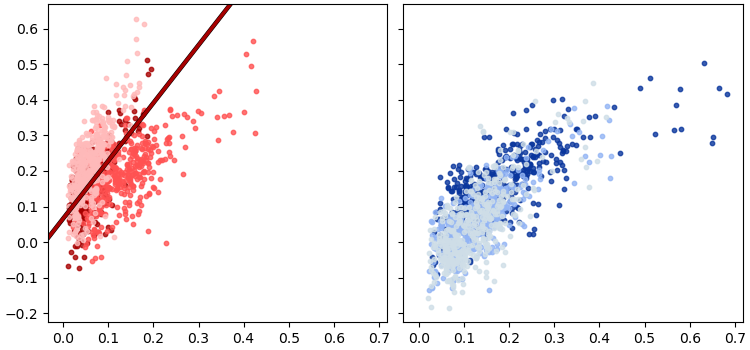

In [203]:
plt.clf(); plt.close()
from scipy.optimize import curve_fit, least_squares
# def func(x, a, b, c):
#     return a * (x-b)**c
def func(x, a, b,):
    return (x)**a + b
# def func(x, theta):
#     # Return residual = fit-observed
#     return (theta[0] * (x - theta[1])**theta[2])
# def residual(p, x, y):
#     return y - func(x, *p)

midss = ['C1', 'C3', 'C6',]# 'L5']
midsv = ['C2', 'C3', 'C5',]# 'L5']
fig, axes = plt.subplots(figsize=(7.5, 3.5), ncols=2, constrained_layout=True,
                         sharex=True, sharey=True)
xss = {} # Dict to store x values for regressions, Signatures
yss = {} # Dict to store y values for regressions, Signatures
xsv = {} # Dict to store x values for regressions, Vectors
ysv = {} # Dict to store y values for regressions, Vectors
t0 = pd.Timestamp('2022-06-27 00:00')
t1 = pd.Timestamp('2022-07-14 10:00')
for mid_s, mid_v in zip(midss, midsv):
    # Signature AST surface elevation skewness vs. Hrms/depth from C1
    # xis = (dsds['C1']['Hrms']/dsds['C1']['depth_loc']).to_series().to_frame()
    # xis = (dsds[mid_s]['Hrms'].sel(time=slice(t0,t1))/dsds[mid_s]['depth_loc'].sel(time=slice(t0,t1))).to_series().to_frame()
    coef = (3/4) * 9.81 / (8*np.pi**2) # Constant of Ursell number
#     frac = ((dsds['C1']['Hrms'] * (dsds['C1']['Tp']**2)) / (dsds['C1']['depth_loc']**2))
    hrms = dsds[mid_s]['Hrms'].sel(time=slice(t0,t1))
    tp = dsds[mid_s]['Tp'].sel(time=slice(t0,t1))
    dloc = dsds[mid_s]['depth_loc'].sel(time=slice(t0,t1))
    frac_s = ((hrms * tp**2)) / (dloc**2)
    xis = (coef * frac_s).to_series().to_frame()
    xis.columns = ['x']
    yis = dsds[mid_s]['skew'].sel(time=slice(t0,t1)).to_dataframe()
    yis.columns = ['y']
    # Merge xi and yi to get same periods
    dfxy_s = xis.merge(yis, left_on='time', right_on='time').dropna()
    # Also merge C1 Tp
#     c1_tp = dsds['C1']['Tp'].to_series().to_frame()
#     c1_tp.columns = ['Tp']
#     dfxy_s = dfxy_s.merge(c1_tp, left_on='time', right_on='time')
    xss[mid_s] = dfxy_s['x'] # Store to dict for regression
    yss[mid_s] = dfxy_s['y'] # Store to dict for regression
    axes[0].scatter(dfxy_s['x'], dfxy_s['y'], color=clss[mid_s], alpha=0.8, 
                    label=sig_mids[mid_s], s=10,
                    #s=dfxy_s['Tp']*1.5
                    )
    # Vector cross-shore velocity skewness - also plot against C1 Hrms/d
    # xiv = (dfv_dict[mid]['Urms']).to_frame()
    # xiv = (dfv_dict[mid_v]['Urms'].loc[t0:t1]/(dfv_dict[mid_v]['depth_loc'].loc[t0:t1]/dsds[mid_s]['Tp'].sel(time=slice(t0,t1)))).to_frame()
    # xiv = (dfv_dict[mid_v]['Urms'].loc[t0:t1]/(dsds[mid_s]['depth_loc'].loc[t0:t1]*dsds[mid_s]['kp'].sel(time=slice(t0,t1)))).to_frame()
    # xiv = (dsds[mid_s]['Hrms'].sel(time=slice(t0,t1))/dfv_dict[mid_v]['depth_loc'].loc[t0:t1]).to_series().to_frame()
    # xiv = (dsds['C1']['Hrms']/dsds['C1']['depth_loc']).to_series().to_frame()
    # xiv = (dsds[mid_s]['Hrms']/dsds[mid_s]['depth_loc']).to_series().to_frame()
    coef = (3/4) * 9.81 / (8 * np.pi**2) # Constant of Ursell number
    # frac = ((dsds['C1']['Hrms'] * (dsds['C1']['Tp']**2)) / (dsds['C1']['depth_loc']**2))
    hrms = dsds[mid_s]['Hrms'].sel(time=slice(t0,t1))
    tp = dsds[mid_s]['Tp'].sel(time=slice(t0,t1))
    if mid_v == 'C3':
        dloc = dsds[mid_s]['depth_loc'].sel(time=slice(t0,t1))
    else:
        dloc = dfv_dict[mid_v]['depth_loc'].loc[t0:t1]
    frac_v = ((hrms * tp**2)) / (dloc**2)
    if mid_v == 'C3':
        print(f'frac_s: {frac_s.values.max()}')
        print(f'frac_v: {frac_v.values.max()}')
    xiv = (coef * frac_v).to_series().to_frame()
    xiv.columns = ['x']
    yiv = dfv_dict[mid_v]['skew_ucs'].loc[t0:t1].to_frame()
    yiv.columns = ['y']
    # Merge xi and yi to get same periods
    dfxy_v = xiv.merge(yiv, left_on='time', right_on='time').dropna()
    if mid_v == 'C3':
        print(f'dfxy_s["x"].values[:10]: {dfxy_s["x"].max()}')
        print(f'dfxy_v["x"].values[:10]: {dfxy_v["x"].max()}')
    # Also merge C1 Tp
#     c1_tp = dsds['C1']['Tp'].to_series().to_frame()
#     c1_tp.columns = ['Tp']
#     dfxy_v = dfxy_v.merge(c1_tp, left_on='time', right_on='time')
    xsv[mid_v] = dfxy_v['x']
    ysv[mid_v] = dfxy_v['y']
    axes[1].scatter(dfxy_v['x'], dfxy_v['y'], label=vec_mids[mid_v],
                    color=clsv[mid_v], alpha=0.8, s=10,
                    #s=dfxy_v['Tp']*1.5,
                    # s=5, edgecolors='k', lw=0.5)
                    )
# Linear regression lines on top of scatter points
for mid_s, mid_v in zip(midss, midsv):
    # Signatures
    x = xss[mid_s]
    y = yss[mid_s]
    # Linear regression
#     model = smm.RLM(y, x.to_frame().assign(intercept=0), missing='drop', M=smm.robust.norms.HuberT())
#     results = model.fit()
#     m, b = results.params
    model = smm.RLM(y, smm.add_constant(x), missing='drop', M=smm.robust.norms.HuberT())
    results = model.fit()
    b, m = results.params
    print(f'Sig {sig_mids[mid_s]}: y = {m:.2f}x')
    # popt, pcov = curve_fit(func, x, y)
    # print(f'popt: {popt}')
    theta0 = np.array([1, -0.5, 0.1])
    guess = np.random.rand(3)
    # sol = least_squares(residual, guess, args=(x,y), method='lm',jac='2-point',max_nfev=2000)
    axes[0].axline(xy1=(0,b), slope=m, color=clss[mid_s], linestyle='-', lw=2.5,
                   path_effects=[pe.Stroke(linewidth=3.25, foreground='k'), pe.Normal()])
    # axes[0].plot(x, func(x, *popt), 'r-', )
    initial_guess = [1, -0.3]  # Initial guess for a, b, c
    # Define weights (inverse of y values)
    weights = 1 / np.sqrt(y)
    params, covariance = curve_fit(func, x, y, p0=initial_guess, method='lm', sigma=weights, absolute_sigma=True, maxfev=10000)
#     # Extract the parameters
#     a, b, c = params
    print(f'params: {params}')
    # Generate x values for the fitted curve
    x_fit = np.linspace(min(x), max(x), 500)
    y_fit = func(x_fit, *params)
    # y_fit = func(x_fit, *initial_guess)
    # Plot the fitted curve
    axes[0].plot(x_fit, y_fit, color='red')

    # axes[0].plot(x, func(theta=sol.x, x=np.linspace(0,0.6)), 'r-', )
    # Vectors
    x = xsv[mid_v]
    y = ysv[mid_v]
    # Linear regression
#     model = smm.RLM(y, x.to_frame().assign(intercept=0), missing='drop', M=smm.robust.norms.HuberT())
#     results = model.fit()
#     m, b = results.params
    model = smm.RLM(y, smm.add_constant(x), missing='drop', M=smm.robust.norms.HuberT())
    results = model.fit()
    b, m = results.params
    s = f'$y = {m:.4f}x$' # Regression function
    print(f'Vec {vec_mids[mid_v]}: y = {m:.2f}x')
    axes[1].axline(xy1=(0,b), slope=m, color=clsv[mid_v], linestyle='-', lw=2.5,
                   path_effects=[pe.Stroke(linewidth=3.25, foreground='k'), pe.Normal()])
    # Use curve_fit to find the best fit parameters, explicitly using the Levenberg-Marquardt algorithm
    # initial_guess = [1, 0.5, -0.3]  # Initial guess for a, b, c
    initial_guess = [0.5, -0.3]  # Initial guess for a, b, c
    # Define weights (inverse of y values)
    weights = 1 / np.sqrt(y)
    params, covariance = curve_fit(func, x, y, p0=initial_guess, method='lm', sigma=weights, absolute_sigma=True, maxfev=10000)
#     # Extract the parameters
#     a, b, c = params
    print(f'params: {params}')
    # Generate x values for the fitted curve
    x_fit = np.linspace(min(x), max(x), 500)
    y_fit = func(x_fit, *params)
    # y_fit = func(x_fit, *initial_guess)
    # Plot the fitted curve
    axes[1].plot(x_fit, y_fit, color='red')
# Labels
axes[0].set_ylabel(r'$\mathrm{skew}(\zeta)$ [-]')
axes[1].set_ylabel(r'$\mathrm{skew}(u)$ [-]')
# axes[0].set_xlabel(r'$H_\mathrm{rms, SI} / d_\mathrm{SI}$ [-]')
# axes[1].set_xlabel(r'$H_\mathrm{rms, SI} / d_\mathrm{SI}$ [-]')
for ax in axes:
    ax.set_xlabel(r'$\mathrm{Ur}$ [-]')
# Legend, grid, annotate
annot = ['(a)', '(b)']
for ann, ax in zip(annot, axes):
    lgnd = ax.legend(loc='lower right')
    for handle in lgnd.legend_handles:
        handle.set_sizes([15])
    ax.grid(alpha=0.5, lw=0.5)
    ax.annotate(ann, xy=(0.05, 0.9), xycoords='axes fraction', fontsize=14)

plt.tight_layout()
fn_fig = (os.path.join(outdir, 'skew_vs_Ur.pdf'))
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
    plt.close()
else:
    plt.show()
# plt.close()



In [159]:
sol.x

array([ 3.43151773, -0.42637536,  4.28953381])

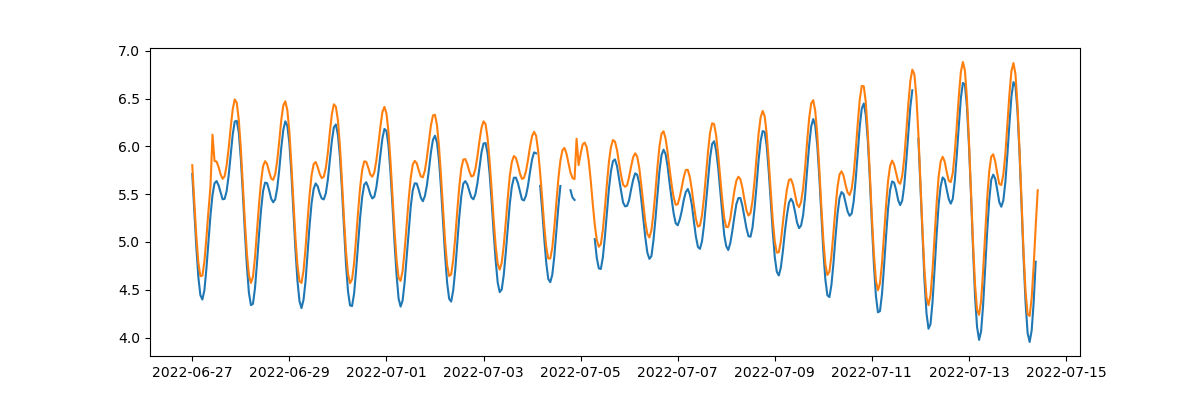

In [104]:
dsds[mid_s]['Tp'].time
# dfv_dict[mid_v]['depth_loc']
hrms.time
dloc
dfv_dict['C3']['depth_loc'].loc[t0:t1] - dsds['C3']['depth_loc'].sel(time=slice(t0,t1))
plt.clf(); plt.close()
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(dfv_dict['C3']['depth_loc'].loc[t0:t1].index, dfv_dict['C3']['depth_loc'].loc[t0:t1])
ax.plot(dsds['C3']['depth_loc'].sel(time=slice(t0,t1)).time, dsds['C3']['depth_loc'].sel(time=slice(t0,t1)))

plt.show()

In [ ]:
midss = ['C1', 'C3', 'C6',]# 'L5']
midsv = ['C2', 'C3', 'C5',]# 'L5']
fig, axes = plt.subplots(figsize=(7.5, 3.75), ncols=2, constrained_layout=True,
                         sharex=True, sharey=True)
xss = {} # Dict to store x values for regressions, Signatures
yss = {} # Dict to store y values for regressions, Signatures
xsv = {} # Dict to store x values for regressions, Vectors
ysv = {} # Dict to store y values for regressions, Vectors
for mid_s, mid_v in zip(midss, midsv):
    # Signature AST surface elevation skewness vs. Hrms/depth from C1
    # xis = (dsds['C1']['Hrms']/dsds['C1']['depth_loc']).to_series().to_frame()
    coef = (3/4) * 9.81 / (8*np.pi**2) # Constant of Ursell number
    frac = ((dsds['C1']['Hrms'] * (dsds['C1']['Tp']**2)) / (dsds['C1']['depth_loc']**2))
    xis = (coef * frac).to_series().to_frame()
    xis.columns = ['x']
    yis = dsds[mid_s]['skew'].to_dataframe()
    yis.columns = ['y']
    # Merge xi and yi to get same periods
    dfxy_s = xis.merge(yis, left_on='time', right_on='time').dropna()
    # Also merge C1 Tp
    c1_tp = dsds['C1']['Tp'].to_series().to_frame()
    c1_tp.columns = ['Tp']
    dfxy_s = dfxy_s.merge(c1_tp, left_on='time', right_on='time')
    xss[mid_s] = dfxy_s['x'] # Store to dict for regression
    yss[mid_s] = dfxy_s['y'] # Store to dict for regression
    axes[0].scatter(dfxy_s['x'], dfxy_s['y'], color=clss[mid_s], alpha=0.8, 
                    label=sig_mids[mid_s], s=dfxy_s['Tp']*1.5)

    # Signature AST vertical velocity skewness vs. Hrms/depth from C1
    # xis = (dsds['C1']['Hrms']/dsds['C1']['depth_loc']).to_series().to_frame()
    coef = (3/4) * 9.81 / (8*np.pi**2) # Constant of Ursell number
    frac = ((dsds['C1']['Hrms'] * (dsds['C1']['Tp']**2)) / (dsds['C1']['depth_loc']**2))
    xis = (coef * frac).to_series().to_frame()
    xis.columns = ['x']
    yis = dsds[mid_s]['skew'].to_dataframe()
    yis.columns = ['y']
    # Merge xi and yi to get same periods
    dfxy_s = xis.merge(yis, left_on='time', right_on='time').dropna()
    # Also merge C1 Tp
    c1_tp = dsds['C1']['Tp'].to_series().to_frame()
    c1_tp.columns = ['Tp']
    dfxy_s = dfxy_s.merge(c1_tp, left_on='time', right_on='time')
    xss[mid_s] = dfxy_s['x'] # Store to dict for regression
    yss[mid_s] = dfxy_s['y'] # Store to dict for regression
    axes[0].scatter(dfxy_s['x'], dfxy_s['y'], color=clss[mid_s], alpha=0.8, 
                    label=sig_mids[mid_s], s=dfxy_s['Tp']*1.5)

    # Vector cross-shore velocity skewness - also plot against C1 Hrms/d
    # xiv = (dfv_dict[mid]['Urms']).to_frame()
    # xiv = (dfv_dict[mid]['Urms']/dfv_dict[mid]['depth_loc']).to_frame()
    # xiv = (dsds['C1']['Hrms']/dsds['C1']['depth_loc']).to_series().to_frame()
    coef = (3/4) * 9.81 / (8 * np.pi**2) # Constant of Ursell number
    frac = ((dsds['C1']['Hrms'] * (dsds['C1']['Tp']**2)) / (dsds['C1']['depth_loc']**2))
    xiv = (coef * frac).to_series().to_frame()
    xiv.columns = ['x']
    yiv = dfv_dict[mid_v]['skew_ucs'].to_frame()
    yiv.columns = ['y']
    # Merge xi and yi to get same periods
    dfxy_v = xiv.merge(yiv, left_on='time', right_on='time').dropna()
    # Also merge C1 Tp
    c1_tp = dsds['C1']['Tp'].to_series().to_frame()
    c1_tp.columns = ['Tp']
    dfxy_v = dfxy_v.merge(c1_tp, left_on='time', right_on='time')
    xsv[mid_v] = dfxy_v['x']
    ysv[mid_v] = dfxy_v['y']
    axes[2].scatter(dfxy_v['x'], dfxy_v['y'], label=vec_mids[mid_v],
                    color=clsv[mid_v], alpha=0.8, s=dfxy_v['Tp']*1.5,
                    # s=5, edgecolors='k', lw=0.5)
                    )
# Linear regression lines on top of scatter points
for mid_s, mid_v in zip(midss, midsv):
    # Signatures
    x = xss[mid_s]
    y = yss[mid_s]
    # Linear regression
    model = smm.RLM(y, smm.add_constant(x), missing='drop', M=smm.robust.norms.HuberT())
    results = model.fit()
    b, m = results.params
    axes[0].axline(xy1=(0,b), slope=m, color=clss[mid_s], linestyle='-', lw=2.5,
                   path_effects=[pe.Stroke(linewidth=3.25, foreground='k'), pe.Normal()])
    # Vectors
    x = xsv[mid_v]
    y = ysv[mid_v]
    # Linear regression
    model = smm.RLM(y, smm.add_constant(x), missing='drop', M=smm.robust.norms.HuberT())
    results = model.fit()
    b, m = results.params
    s = f'$y = {m:.4f}x$' # Regression function
    axes[1].axline(xy1=(0,b), slope=m, color=clsv[mid_v], linestyle='-', lw=2.5,
                   path_effects=[pe.Stroke(linewidth=3.25, foreground='k'), pe.Normal()])
# Labels
axes[0].set_ylabel(r'$\mathrm{skew}(\zeta)$ [-]')
axes[1].set_ylabel(r'$\mathrm{skew}(u)$ [-]')
axes[0].set_xlabel(r'$H_\mathrm{rms, SI} / d_\mathrm{SI}$ [-]')
axes[1].set_xlabel(r'$H_\mathrm{rms, SI} / d_\mathrm{SI}$ [-]')
# Legend, grid, annotate
annot = ['(a)', '(b)']
for ann, ax in zip(annot, axes):
    lgnd = ax.legend(loc='lower right')
    for handle in lgnd.legend_handles:
        handle.set_sizes([15])
    ax.grid(alpha=0.5, lw=0.5)
    ax.annotate(ann, xy=(0.05, 0.9), xycoords='axes fraction', fontsize=14)

plt.tight_layout()
plt.show()
# plt.close()



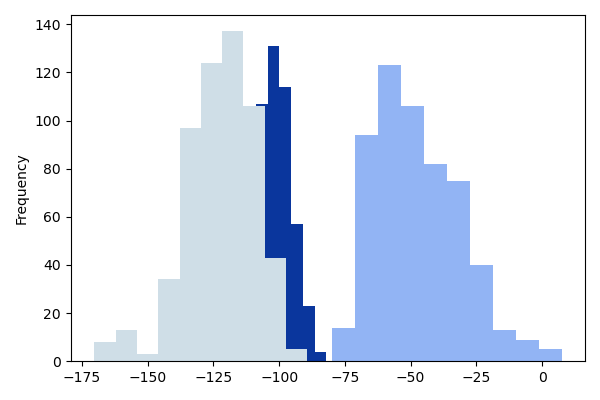

In [13]:
mids = ['C2', 'C3', 'C5']
fig, ax = plt.subplots(figsize=(6,4))
for mid in mids:
    dfv_dict[mid]['phase_uw'].plot.hist(ax=ax, color=clsv[mid])

plt.tight_layout()
plt.show()

In [16]:
dfv_dict[mid]

,Urms,wm,eps_ps,eps_ps_std,eps_lt,m0uv,m0w,skew_ucs,depth_loc,phase_uw
time,,,,,,,,,,
2022-06-27 00:00:00,0.193896,-0.003071,NaN,NaN,0.000010,0.017148,0.000651,0.144815,5.676172,-102.518807
2022-06-27 01:00:00,0.195998,0.002793,0.000015,0.000001,0.000012,0.017269,0.000827,0.062174,5.676172,-120.562964
2022-06-27 02:00:00,0.187729,-0.000793,NaN,NaN,0.000013,0.015889,0.000834,-0.063960,5.676172,-122.870473
2022-06-27 03:00:00,0.187486,-0.003037,NaN,NaN,0.000019,0.015870,0.000868,0.037159,5.676172,-115.874425
2022-06-27 04:00:00,0.202459,-0.002468,NaN,NaN,0.000018,0.018451,0.000982,-0.028206,5.676172,-122.099736
...,...,...,...,...,...,...,...,...,...,...
2022-07-20 20:00:00,0.372506,0.001613,0.000132,0.000047,0.000184,0.065596,0.003352,-0.037868,5.671063,-107.745415
2022-07-20 21:00:00,0.377312,-0.001871,0.000123,0.000041,0.000137,0.067749,0.003340,-0.032832,5.671063,-106.024919
2022-07-20 22:00:00,0.407741,-0.005289,0.000106,0.000033,0.000124,0.079266,0.003966,-0.057467,5.671063,-103.270873


Figure A1: Phase-resolved vs Trowbridge & Elgar dissipation rates, all Vectors.

In [79]:
# Use all Vectors
# mids = ['C2', 'C3', 'C5', 'L1', 'L5']
mids = ['C2', 'C3', 'C5', 'L5']
# Init. figure
fig, axes = plt.subplots(figsize=(7.5,3.75), ncols=2, constrained_layout=True)
mv = [] # Max. values for axis limits
xs = [] # List of x arrays for histograms
ys = [] # List of y arrays for histograms
xyr = [] # List of x/y ratio arrays for histograms
rws = [] # Histogram weights for normalization
# Iterate over Vectors and plot
for i,mid in enumerate(mids):
    x = (dfv_dict[mid]['eps_lt']).to_frame()
    y = dfv_dict[mid]['eps_ps'].to_frame()
    ystd = dfv_dict[mid]['eps_ps_std']#.to_frame()
#     axes[0].scatter(x, y, color=clsv[mid], label=vec_mids[mid], edgecolors='k', 
#                     lw=0.5, alpha=0.8)
    axes[0].errorbar(x.values, y.values.squeeze(), color=clsv[mid], yerr=ystd, 
                     label=vec_mids[mid], 
                     capsize=1.5, ms=3, alpha=0.75, elinewidth=0.5, fmt='o',
                     markeredgecolor='k', ecolor='k', mew=0.5,
                     )
#     dfv_dict[mid].plot(ax=axes[0], kind='scatter', x='eps_lt', y='eps_ps', 
#                        yerr='eps_ps_std', c=clsv[mid], label=vec_mids[mid], )
    # Least squares fit, see:
    # https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
    # Force intercept to be 0, see:
    # https://stackoverflow.com/questions/54257216/how-to-set-intercept-to-0-with-statsmodel-for-multiple-linear-regression
    # model = sm.OLS(y, x.assign(intercept=0), missing='drop')
    #     model = sm.RLM(y, sm.add_constant(x), missing='drop', M=sm.robust.norms.HuberT())
    #     results = model.fit()
    #     b, m = results.params
    # Force intercept to go through zero
    model = smm.RLM(y, x.assign(intercept=0), missing='drop', 
                    M=smm.robust.norms.HuberT())
    results = model.fit()
    m, b = results.params
    # Plot least squares fit
    #     if b < 0:
    #         s = f'$y = {m:.2f}x - {abs(b):.2f}$' # Line label
    #     else:
    #         s = f'$y = {m:.2f}x + {b:.2f}$' # Line label
    s = f'$y = {m:.2f}x$' # Regression function
    axes[0].axline(xy1=(0,b), slope=m, color=clsv[mid], linestyle='-', lw=2)
    # Annotate regression functions
    axes[0].annotate(s, xy=(0.05, 0.58-(0.05*i)), xycoords='axes fraction', c=clsv[mid],
                     fontsize=10)
    # Get max. value for axis limits
    mv.append(np.max((x.max(), y.max())))
    # Append x/y ratio to list
    xy_ratio = (x.squeeze() / y.squeeze())
    xyr.append(xy_ratio.values)
    # Weights for normalization
    rw = np.empty(xy_ratio.shape)
    rw.fill(1/xy_ratio.shape[0])
    rws.append(rw)
# 1:1 line
m = np.max(mv) # Max epsilon value
axes[0].axline((m, m), slope=1, c='k', ls='--', lw=1)
axes[0].annotate(r'$x = y$', xy=(0.05, 0.58+0.05), xycoords='axes fraction', c='k',
                 fontsize=10)
# Legend, grid etc
axes[0].legend(loc='upper left')
axes[0].grid(alpha=0.5, lw=0.5)
# Equal x and y axis limits
axes[0].set_xlim([-0.0001, m+0.0001])
axes[0].set_ylim([-0.0001, m+0.0001])

# Histograms of x/y ratios on right
bins = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
n, bins, patches = axes[1].hist(xyr, color=list(clsv.values()), bins=bins, 
                                weights=rws)
axes[1].set_xticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2])

axes[0].set_ylabel(r'$\epsilon$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')
axes[0].set_xlabel(r'$\epsilon_\mathrm{TE01}$ $[\mathrm{m}^2 \mathrm{s}^{-3}]$')
axes[1].set_ylabel('pdf')
axes[1].set_xlabel(r'$\epsilon_\mathrm{TE01} \, / \, \epsilon$ [-]')

fn_fig_a1 = os.path.join(outdir, 'fig_a1_eps_ps_vs_te01.pdf')
if not os.path.isfile(fn_fig_a1):
    plt.savefig(fn_fig_a1, bbox_inches='tight', dpi=600)
# plt.show()
plt.close()

print('Done.')